# Data Analysis (CARTA)

We want to assess the effects on the predictive accuracy of our board and alight count models considering the following two data partitions (and combinations):

* Pre- and post-lockdown.
* Overdispersion based on the mean and variance of the pre-defined groups:
    - `Poisson`
    - `Mean_Greater_Var`
    - `Overdispersed`

|    |      Pre-lockdown      |  Post-lockdown |
|----------|:-------------:|------:|
| Poisson Assumption | Group A1  | Group A2 |
| Mean greater than the Varaiance | Group B1  | Group B2   |
| Overdispersed | Group C1  | Group C2   |


First, we analyze the marginal effects of these partitions. By separating the data based on a drastic change in ridership (Pre and post-lockdown), we will be able to know if we can predict pre- and post-lockdown data. We will compare the training and testing MSEs of the models without the partition versus the training and testing MSEs of the models with the partition.

Besides that, we are also assuming that the board and alight counts (grouped by day of the week, route, direction, stop id) follow Poisson distributions whose parameters indicate their hourly mean, we will be able to know if grouping the data based on the Poisson assumption -mean is (approximately) equal to variance- improves the predictive accuracy of the models. Similarly, this task requires comparing the model's MSEs with and without the grouping or classification according to the Poisson assumption.

Moreover, we will analyze the combined effect of these two data partitions on the models' performance. This will allow us to know the optimum machine learning pipeline (data classification + model regressions) for parametric regressions such as Poisson, Quasi-Poisson, Negative-Binomial, Zero-inflated, and Hurdle regression models.

On the other hand, we will identify the data characteristics that require approaches with higher flexibility, such as Neural Networks. The obtained results and conclusions will help modelers (and decision-makers) to improve the accuracy and interpretability of parametric models by proposing model pipelines for the board and alight counts.


# On Predictive Pipelines for Estimating the Expected Boarding and Alighting and Occupancy Count for Public Transit Systems

## Abstract

Fine-grained ridership forecasting is important for providing guidance to commuters, and performing operational optimization for public transit, especially during pandemic. Traditional approaches to modeling the underlying random processes fail to learn accurate dynamics and covariate determinants because of the wide variances, over dispersion (i.e., variances are greater than the mean) and zero counts in the available automated passenger count for the transit vehicles. This is partially due to the affect the pandemic has had on ridership patterns. Our contribution in this paper is to present a predictive pipeline that solves these problems and prevents a comparative analysis of several modeling strategies including Poisson, Quasi-Poisson, Negative-Binomial, Zero inflated Poisson, hurdle-models, and neural networks. Our innovation lies in the automatic partitioning of data into bins that are created not only on the basis of the route structure, stops, day of the week, direction but also using the degree of over dispersion (mean close to variance i.e., Poisson, variance greater than the mean and mean greater than the variance) and the homogeneity of the mean across sliding time windows. We further identify the optimal predictive model and describe an automated mechanism for selecting the models. The obtained results and conclusions will help modelers (and decision-makers) to improve the accuracy and interpretability of parametric models by proposing model pipelines for the board and alight counts and choose the appropriate model for real-time prediction. We present results using the data from two large communities in USA and compare our results against single models that are prevalent in the state of the art.


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree 

The following data is the latest version of the CARTA data set. It is the data that was processed by Mike during Dec-2020 and uploaded on January 4 2021 (01-04-2021). The data can be found in the following folder in Teams:

* General > datasets > carta-occupancy > app-data:
    * cartaapac_dashboard.csv.zip 
    

In [2]:
carta = pd.read_csv('cartaapc_dashboard2.zip')
#arta = pd.read_csv('carta.csv')
total_num_rows = carta.shape[0]

In [3]:
carta.stop_id = carta['stop_id'].astype(str)
carta.stop_sequence = carta['stop_sequence'].astype(int)
carta.route_id = carta['route_id'].astype(str)
carta.service_period = carta['service_period'].astype(str)
carta.actual_arrival_time = pd.to_datetime(carta['actual_arrival_time'], format = "%H:%M:%S")
carta.scheduled_arrival_time = pd.to_datetime(carta['scheduled_arrival_time'], format = "%H:%M:%S")
carta.date = pd.to_datetime(carta['date'], format = "%Y-%m-%d")
carta.scheduled_datetime = pd.to_datetime(carta['scheduled_datetime'], format = "%Y-%m-%d %H:%M:%S")
carta.trip_date = pd.to_datetime(carta['trip_date'], format="%Y-%m-%d")
carta.trip_start_time = pd.to_datetime(carta['trip_start_time'], format="%H:%M:%S")

In [4]:
carta['year'] = carta['date'].dt.year
carta['month'] = carta['date'].dt.month
#carta.hour = carta['hour'].astype(str)
#carta.month = carta['month'].astype(str)

In [5]:
carta['day_of_week'] = carta['day_of_week'].astype('category')

In [6]:
carta.dtypes

trip_id                             int64
scheduled_arrival_time     datetime64[ns]
actual_arrival_time        datetime64[ns]
stop_id                            object
stop_sequence                       int64
stop_lat                          float64
stop_lon                          float64
route_id                           object
direction_id                        int64
board_count                         int64
alight_count                        int64
occupancy                           int64
direction_desc                     object
service_period                     object
date                       datetime64[ns]
scheduled_datetime         datetime64[ns]
actual_arrival_datetime            object
trip_start_time            datetime64[ns]
day_of_week                      category
trip_date                  datetime64[ns]
hour                                int64
year                                int64
month                               int64
dtype: object

*I used all the routes, but they can be easily filter as follows:*

- `data_filter_by_routeX = carta[carta['route_id] == 'routeX']`

* Similarly, with the `stop_id`s.

In [7]:
carta = carta.sort_values(by = ['actual_arrival_datetime'])
carta.head(10)

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,service_period,date,scheduled_datetime,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month
399632,134401,1900-01-01 00:00:04,1900-01-01 00:00:00,971,47,35.024347,-85.246812,4,1,0,...,Weekday,2019-01-02,2019-01-03 00:00:04,2019-01-02 00:00:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1
386516,133083,1900-01-01 23:59:34,1900-01-01 00:01:00,146,12,34.989585,-85.304620,1,1,0,...,Weekday,2019-01-02,2019-01-02 23:59:34,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1
399634,134401,1900-01-01 00:00:55,1900-01-01 00:01:00,1545,49,35.026032,-85.250863,4,1,0,...,Weekday,2019-01-02,2019-01-03 00:00:55,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1
399633,134401,1900-01-01 00:00:30,1900-01-01 00:01:00,972,48,35.025717,-85.248528,4,1,0,...,Weekday,2019-01-02,2019-01-03 00:00:30,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1
386517,133083,1900-01-01 23:59:45,1900-01-01 00:01:00,81,13,34.990302,-85.304890,1,1,0,...,Weekday,2019-01-02,2019-01-02 23:59:45,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1
386518,133083,1900-01-01 00:00:00,1900-01-01 00:01:00,90,14,34.991247,-85.304968,1,1,0,...,Weekday,2019-01-02,2019-01-03 00:00:00,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1
399636,134401,1900-01-01 00:01:38,1900-01-01 00:02:00,975,51,35.027633,-85.254727,4,1,0,...,Weekday,2019-01-02,2019-01-03 00:01:38,2019-01-02 00:02:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1
399635,134401,1900-01-01 00:01:20,1900-01-01 00:02:00,1911,50,35.026909,-85.253110,4,1,0,...,Weekday,2019-01-02,2019-01-03 00:01:20,2019-01-02 00:02:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1
386519,133083,1900-01-01 00:00:11,1900-01-01 00:02:00,1486,15,34.991815,-85.305763,1,1,0,...,Weekday,2019-01-02,2019-01-03 00:00:11,2019-01-02 00:02:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1
386520,133083,1900-01-01 00:00:15,1900-01-01 00:02:00,1899,16,34.991990,-85.306320,1,1,0,...,Weekday,2019-01-02,2019-01-03 00:00:15,2019-01-02 00:02:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1


In [8]:
#carta.groupby(['day_of_week'])['board_count'].mean()
carta.groupby(['service_period'])['board_count'].mean()

service_period
Saturday    0.130391
Sunday      0.153384
Weekday     0.131911
Name: board_count, dtype: float64

In [9]:
service_period = carta['service_period']

In [10]:
service_kind = []

for i in service_period:
    if (i == 'Saturday'):
        kind = 'weekend'
    elif (i == 'Sunday'):
        kind = 'weekend'
    else:
        kind = 'weekday'
    
    service_kind.append(kind)

In [11]:
carta['service_kind'] = service_kind

In [12]:
carta.groupby(['service_kind'])['board_count'].count()

service_kind
weekday    8424165
weekend    1281798
Name: board_count, dtype: int64

In [13]:
carta.actual_arrival_datetime.min()

'2019-01-02 00:00:00'

In [14]:
carta.actual_arrival_datetime.max()

'2020-05-31 21:04:00'

In [15]:
Weather_Chatt = pd.read_csv('carta_weather.csv')
Weather_Chatt.head()

,actual_arrival_datetime,temp,precip
0,2019-01-02 00:00:00,7.800000,0.0
1,2019-01-02 00:01:00,7.781667,0.0
2,2019-01-02 00:01:00,7.781667,0.0
3,2019-01-02 00:01:00,7.781667,0.0
4,2019-01-02 00:01:00,7.781667,0.0


In [16]:
Weather_Chatt.dtypes

actual_arrival_datetime     object
temp                       float64
precip                     float64
dtype: object

In [17]:
Weather_Chatt.shape

(9705963, 3)

In [18]:
carta['temp'] = Weather_Chatt.temp
carta['precip'] = Weather_Chatt.precip

In [19]:
carta.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
399632,134401,1900-01-01 00:00:04,1900-01-01 00:00:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 00:00:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
386516,133083,1900-01-01 23:59:34,1900-01-01 00:01:00,146,12,34.989585,-85.304620,1,1,0,...,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,weekday,10.55,0.0
399634,134401,1900-01-01 00:00:55,1900-01-01 00:01:00,1545,49,35.026032,-85.250863,4,1,0,...,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
399633,134401,1900-01-01 00:00:30,1900-01-01 00:01:00,972,48,35.025717,-85.248528,4,1,0,...,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
386517,133083,1900-01-01 23:59:45,1900-01-01 00:01:00,81,13,34.990302,-85.304890,1,1,0,...,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,weekday,10.55,0.0


In [20]:
carta.to_csv("carta.csv.zip", 
           index=False, 
           compression="zip")

# Exploration Data Analysis

## Board Count


In [21]:
def normalizer(x):
    
    x_min = min(x)
    x_max = max(x)
    x_norm = (x - x_min)/(x_max - x_min)
    
    return(x_norm)
    

In [22]:
def standardizer(x):
    x_std = x.std()
    x_mean = x.mean()
    x_standard = (x - x_mean)/x_std
    
    return(x_standard)

### Board Count and Bus Stops

In this section we present the board and alight count means per bus stop for each route and directions ids.

The dataset has 16 different `route_id`s:

In [24]:
len(carta.route_id.unique())

16

In [25]:
carta.route_id.unique()

array(['4', '1', '7', '9', '13', '8', '10G', '16', '15', '10C', '2',
       '10A', '28', '19', '21', '3'], dtype=object)

The following dataframe presents the number of bus stops of each route in both directions:

In [26]:
Num_stops_per_route = carta[['route_id', 'direction_id', 'stop_id']].groupby(['route_id', 'direction_id'])['stop_id'].nunique()
Num_stops_per_route = Num_stops_per_route.reset_index(level = ['route_id', 'direction_id'])
Num_stops_per_route.columns = ['route_id', 'direction_id', 'Num_bus_stops']
Num_stops_per_route

,route_id,direction_id,Num_bus_stops
0,1,0,31
1,1,1,84
2,10A,0,46
3,10A,1,80
4,10C,0,105
5,10G,0,73
6,10G,1,106
7,13,0,75
8,13,1,75
9,15,0,52


## Board count boxplots

In [27]:
box_route4 = carta[(carta['route_id'] == '4') & (carta['direction_id'] == 1)][['stop_id', 'board_count']]#.groupby(['route_id', 'direction_id', 'stop_sequence','stop_id']).mean().reset_index(level = ['route_id', 'direction_id', 'stop_sequence','stop_id'])[['stop_sequence', 'stop_id', 'board_count']]

In [28]:
box_route4.head()

,stop_id,board_count
399632,971,0
399634,1545,0
399633,972,0
399636,975,0
399635,1911,0


In [29]:
box_route4.dtypes

stop_id        object
board_count     int64
dtype: object

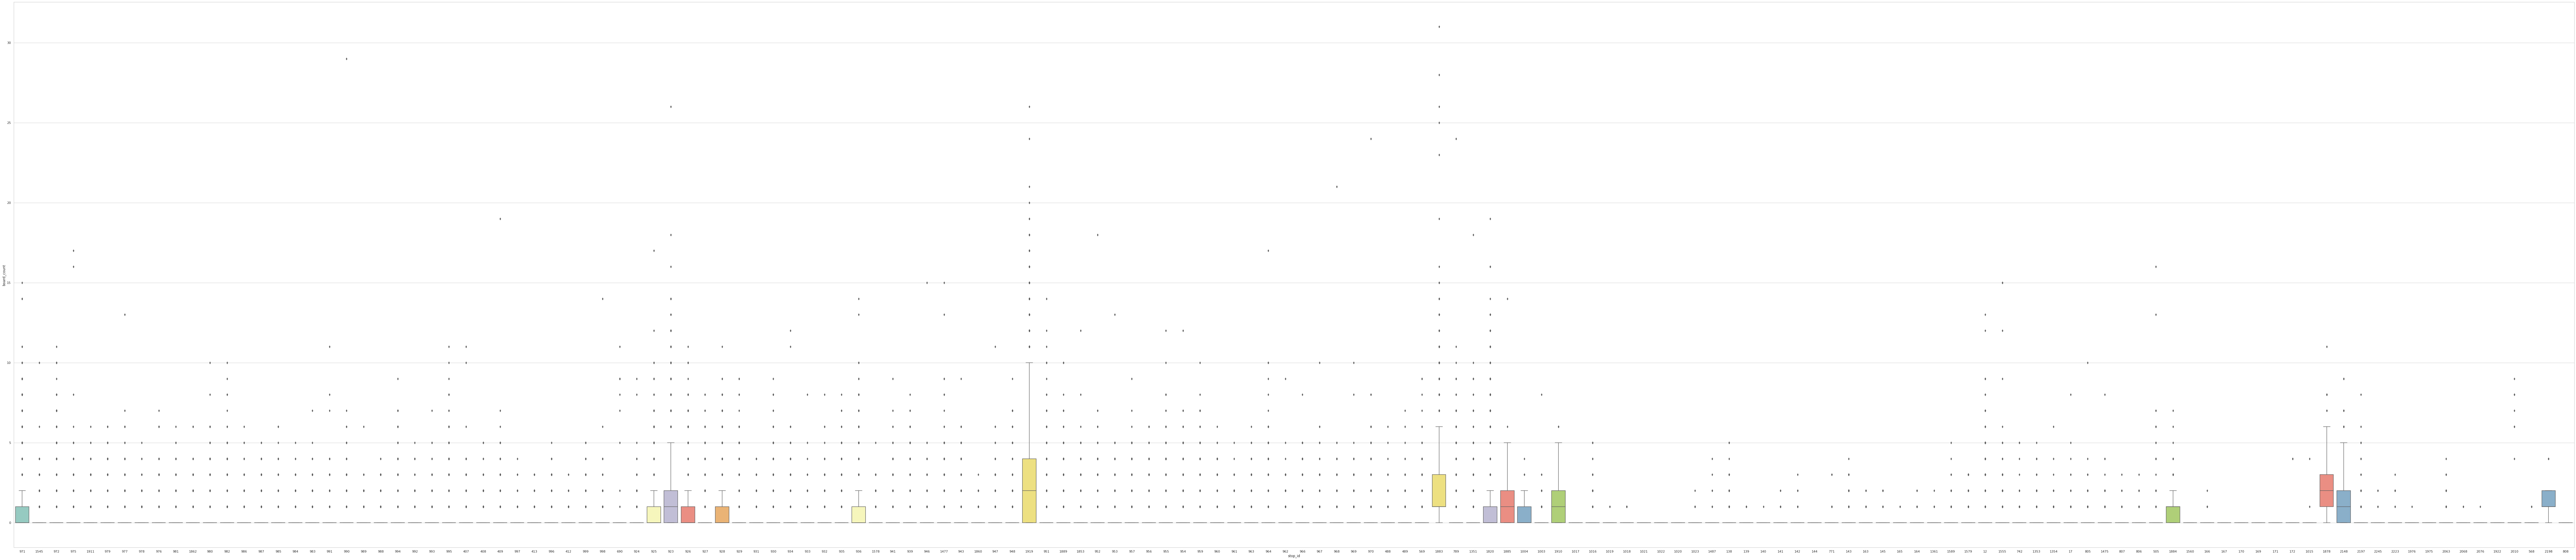

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

#labels = box_route4['stop_id'].unique()
#ax.boxplot(dataset, labels=labels)

ax = plt.figure(figsize = (160, 35))

sns.set_theme(style="whitegrid")
#tips = sns.load_dataset("tips")

ax = sns.boxplot(x= box_route4["stop_id"], y =  box_route4['board_count'], data = box_route4, palette="Set3")

#plt.figure(figsize=(20,10))

#box_route4.boxplot(column = ['board_count'], by = ['stop_id'])




In [23]:
#carta[(carta['route_id'] == '4') & (carta['direction_id'] == 1)][['route_id', 'direction_id', 'stop_sequence', 'stop_id', 'board_count']].groupby(['route_id', 'direction_id', 'stop_sequence','stop_id']).mean().reset_index(level = ['route_id', 'direction_id', 'stop_sequence','stop_id'])[['stop_sequence', 'stop_id', 'board_count']]

In [24]:
def mean_by_stop(rt, di, pr):
    if pr == 'board_count':
        mean_by_route = carta[(carta['route_id'] == rt) & (carta['direction_id'] == di)][['route_id', 'direction_id', 'stop_sequence', 'stop_id', 'board_count']].groupby(['route_id', 'direction_id', 'stop_sequence','stop_id']).mean().reset_index(level = ['route_id', 'direction_id', 'stop_sequence','stop_id'])[['stop_sequence', 'stop_id', 'board_count']]
        
        return(mean_by_route)
    elif pr == 'alight_count':
        mean_by_route = carta[(carta['route_id'] == rt) & (carta['direction_id'] == di)][['route_id', 'direction_id', 'stop_sequence', 'stop_id', 'alight_count']].groupby(['route_id', 'direction_id', 'stop_sequence','stop_id']).mean().reset_index(level = ['route_id', 'direction_id', 'stop_sequence','stop_id'])[['stop_sequence', 'stop_id', 'alight_count']]
        
        return(mean_by_route)
    else:
        mean_by_route = carta[(carta['route_id'] == rt) & (carta['direction_id'] == di)][['route_id', 'direction_id', 'stop_sequence', 'stop_id', 'occupancy']].groupby(['route_id', 'direction_id', 'stop_sequence','stop_id']).mean().reset_index(level = ['route_id', 'direction_id', 'stop_sequence','stop_id'])[['stop_sequence', 'stop_id', 'occupancy']]
        
        return(mean_by_route)

In [39]:
route1_dir0_means = mean_by_stop('1', 0, 'board_count')
route1_dir1_means = mean_by_stop('1', 1, 'board_count')
route4_dir0_means = mean_by_stop('4', 0, 'board_count')
route4_dir1_means = mean_by_stop('4', 1, 'board_count')

In [84]:
carta.shape

(9705963, 26)

In [130]:
route4_dir1_means.stop_id.iloc[0:20]

0     1878
1     1883
2     1884
3     1885
4     1003
5     1487
6      923
7     1004
8      138
9     2148
10     924
11    1015
12     139
13     924
14     925
15     140
16    1910
17     925
18     926
19    1016
Name: stop_id, dtype: object

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(0.5, 0, 'Bus Stops'), Text(0, 0.5, 'Mean Board Count')]

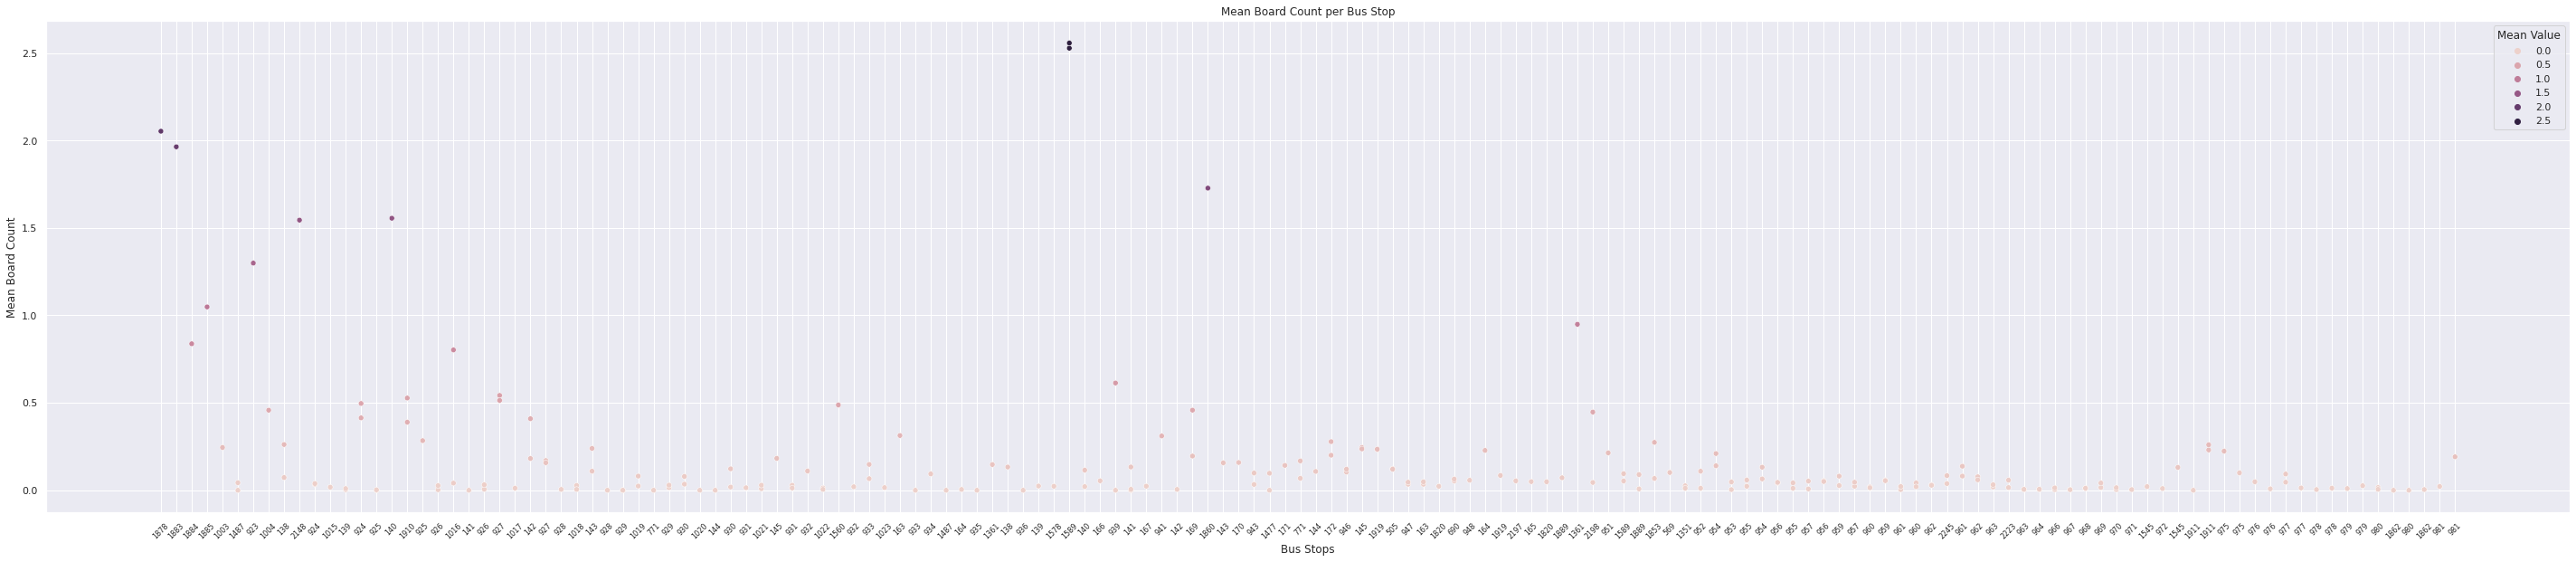

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

#colors = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3])


ax = plt.figure(figsize = (50, 10))

#sns.axes_style()
#plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

#plt.subplot(2,1,1)
#plt.colorbar(im)

ax = sns.scatterplot(route4_dir1_means.stop_id, route4_dir1_means.board_count, hue = route4_dir1_means.board_count)

new_legend_title = 'Mean Board Count per Bus Stop'

ax.set_title(new_legend_title)
ax.legend(title = 'Mean Value')
#ax.xticks(route4_dir1_means.stop_id, rotation = 45, fontsize = 8)
ax.set_xticklabels(route4_dir1_means.stop_id, rotation = 45, fontsize = 8)
ax.set(xlabel="Bus Stops", ylabel = "Mean Board Count")

#plt.scatter(route4_dir1_means.stop_sequence, route4_dir1_means.board_count, c = route4_dir1_means.board_count, cmap = 'viridis')
#plt.scatter(-1*route4_dir0_means.stop_sequence, route4_dir0_means.board_count, c = route4_dir0_means.board_count, cmap = 'viridis')
#plt.text()
#plt.ylabel('Mean Board Count')
#plt.xlabel('Direction: Negative values for direction id 0, and positive values for direction id 1')

#plt.subplot(2,1,2)
#plt.scatter(route1_dir1_means.stop_sequence, route1_dir1_means.board_count, c = route1_dir1_means.board_count, cmap = 'viridis')
#plt.scatter(-1*route1_dir0_means.stop_sequence, route1_dir0_means.board_count, c = route1_dir0_means.board_count, cmap = 'viridis')
#plt.ylabel('Mean Board Count')
#plt.xlabel('Direction: Negative values for direction id 0, and positive values for direction id 1')

## Weather Data

In [542]:
carta['precip'].describe()

count    9.705963e+06
mean     1.958002e-01
std      1.045905e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.840000e+01
Name: precip, dtype: float64

# Baseline Model

We generate two "baseline" models without any type of data partition. The performance of these models will define our standard, which will allows us to determine the relative performance or accuracy or improvmenent of the proposed models based on the proposed data partitions. 

## Regressors

* `year`: Categorical Variable
* `month`: Categorical Variable
* `service_kind`: Categorical Variable
* `hour`: Categorical Variable
* Surrounding board counts aggregate: Discrete variable that aggregates the board count data  from the all bus stops that are within half-mile radius from the bus stop under study.
* `temp`: Temperature is continous variable that was created using an hourly average.
* `precip`: Precipitation is continous variable that was created using an hourly average.


### Surrounding board counts aggregate

In [23]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd
from geopy import Point
from geopy import distance

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [24]:
Bus_Stops = pd.read_csv('Bus_Stops.csv')
Bus_Stops.stop_id = Bus_Stops['stop_id'].astype(str)
Bus_Stops.head()

,stop_id,stop_lon,stop_lat
0,971,-85.246812,35.024347
1,146,-85.304620,34.989585
2,1545,-85.250863,35.026032
3,972,-85.248528,35.025717
4,81,-85.304890,34.990302


#### Radial Influence Function

In [25]:
def radial_influence(st, radius, DT):
    n_row = DT.shape[0]
    
    stopd_index = DT[DT['stop_id'] == st].index[0]
    x0 = DT.stop_lon.iloc[stopd_index]
    y0 = DT.stop_lat.iloc[stopd_index]
    
    radial_dist = []
    condition = []
    
    for i in range(n_row):
        
        center_point = (x0, y0)
        test_point = (DT.stop_lon.iloc[i], DT.stop_lat.iloc[i])
        dist = distance.distance(center_point, test_point).miles
        
        radial_dist.append(dist)
        
        if (dist <= radius):
            
            cond = 'inside'
            
        else:
            
            cond = 'outside'
            
        condition.append(cond)
        
    influence = {'stop_id': DT.stop_id, 'Radial_Distance': radial_dist, 'Influence': condition}
    Influence = pd.DataFrame(data = influence, columns = ['stop_id', 'Radial_Distance', 'Influence'])
    
    return(Influence)

## Data Extraction

The following function extracts the relevant information to create the dependent and independent variables. Also, it normalizes the continuous variables.

### Board Count

In [26]:
def board_data1(route, direction, bus_stop, DTFRM, radius, transf):
    import numpy as np
    import pandas as pd
    import datetime as dt
             
    dtfrm = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction)]
    
    n_rows = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction) & (DTFRM['stop_id'] == bus_stop)].shape[0]
    
    if (n_rows == 0):
        print('There are not rows in the data set with the required characteristics. Please change them.')
        
    else:
          
        vinit = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction) & (DTFRM['stop_id'] == bus_stop)][['month', 'service_kind', 'hour', 'temp', 'precip']].groupby(['month', 'service_kind', 'hour']).mean()
        Vinit = vinit.reset_index(level = ['month', 'service_kind', 'hour'])
        Vinit.columns = ['month', 'service_kind', 'hour', 'mean_temp', 'mean_precip']
    
        V1 = dtfrm[(dtfrm['stop_id'] == bus_stop)][[ 'month', 'service_kind', 'hour', 'board_count']]
        V1 = V1.groupby(['month', 'service_kind', 'hour', 'board_count']).count()
        V1 = V1.reset_index(level = ['month', 'service_kind', 'hour', 'board_count'])
        V1.columns = ['month', 'service_kind', 'hour', 'board_count']
     
        V1 = V1.merge(vinit, on = ['month', 'service_kind', 'hour'], how = 'left')
    
        Relevant_Bus_Stops = radial_influence(bus_stop, radius, Bus_Stops)
        bus_stops_ids = Relevant_Bus_Stops.stop_id.unique().astype(str)
    
        V2 = DTFRM[DTFRM['stop_id'].isin(bus_stops_ids)]
    
        V3 = DTFRM[DTFRM['stop_id'].isin(bus_stops_ids)][['month', 'service_kind', 'hour', 'board_count']]
        V3a = V3.groupby(['month', 'service_kind', 'hour', 'board_count']).count()
        V3b = V3a.reset_index(level = ['month', 'service_kind', 'hour', 'board_count'])
        V3b.columns = ['month', 'service_kind', 'hour', 'surrounding_board_count']
    
        V = V1.merge(V3b, on = [ 'month', 'service_kind', 'hour'])
        
        V.month = V['month'].astype('category')
        V.service_kind = V['service_kind'].astype('category')
        V.hour = V['hour'].astype('category')
    
        if (transf == 'Normalization'):
                   
            V.board_count = normalizer(V['board_count'])
            V.surrounding_board_count = normalizer(V['surrounding_board_count'])
            V.temp = normalizer(V['temp'])
            V.precip = normalizer(V['precip'])
        
            return(V)
        
        elif (transf == 'Standardize'):
        
            V.board_count = standardizer(V['board_count'])
            V.surrounding_board_count = standardizer(V['surrounding_board_count'])
            V.temp = standardizer(V['temp'])
            V.precip = standardizer(V['precip'])
        
            return(V)
    
        elif (transf == 'features'):
            
            V.surrounding_board_count = normalizer(V['surrounding_board_count'])
            V.temp = normalizer(V['temp'])
            V.precip = normalizer(V['precip'])
        
            return(V)
        
        else:
                  
            return(V)
  

### Alight Count

In [43]:
def alight_data1(route, direction, bus_stop, DTFRM, radius, transf):
    import numpy as np
    import pandas as pd
    import datetime as dt
                    
    dtfrm = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction)]
    
    n_rows = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction) & (DTFRM['stop_id'] == bus_stop)].shape[0]
    
    if (n_rows == 0):
        print('There are not rows in the data set with the required characteristics. Please change them.')
        
    else:
          
        vinit = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction) & (DTFRM['stop_id'] == bus_stop)][['month', 'service_kind', 'hour', 'temp', 'precip']].groupby(['month', 'service_kind', 'hour']).mean()
        Vinit = vinit.reset_index(level = ['month', 'service_kind', 'hour'])
        Vinit.columns = ['month', 'service_kind', 'hour', 'mean_temp', 'mean_precip']
    
        V1 = dtfrm[(dtfrm['stop_id'] == bus_stop)][['month', 'service_kind', 'hour', 'alight_count']]
        V1 = V1.groupby(['month', 'service_kind', 'hour', 'alight_count']).count()
        V1 = V1.reset_index(level = ['month', 'service_kind', 'hour', 'alight_count'])
        V1.columns = ['month', 'service_kind', 'hour', 'alight_count']
     
        V1 = V1.merge(vinit, on = ['month', 'service_kind', 'hour'], how = 'left')
    
        Relevant_Bus_Stops = radial_influence(bus_stop, radius, Bus_Stops)
        bus_stops_ids = Relevant_Bus_Stops.stop_id.unique().astype(str)
    
        V2 = DTFRM[DTFRM['stop_id'].isin(bus_stops_ids)]
    
        V3 = DTFRM[DTFRM['stop_id'].isin(bus_stops_ids)][['month', 'service_kind', 'hour', 'alight_count']]
        V3a = V3.groupby(['month', 'service_kind', 'hour', 'alight_count']).count()
        V3b = V3a.reset_index(level = ['month', 'service_kind', 'hour', 'alight_count'])
        V3b.columns = ['month', 'service_kind', 'hour', 'surrounding_alight_count']
    
        V = V1.merge(V3b, on = ['month', 'service_kind', 'hour'])
        
        V.month = V['month'].astype('category')
        V.service_kind = V['service_kind'].astype('category')
        V.hour = V['hour'].astype('category')
    
        if (transf == 'Normalization'):
                   
            V.alight_count = normalizer(V['alight_count'])
            V.surrounding_alight_count = normalizer(V['surrounding_alight_count'])
            V.temp = normalizer(V['temp'])
            V.precip = normalizer(V['precip'])
        
            return(V)
        
        elif (transf == 'Standardize'):
        
            V.alight_count = standardizer(V['alight_count'])
            V.surrounding_alight_count = standardizer(V['surrounding_alight_count'])
            V.temp = standardizer(V['temp'])
            V.precip = standardizer(V['precip'])
        
            return(V)
    
        elif (transf == 'features'):
            
            V.surrounding_alight_count = normalizer(V['surrounding_alight_count'])
            V.temp = normalizer(V['temp'])
            V.precip = normalizer(V['precip'])
        
            return(V)
        
        else:
                  
            return(V)
  

## Pre and post lockdown

From Mike's paper: "Chattanooga’s steep decline started the week of **March 5th** before hitting a low also on the week of April 19 with a low of 8,077 weekly riders." 

Text(0, 0.5, 'Alight Count')

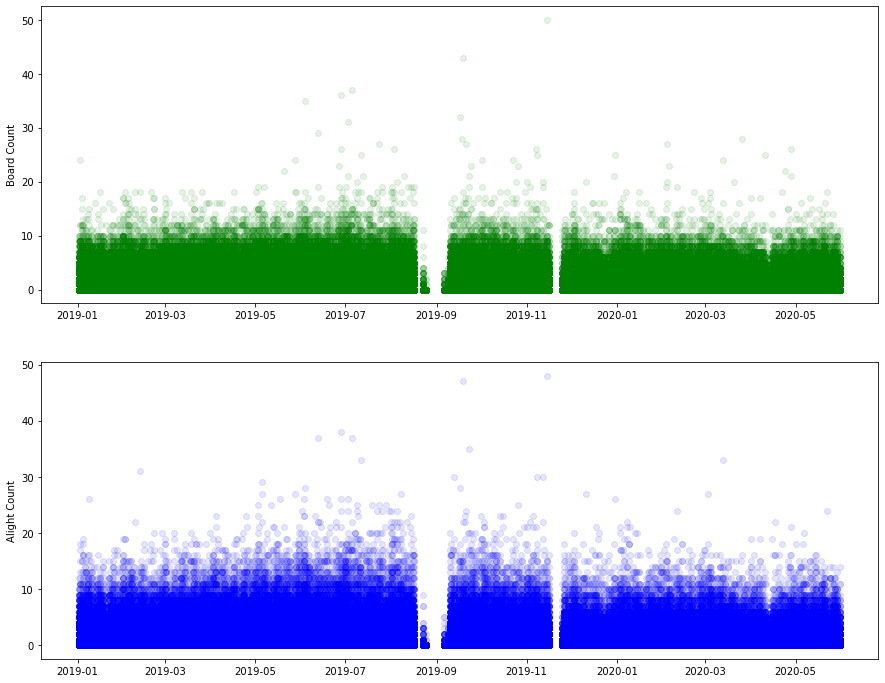

In [18]:
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(carta.date, carta.board_count, 'o', alpha = 0.1, color = 'green')
plt.ylabel('Board Count')

plt.subplot(2,1,2)
plt.plot(carta.date, carta.alight_count, 'o', alpha = 0.1, color = 'blue')
plt.ylabel('Alight Count')


Therefore, we subdivide the data using '2019-03-05':

* Pre-lockdown: `Pre_lock`
* Post-lockdown: `Post_lock`

### Pre-lockdown

In [36]:
Pre_lock = carta[carta['date'] < '2020-03-05']

In [29]:
Pre_lock.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
399632,134401,1900-01-01 00:00:04,1900-01-01 00:00:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 00:00:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
386516,133083,1900-01-01 23:59:34,1900-01-01 00:01:00,146,12,34.989585,-85.304620,1,1,0,...,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,weekday,10.55,0.0
399634,134401,1900-01-01 00:00:55,1900-01-01 00:01:00,1545,49,35.026032,-85.250863,4,1,0,...,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
399633,134401,1900-01-01 00:00:30,1900-01-01 00:01:00,972,48,35.025717,-85.248528,4,1,0,...,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
386517,133083,1900-01-01 23:59:45,1900-01-01 00:01:00,81,13,34.990302,-85.304890,1,1,0,...,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,weekday,10.55,0.0


In [30]:
Pre_lock.shape

(8602818, 26)

In [31]:
Pre_lock.dtypes

trip_id                             int64
scheduled_arrival_time     datetime64[ns]
actual_arrival_time        datetime64[ns]
stop_id                            object
stop_sequence                       int64
stop_lat                          float64
stop_lon                          float64
route_id                           object
direction_id                        int64
board_count                         int64
alight_count                        int64
occupancy                           int64
direction_desc                     object
service_period                     object
date                       datetime64[ns]
scheduled_datetime         datetime64[ns]
actual_arrival_datetime            object
trip_start_time            datetime64[ns]
day_of_week                      category
trip_date                  datetime64[ns]
hour                                int64
year                                int64
month                               int64
service_kind                      

In [32]:
Pre_lock.scheduled_datetime.nunique()

6891939

In [33]:
Pre_lock.scheduled_datetime.min()

Timestamp('2019-01-02 04:21:00')

In [34]:
Pre_lock.scheduled_datetime.max()

Timestamp('2020-03-05 00:35:00')

In [35]:
Pre_lock.shape

(8602818, 26)

In [36]:
Pre_lock.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
399632,134401,1900-01-01 00:00:04,1900-01-01 00:00:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 00:00:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
386516,133083,1900-01-01 23:59:34,1900-01-01 00:01:00,146,12,34.989585,-85.304620,1,1,0,...,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,weekday,10.55,0.0
399634,134401,1900-01-01 00:00:55,1900-01-01 00:01:00,1545,49,35.026032,-85.250863,4,1,0,...,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
399633,134401,1900-01-01 00:00:30,1900-01-01 00:01:00,972,48,35.025717,-85.248528,4,1,0,...,2019-01-02 00:01:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.50,0.0
386517,133083,1900-01-01 23:59:45,1900-01-01 00:01:00,81,13,34.990302,-85.304890,1,1,0,...,2019-01-02 00:01:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,weekday,10.55,0.0


### Post-lockdown

In [37]:
Post_lock = carta[(carta['date'] >= '2020-03-05')]
Post_lock.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
8620365,139730,1900-01-01 00:01:08,1900-01-01 00:00:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 00:00:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.69,0.0
8620364,139730,1900-01-01 00:00:46,1900-01-01 00:00:00,972,48,35.025717,-85.248528,4,1,0,...,2020-03-05 00:00:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.69,0.0
8620366,139730,1900-01-01 00:01:43,1900-01-01 00:01:00,1911,50,35.026909,-85.253110,4,1,0,...,2020-03-05 00:01:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.69,0.0
8620367,139730,1900-01-01 00:02:10,1900-01-01 00:01:00,975,51,35.027633,-85.254727,4,1,0,...,2020-03-05 00:01:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.69,0.0
8620368,139730,1900-01-01 00:03:20,1900-01-01 00:02:00,976,52,35.031137,-85.261625,4,1,0,...,2020-03-05 00:02:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.69,0.0


In [38]:
Post_lock.shape

(1103145, 26)

In [39]:
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.discrete import discrete_model

In [40]:
#xXx = route1_dir1_bus_stop_136[['year', 'month', 'service_kind', 'hour', 'surrounding_board_count', 'temp', 'precip']]
#xX1x = pd.get_dummies(xXx).to_numpy()
#xX1ax = pd.get_dummies(xXx)

#xYx = route1_dir1_bus_stop_136['board_count'].to_numpy()
#xY1x = route1_dir1_bus_stop_136['board_count']

In [37]:
#xY1x

In [38]:
#xXx_train, xXx_test, xyx_train, xyx_test = train_test_split(xX1ax, xY1x, test_size = 0.2, random_state = 123)

In [39]:
#xXx_train

In [411]:
#xPoisson_136x = discrete_model.Poisson(xyx_train, xXx_train)

In [40]:
#xPoisson_136x_res = xPoisson_136x.fit()

In [41]:
#xPoisson_136x_res.params

In [42]:
#print(xPoisson_136x_res.summary())

In [435]:
#xPoisson_136x_predictions = xPoisson_136x.predict(xPoisson_136x_res.params)
#xPoisson_136x_predicted = xPoisson_136x.predict(xXx_test)

In [437]:
#xPoisson_136x_predictions
#len(xPoisson_136x_predictions)
#xXx_test.shape

(1275, 38)

In [436]:
#len(xPoisson_136x_predicted)

5100

In [422]:
#len(xyx_test)

1275

In [43]:
#mean_squared_error(xPoisson_136x_predictions, xyx_test)

# Regression Models

## Board Count

In [40]:
def Poiss_Reg_Model_Board(DT, out):
    
    import numpy as np
    from sklearn import linear_model
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    import statsmodels.api as sm
    from statsmodels.discrete import discrete_model
        
    #df = DT[(DT['route_id'] == rt) & (DT['direction_id'] == di) & (DT['stop_id'] == st)]
    
    num_rows = DT.shape
    n_rows = num_rows[0]
    
    y = np.array(DT['board_count'])
    xyx = DT['board_count']
    X_row = DT[['month', 'service_kind', 'hour', 'surrounding_board_count', 'temp', 'precip']]
    X_dummies = pd.get_dummies(X_row)
    Model_Variables = X_dummies.columns
    X = X_dummies.to_numpy()
             
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
    iX_traini, iX_testi, iy_traini, iy_testi = train_test_split(X_row, xyx, test_size = 0.2, random_state = 123)
    ilen = len(iy_testi)
    
    if n_rows >= 150:
        
        k = 10
        kf = KFold(n_splits=k)
        model = linear_model.PoissonRegressor(max_iter = 10000)
        train_set = []
        test_set = []
        coef_model = []
        model_pred = []
        kf_RMSE = []
        
        for train, test in kf.split(X_train):
            
            tr_set = np.array(train)
            ts_set = np.array(test)
            train_set.append(tr_set)
            test_set.append(ts_set)
            model_kf = model.fit(X_train[train,:], y_train[train])
            
            coefficients = model_kf.coef_
            coef_model.append(coefficients)
            
            predictions = model_kf.predict(X_train[test,:])
            model_pred.append(predictions)
            
            MSE = mean_squared_error(y_train[test], predictions)
            RMSE = np.sqrt(MSE)
            kf_RMSE.append(RMSE)
            
        #return(kf_RMSE)
        #kf_RMSE = np.array(kf_RMSE)
                
        cv_fold = {'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   'RMSE': kf_RMSE}
        
        #return(cv_fold)
        CV_Folds = pd.DataFrame(data = cv_fold, columns = ['Fold', 'RMSE'])
        
        best_model_train_RMSE = CV_Folds[CV_Folds['RMSE'] == CV_Folds.RMSE.min()]['RMSE'].iloc[0]
        
        ind_min = CV_Folds[CV_Folds['RMSE'] == CV_Folds.RMSE.min()].Fold.unique()[0] - 1
                          
        model = linear_model.PoissonRegressor()
        best_model = model.fit(X_train[train_set[ind_min], :], y_train[train_set[ind_min]])
        
        best_model_intercept = best_model.intercept_
        best_model_coef = best_model.coef_
                   
        best_model_prediction = best_model.predict(X_test)
        best_model_test_MSE = mean_squared_error(y_test, best_model_prediction)
        best_model_test_RMSE = np.sqrt(best_model_test_MSE)
                               
        if (out == 'CV'):
                      
            return(CV_Folds)
        
        elif (out == 'Best_Model'):    
            
            #Betas = np.concatenate((best_model_intercept, best_model_coef), axis = None)
            
            coef_sm = {'Regressor': Model_Variables, 'Coefficient_Value': best_model_coef}
            
            Model_Summary = pd.DataFrame(data = coef_sm, columns = ['Regressor', 'Coefficient_Value'])
            #Summary2 = sm.best_model()
            
            #return(Summary2)
            #return(Betas)
            #return(len(Model_Variables))
            return(Model_Summary)
        
        elif (out == 'Performance'):
            
            result = {'Train_RMSE': best_model_train_RMSE, 'Test_RMSE': best_model_test_RMSE}
            Results = pd.DataFrame(data = result, columns = ['Train_RMSE', 'Test_RMSE'], index = ['Result'])
                               
            return(Results)
        
        elif (out == 'Fold'):
            
            best_fold = pd.DataFrame(data = X_train[train_set[ind_min], :], columns = Model_Variables)
            best_fold['board_count'] = y_train[train_set[ind_min]]
            
            return(best_fold)
        
        elif (out == 'Chart'):
            
            iX_testi = iX_testi[['month', 'service_kind', 'hour']]
            iX_testi['true_board_count'] = y_test
            iX_testi['predicted_board_count'] = best_model_prediction
            return(iX_testi)
            
    elif (n_rows < 150):
        Poiss_Reg = linear_model.PoissonRegressor().fit(X_train,y_train)
        
        Train_set_pred = Poiss_Reg.predict(X_train)
        Train_MSE = mean_squared_error(y_train, Train_set_pred)
        Train_RMSE = np.sqrt(Train_MSE)
        
        Poiss_Reg_predict = Poiss_Reg.predict(X_test)
        Test_MSE = mean_squared_error(y_test, Poiss_Reg_predict)
        Test_RMSE = np.sqrt(Test_MSE)
        
        basic_results = {'Train_RMSE': Train_RMSE, 'Test_RMSE': Test_RMSE}
        Basic_results = pd.DataFrame(data = basic_results, columns = ['Train_RMSE', 'Test_RMSE'])
        
        if (out == 'CV'):
            
            print("There is not enough data to run a 10-fold cross-validation analysis. Therefore a basic 'Set Validation Approach' was considered, and thus, please try with 'Performance.'")
            
        elif (out == 'Best_Model'):
                   
            best_model_intercept = Poiss_Reg.intercept_
            best_model_coef = Poiss_Reg.coef_
            
            Betas = np.concatenate((best_model_intercept, best_model_coef), axis = None)
            
            coef_sm = {'Regressor': Model_Variables, 'Coefficient_Value': Betas}
            
            Model_Summary = pd.DataFrame(data = coef_sm, columns = ['Regressor', 'Coefficient_Value'])
            
            return(Model_Summary)
        
        elif (out == 'Performance'):     
        
            return(Basic_result)
        
    

In [87]:
rt1 = ['124', '136', '1358', '1487', '1582']
rt4 = ['12', '17', '1351', '1555', '1919']
rt9 = ['1177', '1178', '1181', '1504', '1710']

routes = {'route1': rt1, 'route4': rt4, 'route9': rt9}

selected_routes = pd.DataFrame(data = routes, columns = ['route1', 'route4', 'route9'])
selected_routes

,route1,route4,route9
0,124,12,1177
1,136,17,1178
2,1358,1351,1181
3,1487,1555,1504
4,1582,1919,1710


In [94]:
selected_routes.iloc[0,2]

'1177'

In [109]:
def performance_loop_board(DT, direc):
    
    Results = []
      
    for i in range(selected_routes.shape[0]):
        for j in range(selected_routes.shape[1]):
            if (j == 0):
                rt = '1'
                st = selected_routes.iloc[i,j]
            elif (j == 1):
                rt = '4'
                st = selected_routes.iloc[i,j]
            elif (j == 2):
                rt = '9'
                st = selected_routes.iloc[i,j]
                    
            XDT = board_data1(rt, direc, st, DT, 0.5, 'features')
            out_result = Poiss_Reg_Model_Board(XDT, 'Performance')
            Results.append(out_result)
                
    return(Results)

In [111]:
#performance_loop_board(carta, 1)

## Route 1 

### Direction 0

#### Bus stop '136'

In [386]:
route1_dir0_bus_stop_136 = board_data1('1', 0, '136', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_136

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1358'

In [387]:
route1_dir0_bus_stop_1358 = board_data1('1', 0, '1358', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_1358

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '124'

In [388]:
route1_dir0_bus_stop_124 = board_data1('1', 0, '124', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_124

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1582'

In [389]:
route1_dir0_bus_stop_1582 = board_data1('1', 0, '1582', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_1582

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1487'

In [390]:
route1_dir0_bus_stop_1487 = board_data1('1', 0, '1487', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_1487

There are not rows in the data set with the required characteristics. Please change them.


### Direction 1

#### Bus stop '136'

##### All Data

In [41]:
route1_dir1_bus_stop_136 = board_data1('1', 1, '136', carta, 0.5, 'features')
route1_dir1_bus_stop_136.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0,0.264106,0.152289,0.00
1,2019,1,weekday,0,0,0.264106,0.152289,0.02
2,2019,1,weekday,0,0,0.264106,0.152289,0.04
3,2019,1,weekday,0,0,0.264106,0.152289,0.06
4,2019,1,weekday,0,0,0.264106,0.152289,0.12


In [44]:
route1_dir1_bus_stop_136.to_csv(r'route1_dir1_bus_stop_136.csv')

In [123]:
export_data_to_R(route1_dir1_bus_stop_136)

In [114]:
route1_dir1_bus_stop_136_Performance = Poiss_Reg_Model_Board(route1_dir1_bus_stop_136, 'Performance')

route1_dir1_bus_stop_136_Performance

,Train_RMSE,Test_RMSE
Result,0.70126,0.752586


In [ ]:
route1_dir1_bus_stop_136_Performance.to_csv(r'/home/jupyter/d)

In [70]:
len(carta['board_count'])

9705963

In [83]:
Poiss_Reg_Model_Board(route1_dir1_bus_stop_136, 'Chart')

,year,month,service_kind,hour,true_board_count,predicted_board_count
1193,2019,2,weekend,21,0,0.309439
494,2019,1,weekend,12,0,0.328694
1633,2019,3,weekend,7,0,0.321983
1404,2019,3,weekday,12,1,0.367359
7364,2020,1,weekend,16,0,0.302716
...,...,...,...,...,...,...
4020,2019,7,weekday,17,0,0.360899
4670,2019,8,weekend,9,0,0.315438
1429,2019,3,weekday,13,1,0.354087
5827,2019,10,weekend,14,0,0.317393


##### Pre-lockdown

In [47]:
Pre_lock_route1_dir1_bus_stop_136 = board_data1('1', 1, '136', Pre_lock, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_136.head()

,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,1,weekday,0,0,0.297669,0.092667,0.00
1,1,weekday,0,0,0.297669,0.092667,0.02
2,1,weekday,0,0,0.297669,0.092667,0.04
3,1,weekday,0,0,0.297669,0.092667,0.06
4,1,weekday,0,0,0.297669,0.092667,0.12


In [48]:
Pre_lock_route1_dir1_bus_stop_136.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_136.csv')

In [43]:
Pre_lock_route1_dir1_bus_stop_136_Performance = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_136, 'Performance')
Pre_lock_route1_dir1_bus_stop_136_chart = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_136, 'Chart')
Pre_lock_route1_dir1_bus_stop_136_best_model = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_136, 'Best_Model')

#Pre_lock_route1_dir1_bus_stop_136_Performance.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_Performance.csv')
Pre_lock_route1_dir1_bus_stop_136_chart.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_chart.csv')
Pre_lock_route1_dir1_bus_stop_136_best_model.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_best_model.csv')
Pre_lock_route1_dir1_bus_stop_136_Performance

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_Performance.csv'

In [164]:
Pre_lock_route1_dir1_bus_stop_136_Performance.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_Performance.csv')
Pre_lock_route1_dir1_bus_stop_136_chart.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_chart.csv')

In [124]:
export_data_to_R(Pre_lock_route1_dir1_bus_stop_136)

##### Post-lockdown

In [49]:
Post_lock_route1_dir1_bus_stop_136 = board_data1('1', 1, '136', Post_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_136.head()

,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,3,weekday,0,0,0.178936,0.026634,0.000000
1,3,weekday,0,0,0.178936,0.026634,0.035714
2,3,weekday,0,0,0.178936,0.026634,0.071429
3,3,weekday,5,0,0.219941,0.795515,0.000000
4,3,weekday,5,0,0.219941,0.795515,0.035714


In [50]:
Post_lock_route1_dir1_bus_stop_136.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_136.csv')

In [181]:
Post_lock_route1_dir1_bus_stop_136_Performance = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_136, 'Performance')
Post_lock_route1_dir1_bus_stop_136_chart = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_136, 'Chart')
Post_lock_route1_dir1_bus_stop_136_best_model = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_136, 'Best_Model')
Post_lock_route1_dir1_bus_stop_136_Performance.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_136_Performance.csv')
Post_lock_route1_dir1_bus_stop_136_chart.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_136_chart.csv')
Post_lock_route1_dir1_bus_stop_136_best_model.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_136_best_model.csv')
Post_lock_route1_dir1_bus_stop_136_Performance

,Train_RMSE,Test_RMSE
Result,0.343068,0.722474


In [166]:
Post_lock_route1_dir1_bus_stop_136_Performance.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_136_Performance.csv')
Post_lock_route1_dir1_bus_stop_136_chart.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_136_chart.csv')

In [131]:
#export_data_to_R(Post_lock_route1_dir1_bus_stop_136)

In [ ]:
#route1_dir1_bus_stop_136.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_136.csv')
#Pre_lock_route1_dir1_bus_stop_136.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136.csv')
#Post_lock_route1_dir1_bus_stop_136.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_136.csv')

In [559]:
route1_dir1_bus_stop_136_feat = board_data1('1', 1, '136', carta, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_136_feat = board_data1('1', 1, '136', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_136_feat = board_data1('1', 1, '136', Post_lock, 0.5, 'features')

route1_dir1_bus_stop_136_feat.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_136_feat.csv')
Pre_lock_route1_dir1_bus_stop_136_feat.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_feat.csv')
Post_lock_route1_dir1_bus_stop_136_feat.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_136_feat.csv')

In [548]:
route1_dir1_bus_stop_136_feat['board_count'].describe()

count    9157.000000
mean        0.331222
std         0.779432
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: board_count, dtype: float64

#### Bus Stop '1358'

##### All Data

In [132]:
route1_dir1_bus_stop_1358 = board_data1('1', 1, '1358', carta, 0.5, 'features')
route1_dir1_bus_stop_1358.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0,0.26412,0.158056,0.00
1,2019,1,weekday,0,0,0.26412,0.158056,0.02
2,2019,1,weekday,0,0,0.26412,0.158056,0.04
3,2019,1,weekday,0,0,0.26412,0.158056,0.06
4,2019,1,weekday,0,0,0.26412,0.158056,0.12


In [404]:
route1_dir1_bus_stop_1358.to_csv(r'/home/jupyter/route1_dir1_bus_stop_1358.csv')

In [133]:
route1_dir1_bus_stop_1358_Performance = Poiss_Reg_Model_Board(route1_dir1_bus_stop_1358, 'Performance')
route1_dir1_bus_stop_1358_Performance

,Train_RMSE,Test_RMSE
Result,0.907188,0.945628


##### Pre-lockdown

In [51]:
Pre_lock_route1_dir1_bus_stop_1358 = board_data1('1', 1, '1358', Pre_lock, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_1358.head()

,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,1,weekday,0,0,0.297683,0.095592,0.00
1,1,weekday,0,0,0.297683,0.095592,0.02
2,1,weekday,0,0,0.297683,0.095592,0.04
3,1,weekday,0,0,0.297683,0.095592,0.06
4,1,weekday,0,0,0.297683,0.095592,0.12


In [52]:
Pre_lock_route1_dir1_bus_stop_1358.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358.csv')

In [170]:
Pre_lock_route1_dir1_bus_stop_1358_Performance = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1358, 'Performance')
Pre_lock_route1_dir1_bus_stop_1358_chart = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1358, 'Chart')
Pre_lock_route1_dir1_bus_stop_1358_Performance.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_Performance.csv')
Pre_lock_route1_dir1_bus_stop_1358_chart.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_chart.csv')

Pre_lock_route1_dir1_bus_stop_1358_Performance

,Train_RMSE,Test_RMSE
Result,0.895264,0.957076


In [57]:
Pre_lock_route1_dir1_bus_stop_1358_best_model = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1358, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_1358_best_model.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_best_model.csv')

##### Post-lockdown

In [53]:
Post_lock_route1_dir1_bus_stop_1358 = board_data1('1', 1, '1358', Post_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_1358.head()

,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,3,weekday,0,0,0.185322,0.022860,0.000000
1,3,weekday,0,0,0.185322,0.022860,0.035714
2,3,weekday,0,0,0.185322,0.022860,0.071429
3,3,weekday,5,0,0.227809,0.837048,0.000000
4,3,weekday,5,0,0.227809,0.837048,0.035714


In [54]:
Post_lock_route1_dir1_bus_stop_1358.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_1358.csv')

In [174]:
Post_lock_route1_dir1_bus_stop_1358_Performance = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1358, 'Performance')
Post_lock_route1_dir1_bus_stop_1358_chart = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1358, 'Chart')
Post_lock_route1_dir1_bus_stop_1358_best_model = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1358, 'Best_Model')
Post_lock_route1_dir1_bus_stop_1358_Performance.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_Performance.csv')
Post_lock_route1_dir1_bus_stop_1358_chart.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_chart.csv')
Post_lock_route1_dir1_bus_stop_1358_best_model.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_best_model.csv')
Post_lock_route1_dir1_bus_stop_1358_Performance

,Train_RMSE,Test_RMSE
Result,0.744614,0.876397


In [139]:
export_data_to_R(Pre_lock_route1_dir1_bus_stop_1358)


In [140]:
export_data_to_R(Post_lock_route1_dir1_bus_stop_1358)

In [412]:
Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1358, 'Best_Model')
#Post_lock_route1_dir1_bus_stop_1358_Performance

,Regressor,Coefficient_Value
0,surrounding_board_count,0.004108
1,temp,-0.003978
2,precip,0.007036
3,year_2020,0.000009
4,month_3,-0.000094
5,month_4,-0.010488
6,month_5,0.010591
7,service_kind_weekday,0.026831
8,service_kind_weekend,-0.026822
9,hour_0,-0.001033


In [560]:
route1_dir1_bus_stop_1358_feat = board_data1('1', 1, '1358', carta, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_1358_feat = board_data1('1', 1, '1358', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_1358_feat = board_data1('1', 1, '1358', Post_lock, 0.5, 'features')

route1_dir1_bus_stop_1358_feat.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_1358_feat.csv')
Pre_lock_route1_dir1_bus_stop_1358_feat.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_feat.csv')
Post_lock_route1_dir1_bus_stop_1358_feat.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_feat.csv')

#### Bus Stops '124'

##### All Data

In [413]:
route1_dir1_bus_stop_124 = board_data1('1', 1, '124', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_124.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0.0,0.264066,0.158115,0.00
1,2019,1,weekday,0,0.0,0.264066,0.158115,0.02
2,2019,1,weekday,0,0.0,0.264066,0.158115,0.04
3,2019,1,weekday,0,0.0,0.264066,0.158115,0.06
4,2019,1,weekday,0,0.0,0.264066,0.158115,0.12


In [414]:
route1_dir1_bus_stop_124.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_124.csv')

In [415]:
route1_dir1_bus_stop_124_Performance = Poiss_Reg_Model_Board(route1_dir1_bus_stop_124, 'Performance')
route1_dir1_bus_stop_124_Performance

,Train_RMSE,Test_RMSE
Result,0.160665,0.170415


##### Pre-lockdown

In [55]:
Pre_lock_route1_dir1_bus_stop_124 = board_data1('1', 1, '124', Pre_lock, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_124.head()

,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,1,weekday,0,0,0.297656,0.095885,0.00
1,1,weekday,0,0,0.297656,0.095885,0.02
2,1,weekday,0,0,0.297656,0.095885,0.04
3,1,weekday,0,0,0.297656,0.095885,0.06
4,1,weekday,0,0,0.297656,0.095885,0.12


In [56]:
Pre_lock_route1_dir1_bus_stop_124.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_124.csv')

In [183]:
Pre_lock_route1_dir1_bus_stop_124_Performance = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_124, 'Performance')
Pre_lock_route1_dir1_bus_stop_124_chart = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_124, 'Chart')
Pre_lock_route1_dir1_bus_stop_124_best_model = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_124, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_124_Performance.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_Performance.csv')
Pre_lock_route1_dir1_bus_stop_124_chart.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_chart.csv')
Pre_lock_route1_dir1_bus_stop_124_best_model.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_best_model.csv')
Pre_lock_route1_dir1_bus_stop_124_Performance

,Train_RMSE,Test_RMSE
Result,0.782751,0.811884


##### Post-lockdwon

In [57]:
Post_lock_route1_dir1_bus_stop_124 = board_data1('1', 1, '124', Post_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_124

,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,3,weekday,0,0,0.185698,0.022819,0.000000
1,3,weekday,0,0,0.185698,0.022819,0.035714
2,3,weekday,0,0,0.185698,0.022819,0.071429
3,3,weekday,5,0,0.227809,0.822102,0.000000
4,3,weekday,5,0,0.227809,0.822102,0.035714
...,...,...,...,...,...,...,...
1652,5,weekend,20,0,0.617296,0.000000,0.107143
1653,5,weekend,20,0,0.617296,0.000000,0.142857
1654,5,weekend,20,0,0.617296,0.000000,0.178571
1655,5,weekend,20,0,0.617296,0.000000,0.214286


In [58]:
Post_lock_route1_dir1_bus_stop_124.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_124.csv')

In [175]:
Post_lock_route1_dir1_bus_stop_124_Performance = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_124, 'Performance')
Post_lock_route1_dir1_bus_stop_124_chart = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_124, 'Chart')
Post_lock_route1_dir1_bus_stop_124_best_model = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_124, 'Best_Model')
Post_lock_route1_dir1_bus_stop_124_Performance.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_124_Performance.csv')
Post_lock_route1_dir1_bus_stop_124_chart.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_124_chart.csv')
Post_lock_route1_dir1_bus_stop_124_best_model.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_124_best_model.csv')
Post_lock_route1_dir1_bus_stop_124_Performance

,Train_RMSE,Test_RMSE
Result,0.772501,0.921348


In [561]:
route1_dir1_bus_stop_124_feat = board_data1('1', 1, '124', carta, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_124_feat = board_data1('1', 1, '124', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_124_feat = board_data1('1', 1, '124', Post_lock, 0.5, 'features')

route1_dir1_bus_stop_124_feat.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_124_feat.csv')
Pre_lock_route1_dir1_bus_stop_124_feat.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_feat.csv')
Post_lock_route1_dir1_bus_stop_124_feat.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_124_feat.csv')

In [146]:
export_data_to_R(Pre_lock_route1_dir1_bus_stop_124)

In [145]:
export_data_to_R(Post_lock_route1_dir1_bus_stop_124)

#### Bus Stops '1582'

##### All Data

In [422]:
route1_dir1_bus_stop_1582 = board_data1('1', 1, '1582', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_1582.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0.0,0.264066,0.158115,0.00
1,2019,1,weekday,0,0.0,0.264066,0.158115,0.02
2,2019,1,weekday,0,0.0,0.264066,0.158115,0.04
3,2019,1,weekday,0,0.0,0.264066,0.158115,0.06
4,2019,1,weekday,0,0.0,0.264066,0.158115,0.12


In [423]:
route1_dir1_bus_stop_1582.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_1582.csv')

In [424]:
route1_dir1_bus_stop_1582_Performance = Poiss_Reg_Model_Board(route1_dir1_bus_stop_1582, 'Performance')
route1_dir1_bus_stop_1582_Performance

,Train_RMSE,Test_RMSE
Result,0.19387,0.203225


##### Pre-lockdown

In [59]:
Pre_lock_route1_dir1_bus_stop_1582 = board_data1('1', 1, '1582', Pre_lock, 0.5, 'features')

In [60]:
Pre_lock_route1_dir1_bus_stop_1582.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582.csv')

In [177]:
Pre_lock_route1_dir1_bus_stop_1582_Performance = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1582, 'Performance')
Pre_lock_route1_dir1_bus_stop_1582_chart = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1582, 'Chart')
Pre_lock_route1_dir1_bus_stop_1582_best_model = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1582, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_1582_Performance.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_Performance.csv')
Pre_lock_route1_dir1_bus_stop_1582_chart.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_chart.csv')
Pre_lock_route1_dir1_bus_stop_1582_best_model.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_best_model.csv')
Pre_lock_route1_dir1_bus_stop_1582_Performance

,Train_RMSE,Test_RMSE
Result,0.5932,0.577093


##### Post-lockdown

In [61]:
Post_lock_route1_dir1_bus_stop_1582 = board_data1('1', 1, '1582', Post_lock, 0.5, 'features')

In [62]:
Post_lock_route1_dir1_bus_stop_1582.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_1582.csv')

In [178]:
Post_lock_route1_dir1_bus_stop_1582_Performance = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1582, 'Performance')
Post_lock_route1_dir1_bus_stop_1582_chart = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1582, 'Chart')
Post_lock_route1_dir1_bus_stop_1582_best_model = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1582, 'Best_Model')
Post_lock_route1_dir1_bus_stop_1582_Performance.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_Performance.csv')
Post_lock_route1_dir1_bus_stop_1582_chart.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_chart.csv')
Post_lock_route1_dir1_bus_stop_1582_best_model.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_best_model.csv')
Post_lock_route1_dir1_bus_stop_1582_Performance

,Train_RMSE,Test_RMSE
Result,0.314177,0.373108


In [562]:
route1_dir1_bus_stop_1582_feat = board_data1('1', 1, '1582', carta, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_1582_feat = board_data1('1', 1, '1582', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_1582_feat = board_data1('1', 1, '1582', Post_lock, 0.5, 'features')

route1_dir1_bus_stop_1582_feat.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_1582_feat.csv')
Pre_lock_route1_dir1_bus_stop_1582_feat.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_feat.csv')
Post_lock_route1_dir1_bus_stop_1582_feat.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_feat.csv')

#### Bus Stops '1487'

##### All Data

In [431]:
route1_dir1_bus_stop_1487 = board_data1('1', 1, '1487', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_1487.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0.0,0.266182,0.159095,0.00
1,2019,1,weekday,0,0.0,0.266182,0.159095,0.02
2,2019,1,weekday,0,0.0,0.266182,0.159095,0.04
3,2019,1,weekday,0,0.0,0.266182,0.159095,0.06
4,2019,1,weekday,0,0.0,0.266182,0.159095,0.12


In [432]:
route1_dir1_bus_stop_1487.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_1487.csv')

In [433]:
route1_dir1_bus_stop_1487_Performance = Poiss_Reg_Model_Board(route1_dir1_bus_stop_1487, 'Performance')
route1_dir1_bus_stop_1487_Performance

,Train_RMSE,Test_RMSE
Result,0.078373,0.083916


##### Pre-lockdown

In [63]:
Pre_lock_route1_dir1_bus_stop_1487 = board_data1('1', 1, '1487', Pre_lock, 0.5, 'features')

In [64]:
Pre_lock_route1_dir1_bus_stop_1487.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487.csv')

In [67]:
Pre_lock_route1_dir1_bus_stop_1487_Performance = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1487, 'Performance')
Pre_lock_route1_dir1_bus_stop_1487_chart = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1487, 'Chart')
Pre_lock_route1_dir1_bus_stop_1487_best_model = Poiss_Reg_Model_Board(Pre_lock_route1_dir1_bus_stop_1487, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_1487_Performance.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487_Performance.csv')
Pre_lock_route1_dir1_bus_stop_1487_chart.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487_chart.csv')
Pre_lock_route1_dir1_bus_stop_1487_best_model.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487_best_model.csv')
Pre_lock_route1_dir1_bus_stop_1487_Performance

,Train_RMSE,Test_RMSE
Result,0.888529,1.005991


##### Post-lockdown

In [65]:
Post_lock_route1_dir1_bus_stop_1487 = board_data1('1', 1, '1487', Post_lock, 0.5, 'features')

In [66]:
Post_lock_route1_dir1_bus_stop_1487.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_1487.csv')

In [70]:
Post_lock_route1_dir1_bus_stop_1487_Performance = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1487, 'Performance')
Post_lock_route1_dir1_bus_stop_1487_chart = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1487, 'Chart')
Post_lock_route1_dir1_bus_stop_1487_best_model = Poiss_Reg_Model_Board(Post_lock_route1_dir1_bus_stop_1487, 'Best_Model')
Post_lock_route1_dir1_bus_stop_1487_Performance.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_Performance.csv')
Post_lock_route1_dir1_bus_stop_1487_chart.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_chart.csv')
Post_lock_route1_dir1_bus_stop_1487_best_model.to_csv(r'/home/jupyter/Poisson_Board/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_best_model.csv')
Post_lock_route1_dir1_bus_stop_1487_Performance

,Train_RMSE,Test_RMSE
Result,0.317795,0.362025


In [563]:
route1_dir1_bus_stop_1487_feat = board_data1('1', 1, '1487', carta, 0.5, 'features')
Pre_lock_route1_dir1_bus_stop_1487_feat = board_data1('1', 1, '1487', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_1487_feat = board_data1('1', 1, '1487', Post_lock, 0.5, 'features')

route1_dir1_bus_stop_1487_feat.to_csv(r'/home/jupyter/route1_dir1/route1_dir1_bus_stop_1487_feat.csv')
Pre_lock_route1_dir1_bus_stop_1487_feat.to_csv(r'/home/jupyter/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487_feat.csv')
Post_lock_route1_dir1_bus_stop_1487_feat.to_csv(r'/home/jupyter/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_feat.csv')

## Route 4

### Direction 0

#### Bus Stop '1351'

##### All Data

In [441]:
route4_dir0_bus_stop_1351 = board_data1('4', 0, '1351', carta, 0.5, 'features')
route4_dir0_bus_stop_1351.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,4,0.0,0.289101,0.0,0.00
1,2019,1,weekday,4,0.0,0.289101,0.0,0.02
2,2019,1,weekday,4,0.0,0.289101,0.0,0.04
3,2019,1,weekday,4,0.0,0.289101,0.0,0.06
4,2019,1,weekday,4,0.0,0.289101,0.0,0.08


In [442]:
route4_dir0_bus_stop_1351_Performance = Poiss_Reg_Model_Board(route4_dir0_bus_stop_1351, 'Performance')
route4_dir0_bus_stop_1351_Performance

,Train_RMSE,Test_RMSE
Result,0.092851,0.102032


##### Pre-lockdown

In [185]:
Pre_lock_route4_dir0_bus_stop_1351 = board_data1('4', 0, '1351', Pre_lock, 0.5, 'features')
Pre_lock_route4_dir0_bus_stop_1351.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,4,0,0.289101,0.0,0.00
1,2019,1,weekday,4,0,0.289101,0.0,0.02
2,2019,1,weekday,4,0,0.289101,0.0,0.04
3,2019,1,weekday,4,0,0.289101,0.0,0.06
4,2019,1,weekday,4,0,0.289101,0.0,0.08


In [186]:
Pre_lock_route4_dir0_bus_stop_1351_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_1351, 'Performance')
Pre_lock_route4_dir0_bus_stop_1351_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_1351, 'Chart')
Pre_lock_route4_dir0_bus_stop_1351_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_1351, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_1351.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351.csv')
Pre_lock_route4_dir0_bus_stop_1351_Performance.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_Performance.csv')
Pre_lock_route4_dir0_bus_stop_1351_chart.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_chart.csv')
Pre_lock_route4_dir0_bus_stop_1351_best_model.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_best_model.csv')
Pre_lock_route4_dir0_bus_stop_1351_Performance

,Train_RMSE,Test_RMSE
Result,2.086036,2.113541


##### Post-lockdwon

In [188]:
Post_lock_route4_dir0_bus_stop_1351 = board_data1('4', 0, '1351', Post_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_1351.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2020,3,weekday,4,0,0.2298,0.912651,0.000000
1,2020,3,weekday,4,0,0.2298,0.912651,0.035714
2,2020,3,weekday,4,0,0.2298,0.912651,0.071429
3,2020,3,weekday,4,0,0.2298,0.912651,0.107143
4,2020,3,weekday,4,0,0.2298,0.912651,0.142857


In [469]:
Post_lock_route4_dir0_bus_stop_1351_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_1351, 'Performance')
Post_lock_route4_dir0_bus_stop_1351_Performance 

,Train_RMSE,Test_RMSE
Result,0.089485,0.104473


In [189]:
Post_lock_route4_dir0_bus_stop_1351_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_1351, 'Performance')
Post_lock_route4_dir0_bus_stop_1351_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_1351, 'Chart')
Post_lock_route4_dir0_bus_stop_1351_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_1351, 'Best_Model')
Post_lock_route4_dir0_bus_stop_1351.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1351.csv')
Post_lock_route4_dir0_bus_stop_1351_Performance.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_Performance.csv')
Post_lock_route4_dir0_bus_stop_1351_chart.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_chart.csv')
Post_lock_route4_dir0_bus_stop_1351_best_model.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_best_model.csv')
Post_lock_route4_dir0_bus_stop_1351_Performance

,Train_RMSE,Test_RMSE
Result,1.916982,2.247498


In [779]:
route4_dir0_bus_stop_1351_feat = board_data1('4', 0, '1351', carta, 0.5, 'features')
Pre_lock_route4_dir0_bus_stop_1351_feat = board_data1('4', 0, '1351', Pre_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_1351_feat = board_data1('4', 0, '1351', Post_lock, 0.5, 'features')

route4_dir0_bus_stop_1351_feat.to_csv(r'/home/jupyter/route4_dir0/route4_dir0_bus_stop_1351_feat.csv')
Pre_lock_route4_dir0_bus_stop_1351_feat.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_feat.csv')
Post_lock_route4_dir0_bus_stop_1351_feat.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_feat.csv')

#### Bus Stop '12'

##### All Data

In [446]:
route4_dir0_bus_stop_12 = board_data1('4', 0, '12', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_12.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,4,0.0,0.196544,0.0,0.00
1,2019,1,weekday,4,0.0,0.196544,0.0,0.02
2,2019,1,weekday,4,0.0,0.196544,0.0,0.04
3,2019,1,weekday,4,0.0,0.196544,0.0,0.06
4,2019,1,weekday,4,0.0,0.196544,0.0,0.08


In [447]:
route4_dir0_bus_stop_12_Performance = Poiss_Reg_Model_Board(route4_dir0_bus_stop_12, 'Performance')
route4_dir0_bus_stop_12_Performance

,Train_RMSE,Test_RMSE
Result,0.13508,0.135725


##### Pre-lockdown

In [190]:
Pre_lock_route4_dir0_bus_stop_12 = board_data1('4', 0, '12', Pre_lock, 0.5, 'features')
Pre_lock_route4_dir0_bus_stop_12.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,4,0,0.196544,0.0,0.00
1,2019,1,weekday,4,0,0.196544,0.0,0.02
2,2019,1,weekday,4,0,0.196544,0.0,0.04
3,2019,1,weekday,4,0,0.196544,0.0,0.06
4,2019,1,weekday,4,0,0.196544,0.0,0.08


In [191]:
Pre_lock_route4_dir0_bus_stop_12_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_12, 'Performance')
Pre_lock_route4_dir0_bus_stop_12_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_12, 'Chart')
Pre_lock_route4_dir0_bus_stop_12_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_12, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_12.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_12.csv')
Pre_lock_route4_dir0_bus_stop_12_Performance.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_Performance.csv')
Pre_lock_route4_dir0_bus_stop_12_chart.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_chart.csv')
Pre_lock_route4_dir0_bus_stop_12_best_model.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_best_model.csv')
Pre_lock_route4_dir0_bus_stop_12_Performance

,Train_RMSE,Test_RMSE
Result,2.744106,2.78315


##### Post-lockdwon

In [193]:
Post_lock_route4_dir0_bus_stop_12 = board_data1('4', 0, '12', Post_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_12.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2020,3,weekday,4,0,0.07368,0.853846,0.000000
1,2020,3,weekday,4,0,0.07368,0.853846,0.035714
2,2020,3,weekday,4,0,0.07368,0.853846,0.071429
3,2020,3,weekday,4,0,0.07368,0.853846,0.107143
4,2020,3,weekday,4,0,0.07368,0.853846,0.142857


In [194]:
Post_lock_route4_dir0_bus_stop_12_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_12, 'Performance')
Post_lock_route4_dir0_bus_stop_12_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_12, 'Chart')
Post_lock_route4_dir0_bus_stop_12_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_12, 'Best_Model')
Post_lock_route4_dir0_bus_stop_12.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_12.csv')
Post_lock_route4_dir0_bus_stop_12_Performance.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_12_Performance.csv')
Post_lock_route4_dir0_bus_stop_12_chart.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_12_chart.csv')
Post_lock_route4_dir0_bus_stop_12_best_model.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_12_best_model.csv')
Post_lock_route4_dir0_bus_stop_12_Performance

,Train_RMSE,Test_RMSE
Result,2.333302,2.858513


In [453]:
route4_dir0_bus_stop_12.to_csv(r'/home/jupyter/route4_dir0/route4_dir0_bus_stop_12.csv')
Pre_lock_route4_dir0_bus_stop_12.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_12.csv')
Post_lock_route4_dir0_bus_stop_12.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_12.csv')

In [568]:
route4_dir0_bus_stop_12_feat = board_data1('4', 0, '12', carta, 0.5, 'features')
Pre_lock_route4_dir0_bus_stop_12_feat = board_data1('4', 0, '12', Pre_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_12_feat = board_data1('4', 0, '12', Post_lock, 0.5, 'features')

route4_dir0_bus_stop_12_feat.to_csv(r'/home/jupyter/route4_dir0/route4_dir0_bus_stop_12_feat.csv')
Pre_lock_route4_dir0_bus_stop_12_feat.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_feat.csv')
Post_lock_route4_dir0_bus_stop_12_feat.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_12_feat.csv')

#### Bus Stop '17'

##### All Data

In [454]:
route4_dir0_bus_stop_17 = board_data1('4', 0, '17', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_17.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,4,0.0,0.199421,0.0,0.00
1,2019,1,weekday,4,0.0,0.199421,0.0,0.02
2,2019,1,weekday,4,0.0,0.199421,0.0,0.04
3,2019,1,weekday,4,0.0,0.199421,0.0,0.06
4,2019,1,weekday,4,0.0,0.199421,0.0,0.08


In [455]:
route4_dir0_bus_stop_17_Performance = Poiss_Reg_Model_Board(route4_dir0_bus_stop_17, 'Performance')
route4_dir0_bus_stop_17_Performance

,Train_RMSE,Test_RMSE
Result,0.144391,0.152938


##### Pre-lockdown

In [196]:
Pre_lock_route4_dir0_bus_stop_17 = board_data1('4', 0, '17', Pre_lock, 0.5, 'features')
Pre_lock_route4_dir0_bus_stop_17.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,4,0,0.199421,0.0,0.00
1,2019,1,weekday,4,0,0.199421,0.0,0.02
2,2019,1,weekday,4,0,0.199421,0.0,0.04
3,2019,1,weekday,4,0,0.199421,0.0,0.06
4,2019,1,weekday,4,0,0.199421,0.0,0.08


In [197]:
Pre_lock_route4_dir0_bus_stop_17_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_17, 'Performance')
Pre_lock_route4_dir0_bus_stop_17_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_17, 'Chart')
Pre_lock_route4_dir0_bus_stop_17_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_17, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_17.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_17.csv')
Pre_lock_route4_dir0_bus_stop_17_Performance.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_Performance.csv')
Pre_lock_route4_dir0_bus_stop_17_chart.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_chart.csv')
Pre_lock_route4_dir0_bus_stop_17_best_model.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_best_model.csv')
Pre_lock_route4_dir0_bus_stop_17_Performance

,Train_RMSE,Test_RMSE
Result,1.16972,1.176652


##### Post-lockdown

In [198]:
Post_lock_route4_dir0_bus_stop_17 = board_data1('4', 0, '17', Post_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_17.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2020,3,weekday,4,0,0.073428,0.831503,0.000000
1,2020,3,weekday,4,0,0.073428,0.831503,0.035714
2,2020,3,weekday,4,0,0.073428,0.831503,0.071429
3,2020,3,weekday,4,0,0.073428,0.831503,0.107143
4,2020,3,weekday,4,0,0.073428,0.831503,0.142857


In [199]:
Post_lock_route4_dir0_bus_stop_17_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_17, 'Performance')
Post_lock_route4_dir0_bus_stop_17_Performance

,Train_RMSE,Test_RMSE
Result,0.836293,1.03084


In [200]:
Post_lock_route4_dir0_bus_stop_17_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_17, 'Performance')
Post_lock_route4_dir0_bus_stop_17_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_17, 'Chart')
Post_lock_route4_dir0_bus_stop_17_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_17, 'Best_Model')
Post_lock_route4_dir0_bus_stop_17.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_17.csv')
Post_lock_route4_dir0_bus_stop_17_Performance.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_17_Performance.csv')
Post_lock_route4_dir0_bus_stop_17_chart.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_17_chart.csv')
Post_lock_route4_dir0_bus_stop_17_best_model.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_17_best_model.csv')
Post_lock_route4_dir0_bus_stop_17_Performance

,Train_RMSE,Test_RMSE
Result,0.836293,1.03084


#### Bus Stop '1555'

##### All Data

In [461]:
route4_dir0_bus_stop_1555 = board_data1('4', 0, '1555', carta, 0.5, 'features')
route4_dir0_bus_stop_1555.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,4,0.0,0.222616,0.0,0.00
1,2019,1,weekday,4,0.0,0.222616,0.0,0.02
2,2019,1,weekday,4,0.0,0.222616,0.0,0.04
3,2019,1,weekday,4,0.0,0.222616,0.0,0.06
4,2019,1,weekday,4,0.0,0.222616,0.0,0.08


In [462]:
route4_dir0_bus_stop_1555_Performance = Poiss_Reg_Model_Board(route4_dir0_bus_stop_1555, 'Performance')
route4_dir0_bus_stop_1555_Performance

,Train_RMSE,Test_RMSE
Result,0.164055,0.16933


##### Pre-lockdwon

In [202]:
Pre_lock_route4_dir0_bus_stop_1555 = board_data1('4', 0, '1555', Pre_lock, 0.5, 'features')

In [203]:
Pre_lock_route4_dir0_bus_stop_1555_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_1555, 'Performance')
Pre_lock_route4_dir0_bus_stop_1555_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_1555, 'Chart')
Pre_lock_route4_dir0_bus_stop_1555_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir0_bus_stop_1555, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_1555.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555.csv')
Pre_lock_route4_dir0_bus_stop_1555_Performance.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_Performance.csv')
Pre_lock_route4_dir0_bus_stop_1555_chart.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_chart.csv')
Pre_lock_route4_dir0_bus_stop_1555_best_model.to_csv(r'/home/jupyter/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_best_model.csv')
Pre_lock_route4_dir0_bus_stop_1555_Performance

,Train_RMSE,Test_RMSE
Result,2.821848,2.823231


##### Post-lockdown

In [204]:
Post_lock_route4_dir0_bus_stop_1555 = board_data1('4', 0, '1555', Post_lock, 0.5, 'features')

In [205]:
Post_lock_route4_dir0_bus_stop_1555_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_1555, 'Performance')
Post_lock_route4_dir0_bus_stop_1555_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_1555, 'Chart')
Post_lock_route4_dir0_bus_stop_1555_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir0_bus_stop_1555, 'Best_Model')
Post_lock_route4_dir0_bus_stop_1555.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1555.csv')
Post_lock_route4_dir0_bus_stop_1555_Performance.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_Performance.csv')
Post_lock_route4_dir0_bus_stop_1555_chart.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_chart.csv')
Post_lock_route4_dir0_bus_stop_1555_best_model.to_csv(r'/home/jupyter/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_best_model.csv')
Post_lock_route4_dir0_bus_stop_1555_Performance

,Train_RMSE,Test_RMSE
Result,2.23404,2.526806


#### Bus Stop '7421'

In [101]:
route4_dir0_bus_stop_7421 = board_data1('4', 0, '7421', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_7421

There are not rows in the data set with the required characteristics. Please change them.


### Direction 1

#### Bus Stop '1351'

##### All Data

In [471]:
route4_dir1_bus_stop_1351 = board_data1('4', 1, '1351', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_1351.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0.0,0.052972,0.0,0.00
1,2019,1,weekday,0,0.0,0.052972,0.0,0.02
2,2019,1,weekday,0,0.0,0.052972,0.0,0.04
3,2019,1,weekday,0,0.0,0.052972,0.0,0.06
4,2019,1,weekday,0,0.0,0.052972,0.0,0.12


In [472]:
route4_dir1_bus_stop_1351_Performance = Poiss_Reg_Model_Board(route4_dir1_bus_stop_1351, 'Performance')
route4_dir1_bus_stop_1351_Performance

,Train_RMSE,Test_RMSE
Result,0.072813,0.073469


##### Pre-lockdown

In [213]:
Pre_lock_route4_dir1_bus_stop_1351 = board_data1('4', 1, '1351', Pre_lock, 0.5, 'features')

In [214]:
Pre_lock_route4_dir1_bus_stop_1351_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_1351, 'Performance')
Pre_lock_route4_dir1_bus_stop_1351_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_1351, 'Chart')
Pre_lock_route4_dir1_bus_stop_1351_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_1351, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_1351.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351.csv')
Pre_lock_route4_dir1_bus_stop_1351_Performance.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_Performance.csv')
Pre_lock_route4_dir1_bus_stop_1351_chart.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_chart.csv')
Pre_lock_route4_dir1_bus_stop_1351_best_model.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_best_model.csv')
Pre_lock_route4_dir1_bus_stop_1351_Performance

,Train_RMSE,Test_RMSE
Result,1.151546,1.289692


##### Post-lockdwon

In [215]:
Post_lock_route4_dir1_bus_stop_1351 = board_data1('4', 1, '1351', Post_lock, 0.5, 'features')

In [216]:
Post_lock_route4_dir1_bus_stop_1351_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_1351, 'Performance')
Post_lock_route4_dir1_bus_stop_1351_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_1351, 'Chart')
Post_lock_route4_dir1_bus_stop_1351_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_1351, 'Best_Model')
Post_lock_route4_dir1_bus_stop_1351.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1351.csv')
Post_lock_route4_dir1_bus_stop_1351_Performance.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_Performance.csv')
Post_lock_route4_dir1_bus_stop_1351_chart.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_chart.csv')
Post_lock_route4_dir1_bus_stop_1351_best_model.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_best_model.csv')
Post_lock_route4_dir1_bus_stop_1351_Performance

,Train_RMSE,Test_RMSE
Result,1.57247,1.680903


#### Bus Stop '12'

##### All Data

In [478]:
route4_dir1_bus_stop_12 = board_data1('4', 1, '12', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_12.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0.0,0.0,0.0,0.00
1,2019,1,weekday,0,0.0,0.0,0.0,0.02
2,2019,1,weekday,0,0.0,0.0,0.0,0.04
3,2019,1,weekday,0,0.0,0.0,0.0,0.06
4,2019,1,weekday,0,0.0,0.0,0.0,0.12


In [479]:
route4_dir1_bus_stop_12_Performance = Poiss_Reg_Model_Board(route4_dir1_bus_stop_12, 'Performance')
route4_dir1_bus_stop_12_Performance

,Train_RMSE,Test_RMSE
Result,0.116085,0.115429


##### Pre-lockdown

In [217]:
Pre_lock_route4_dir1_bus_stop_12 = board_data1('4', 1, '12', Pre_lock, 0.5, 'features')

In [218]:
Pre_lock_route4_dir1_bus_stop_12_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_12, 'Performance')
Pre_lock_route4_dir1_bus_stop_12_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_12, 'Chart')
Pre_lock_route4_dir1_bus_stop_12_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_12, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_12.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_12.csv')
Pre_lock_route4_dir1_bus_stop_12_Performance.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_Performance.csv')
Pre_lock_route4_dir1_bus_stop_12_chart.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_chart.csv')
Pre_lock_route4_dir1_bus_stop_12_best_model.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_best_model.csv')
Pre_lock_route4_dir1_bus_stop_12_Performance

,Train_RMSE,Test_RMSE
Result,1.372601,1.483848


##### Post-lockdown

In [219]:
Post_lock_route4_dir1_bus_stop_12 = board_data1('4', 1, '12', Post_lock, 0.5, 'features')

In [220]:
Post_lock_route4_dir1_bus_stop_12_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_12, 'Performance')
Post_lock_route4_dir1_bus_stop_12_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_12, 'Chart')
Post_lock_route4_dir1_bus_stop_12_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_12, 'Best_Model')
Post_lock_route4_dir1_bus_stop_12.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_12.csv')
Post_lock_route4_dir1_bus_stop_12_Performance.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_12_Performance.csv')
Post_lock_route4_dir1_bus_stop_12_chart.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_12_chart.csv')
Post_lock_route4_dir1_bus_stop_12_best_model.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_12_best_model.csv')
Post_lock_route4_dir1_bus_stop_12_Performance

,Train_RMSE,Test_RMSE
Result,1.132676,2.103564


In [484]:
route4_dir1_bus_stop_12.to_csv(r'/home/jupyter/route4_dir1/route4_dir1_bus_stop_12.csv')
Pre_lock_route4_dir1_bus_stop_12.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_12.csv')
Post_lock_route4_dir1_bus_stop_12.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_12.csv')

In [776]:
route4_dir1_bus_stop_12_feat = board_data1('4', 1, '12', carta, 0.5, 'features')
Pre_lock_route4_dir1_bus_stop_12_feat = board_data1('4', 1, '12', Pre_lock, 0.5, 'features')
Post_lock_route4_dir1_bus_stop_12_feat = board_data1('4', 1, '12', Post_lock, 0.5, 'features')

route4_dir1_bus_stop_12_feat.to_csv(r'/home/jupyter/route4_dir1/route4_dir1_bus_stop_12_feat.csv')
Pre_lock_route4_dir1_bus_stop_12_feat.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_feat.csv')
Post_lock_route4_dir1_bus_stop_12_feat.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_12_feat.csv')

#### Bus Stop '17'

##### All Data

In [485]:
route4_dir1_bus_stop_17 = board_data1('4', 1, '17', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_17.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0.0,0.298668,0.0,0.00
1,2019,1,weekday,0,0.0,0.298668,0.0,0.02
2,2019,1,weekday,0,0.0,0.298668,0.0,0.04
3,2019,1,weekday,0,0.0,0.298668,0.0,0.06
4,2019,1,weekday,0,0.0,0.298668,0.0,0.12


In [486]:
route4_dir1_bus_stop_17_Performance = Poiss_Reg_Model_Board(route4_dir1_bus_stop_17, 'Performance')
route4_dir1_bus_stop_17_Performance

,Train_RMSE,Test_RMSE
Result,0.057649,0.06564


##### Pre-lockdown

In [221]:
Pre_lock_route4_dir1_bus_stop_17 = board_data1('4', 1, '17', Pre_lock, 0.5, 'features')

In [222]:
Pre_lock_route4_dir1_bus_stop_17_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_17, 'Performance')
Pre_lock_route4_dir1_bus_stop_17_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_17, 'Chart')
Pre_lock_route4_dir1_bus_stop_17_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_17, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_17.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_17.csv')
Pre_lock_route4_dir1_bus_stop_17_Performance.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_Performance.csv')
Pre_lock_route4_dir1_bus_stop_17_chart.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_chart.csv')
Pre_lock_route4_dir1_bus_stop_17_best_model.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_best_model.csv')
Pre_lock_route4_dir1_bus_stop_17_Performance

,Train_RMSE,Test_RMSE
Result,0.395865,0.602469


##### Post-lockdown

In [223]:
Post_lock_route4_dir1_bus_stop_17 = board_data1('4', 1, '17', Post_lock, 0.5, 'features')

In [224]:
Post_lock_route4_dir1_bus_stop_17_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_17, 'Performance')
Post_lock_route4_dir1_bus_stop_17_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_17, 'Chart')
Post_lock_route4_dir1_bus_stop_17_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_17, 'Best_Model')
Post_lock_route4_dir1_bus_stop_17.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_17.csv')
Post_lock_route4_dir1_bus_stop_17_Performance.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_17_Performance.csv')
Post_lock_route4_dir1_bus_stop_17_chart.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_17_chart.csv')
Post_lock_route4_dir1_bus_stop_17_best_model.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_17_best_model.csv')
Post_lock_route4_dir1_bus_stop_17_Performance

,Train_RMSE,Test_RMSE
Result,0.194471,0.313647


In [777]:
route4_dir1_bus_stop_17_feat = board_data1('4', 1, '17', carta, 0.5, 'features')
Pre_lock_route4_dir1_bus_stop_17_feat = board_data1('4', 1, '17', Pre_lock, 0.5, 'features')
Post_lock_route4_dir1_bus_stop_17_feat = board_data1('4', 1, '17', Post_lock, 0.5, 'features')

route4_dir1_bus_stop_17_feat.to_csv(r'/home/jupyter/route4_dir1/route4_dir1_bus_stop_17_feat.csv')
Pre_lock_route4_dir1_bus_stop_17_feat.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_feat.csv')
Post_lock_route4_dir1_bus_stop_17_feat.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_17_feat.csv')

#### Bus Stop '1555'

##### All Data

In [492]:
route4_dir1_bus_stop_1555 = board_data1('4', 1, '1555', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_1555.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,0,0.0,0.0,0.0,0.00
1,2019,1,weekday,0,0.0,0.0,0.0,0.02
2,2019,1,weekday,0,0.0,0.0,0.0,0.04
3,2019,1,weekday,0,0.0,0.0,0.0,0.06
4,2019,1,weekday,0,0.0,0.0,0.0,0.12


In [493]:
route4_dir1_bus_stop_1555_Performance = Poiss_Reg_Model_Board(route4_dir1_bus_stop_1555, 'Performance')
route4_dir1_bus_stop_1555_Performance

,Train_RMSE,Test_RMSE
Result,0.069365,0.096377


##### Pre-lockdown

In [227]:
Pre_lock_route4_dir1_bus_stop_1555 = board_data1('4', 1, '1555', Pre_lock, 0.5, 'feastures')

In [228]:
Pre_lock_route4_dir1_bus_stop_1555_Performance = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_1555, 'Performance')
Pre_lock_route4_dir1_bus_stop_1555_chart = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_1555, 'Chart')
Pre_lock_route4_dir1_bus_stop_1555_best_model = Poiss_Reg_Model_Board(Pre_lock_route4_dir1_bus_stop_1555, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_1555.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555.csv')
Pre_lock_route4_dir1_bus_stop_1555_Performance.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_Performance.csv')
Pre_lock_route4_dir1_bus_stop_1555_chart.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_chart.csv')
Pre_lock_route4_dir1_bus_stop_1555_best_model.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_best_model.csv')
Pre_lock_route4_dir1_bus_stop_1555_Performance

,Train_RMSE,Test_RMSE
Result,1.083371,1.436095


##### Post-lockdown

In [229]:
Post_lock_route4_dir1_bus_stop_1555 = board_data1('4', 1, '1555', Post_lock, 0.5, 'features')

In [231]:
Post_lock_route4_dir1_bus_stop_1555_Performance = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_1555, 'Performance')
Post_lock_route4_dir1_bus_stop_1555_chart = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_1555, 'Chart')
Post_lock_route4_dir1_bus_stop_1555_best_model = Poiss_Reg_Model_Board(Post_lock_route4_dir1_bus_stop_1555, 'Best_Model')
Post_lock_route4_dir1_bus_stop_1555.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1555.csv')
Post_lock_route4_dir1_bus_stop_1555_Performance.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_Performance.csv')
Post_lock_route4_dir1_bus_stop_1555_chart.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_chart.csv')
Post_lock_route4_dir1_bus_stop_1555_best_model.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_best_model.csv')
Post_lock_route4_dir1_bus_stop_1555_Performance

,Train_RMSE,Test_RMSE
Result,0.668842,0.854206


In [778]:
route4_dir1_bus_stop_1555_feat = board_data1('4', 1, '1555', carta, 0.5, 'features')
Pre_lock_route4_dir1_bus_stop_1555_feat = board_data1('4', 1, '1555', Pre_lock, 0.5, 'features')
Post_lock_route4_dir1_bus_stop_1555_feat = board_data1('4', 1, '1555', Post_lock, 0.5, 'features')

route4_dir1_bus_stop_1555_feat.to_csv(r'/home/jupyter/route4_dir1/route4_dir1_bus_stop_1555_feat.csv')
Pre_lock_route4_dir1_bus_stop_1555_feat.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_feat.csv')
Post_lock_route4_dir1_bus_stop_1555_feat.to_csv(r'/home/jupyter/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_feat.csv')

#### Bus Stop '7421'

##### All Data

In [126]:
route4_dir1_bus_stop_7421 = board_data1('4', 1, '7421', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_7421

There are not rows in the data set with the required characteristics. Please change them.


## Route 9

### Direction 0

#### Bus Stop '1710'

##### All Data

In [499]:
route9_dir0_bus_stop_1710 = board_data1('9', 0, '1710', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1710

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,5,0.0,0.239806,0.165437,0.00
1,2019,1,weekday,5,0.0,0.239806,0.165437,0.02
2,2019,1,weekday,5,0.0,0.239806,0.165437,0.04
3,2019,1,weekday,5,0.0,0.239806,0.165437,0.06
4,2019,1,weekday,5,0.0,0.239806,0.165437,0.08
...,...,...,...,...,...,...,...,...
6351,2020,5,weekend,19,0.0,0.773696,0.000000,0.08
6352,2020,5,weekend,19,0.0,0.773696,0.000000,0.10
6353,2020,5,weekend,19,0.0,0.773696,0.000000,0.12
6354,2020,5,weekend,19,0.0,0.773696,0.000000,0.14


In [500]:
route9_dir0_bus_stop_1710_Performance = Poiss_Reg_Model_Board(route9_dir0_bus_stop_1710, 'Performance')
route9_dir0_bus_stop_1710_Performance

,Train_RMSE,Test_RMSE
Result,0.002912,0.042767


##### Pre-lockdown

In [260]:
Pre_lock_route9_dir0_bus_stop_1710 = board_data1('9', 0, '1710', Pre_lock, 0.5, 'features')
Pre_lock_route9_dir0_bus_stop_1710.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,5,0,0.239806,0.058978,0.00
1,2019,1,weekday,5,0,0.239806,0.058978,0.02
2,2019,1,weekday,5,0,0.239806,0.058978,0.04
3,2019,1,weekday,5,0,0.239806,0.058978,0.06
4,2019,1,weekday,5,0,0.239806,0.058978,0.08


In [261]:
Pre_lock_route9_dir0_bus_stop_1710_Performance = Poiss_Reg_Model_Board(Pre_lock_route9_dir0_bus_stop_1710, 'Performance')
Pre_lock_route9_dir0_bus_stop_1710_chart = Poiss_Reg_Model_Board(Pre_lock_route9_dir0_bus_stop_1710, 'Chart')
Pre_lock_route9_dir0_bus_stop_1710_best_model = Poiss_Reg_Model_Board(Pre_lock_route9_dir0_bus_stop_1710, 'Best_Model')
Pre_lock_route9_dir0_bus_stop_1710.to_csv(r'/home/jupyter/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710.csv')
Pre_lock_route9_dir0_bus_stop_1710_Performance.to_csv(r'/home/jupyter/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710_Performance.csv')
Pre_lock_route9_dir0_bus_stop_1710_chart.to_csv(r'/home/jupyter/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710_chart.csv')
Pre_lock_route9_dir0_bus_stop_1710_best_model.to_csv(r'/home/jupyter/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710_best_model.csv')
Pre_lock_route9_dir0_bus_stop_1710_Performance

,Train_RMSE,Test_RMSE
Result,0.007897,0.204135


##### Post-lockdown

In [503]:
Post_lock_route9_dir0_bus_stop_1710 = board_data1('9', 0, '1710', Post_lock, 0.5, 'Normalization')
Post_lock_route9_dir0_bus_stop_1710.head()

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2020,3,weekday,5,NaN,0.394138,0.077862,0.000000
1,2020,3,weekday,5,NaN,0.394138,0.077862,0.035714
2,2020,3,weekday,5,NaN,0.394138,0.077862,0.071429
3,2020,3,weekday,5,NaN,0.394138,0.077862,0.107143
4,2020,3,weekday,5,NaN,0.394138,0.077862,0.142857


In [504]:
Post_lock_route9_dir0_bus_stop_1710['board_count'].unique()

array([nan])

In [505]:
Pre_lock_route9_dir0_bus_stop_1710_Performance = Poiss_Reg_Model_Board(Pre_lock_route9_dir0_bus_stop_1710, 'Performance')
Pre_lock_route9_dir0_bus_stop_1710_chart = Poiss_Reg_Model_Board(Pre_lock_route9_dir0_bus_stop_17105, 'Chart')
Pre_lock_route9_dir0_bus_stop_1710_best_model = Poiss_Reg_Model_Board(Pre_lock_route9_dir0_bus_stop_1710, 'Best_Model')
Pre_lock_route9_dir0_bus_stop_1710.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route9_dir0_bus_stop_1710.csv')
Pre_lock_route9_dir0_bus_stop_1710_Performance.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route9_dir0_bus_stop_1710_Performance.csv')
Pre_lock_route9_dir0_bus_stop_1710_chart.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route9_dir0_bus_stop_1710_chart.csv')
Pre_lock_route9_dir0_bus_stop_1710_best_model.to_csv(r'/home/jupyter/route4_dir1/Pre_lock_route9_dir0_bus_stop_1710_best_model.csv')
Pre_lock_route9_dir0_bus_stop_1710_Performance

#### Bus Stop '1178'

In [134]:
route9_dir0_bus_stop_1178 = board_data1('9', 0, '1178', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1178

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1504'

In [135]:
route9_dir0_bus_stop_1504 = board_data1('9', 0, '1504', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1504

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1181'

In [136]:
route9_dir0_bus_stop_1181 = board_data1('9', 0, '1181', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1181

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1177'

In [137]:
route9_dir0_bus_stop_1177 = board_data1('9', 0, '1177', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1177

There are not rows in the data set with the required characteristics. Please change them.


### Direction 1

#### Bus Stop '1710'

##### All Data

In [507]:
route9_dir1_bus_stop_1710 = board_data1('9', 1, '1710', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1710

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,5,0.000000,0.274834,0.071459,0.00
1,2019,1,weekday,5,0.000000,0.274834,0.071459,0.02
2,2019,1,weekday,5,0.000000,0.274834,0.071459,0.04
3,2019,1,weekday,5,0.000000,0.274834,0.071459,0.06
4,2019,1,weekday,5,0.000000,0.274834,0.071459,0.08
...,...,...,...,...,...,...,...,...
24769,2020,5,weekend,19,0.058824,0.822916,0.000000,0.08
24770,2020,5,weekend,19,0.058824,0.822916,0.000000,0.10
24771,2020,5,weekend,19,0.058824,0.822916,0.000000,0.12
24772,2020,5,weekend,19,0.058824,0.822916,0.000000,0.14


In [508]:
route9_dir1_bus_stop_1710_Performance = Poiss_Reg_Model_Board(route9_dir1_bus_stop_1710, 'Performance')
route9_dir1_bus_stop_1710_Performance

,Train_RMSE,Test_RMSE
Result,0.114358,0.120326


##### Pre-lockdown

In [237]:
Pre_lock_route9_dir1_bus_stop_1710 = board_data1('9', 1, '1710', Pre_lock, 0.5, 'features')

In [239]:
Pre_lock_route9_dir1_bus_stop_1710_Performance = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1710, 'Performance')
Pre_lock_route9_dir1_bus_stop_1710_chart = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1710, 'Chart')
Pre_lock_route9_dir1_bus_stop_1710_best_model = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1710, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1710.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710.csv')
Pre_lock_route9_dir1_bus_stop_1710_Performance.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1710_chart.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_chart.csv')
Pre_lock_route9_dir1_bus_stop_1710_best_model.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1710_Performance

,Train_RMSE,Test_RMSE
Result,1.878073,1.954815


##### Post-lockdown

In [240]:
Post_lock_route9_dir1_bus_stop_1710 = board_data1('9', 1, '1710', Post_lock, 0.5, 'features')

In [241]:
Post_lock_route9_dir1_bus_stop_1710_Performance = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1710, 'Performance')
Post_lock_route9_dir1_bus_stop_1710_chart = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1710, 'Chart')
Post_lock_route9_dir1_bus_stop_1710_best_model = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1710, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1710.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1710.csv')
Post_lock_route9_dir1_bus_stop_1710_Performance.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_Performance.csv')
Post_lock_route9_dir1_bus_stop_1710_chart.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_chart.csv')
Post_lock_route9_dir1_bus_stop_1710_best_model.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_best_model.csv')
Post_lock_route9_dir1_bus_stop_1710_Performance

,Train_RMSE,Test_RMSE
Result,1.834065,2.080339


In [786]:
Pre_lock_route9_dir1_bus_stop_1710_feat = board_data1('9', 1, '1710', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1710_feat = board_data1('9', 1, '1710', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1710_feat.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_feat.csv')
Post_lock_route9_dir1_bus_stop_1710_feat.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_feat.csv')

#### Bus Stop '1178'

##### All Data

In [514]:
route9_dir1_bus_stop_1178 = board_data1('9', 1, '1178', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1178

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,5,0.0,0.286276,0.085584,0.00
1,2019,1,weekday,5,0.0,0.286276,0.085584,0.02
2,2019,1,weekday,5,0.0,0.286276,0.085584,0.04
3,2019,1,weekday,5,0.0,0.286276,0.085584,0.06
4,2019,1,weekday,5,0.0,0.286276,0.085584,0.08
...,...,...,...,...,...,...,...,...
10704,2020,5,weekend,19,0.0,0.819198,0.000000,0.08
10705,2020,5,weekend,19,0.0,0.819198,0.000000,0.10
10706,2020,5,weekend,19,0.0,0.819198,0.000000,0.12
10707,2020,5,weekend,19,0.0,0.819198,0.000000,0.14


In [515]:
route9_dir1_bus_stop_1178_Performance = Poiss_Reg_Model_Board(route9_dir1_bus_stop_1178, 'Performance')
route9_dir1_bus_stop_1178_Performance

,Train_RMSE,Test_RMSE
Result,0.091495,0.102862


##### Pre-lockdown

In [242]:
Pre_lock_route9_dir1_bus_stop_1178 = board_data1('9', 1, '1178', Pre_lock, 0.5, 'features')

In [243]:
Pre_lock_route9_dir1_bus_stop_1178_Performance = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1178, 'Performance')
Pre_lock_route9_dir1_bus_stop_1178_chart = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1178, 'Chart')
Pre_lock_route9_dir1_bus_stop_1178_best_model = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1178, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1178.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178.csv')
Pre_lock_route9_dir1_bus_stop_1178_Performance.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1178_chart.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_chart.csv')
Pre_lock_route9_dir1_bus_stop_1178_best_model.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1178_Performance

,Train_RMSE,Test_RMSE
Result,0.7932,0.932791


##### Post-lockdown

In [244]:
Post_lock_route9_dir1_bus_stop_1178 = board_data1('9', 1, '1178', Post_lock, 0.5, 'featuresa')

In [245]:
Post_lock_route9_dir1_bus_stop_1178_Performance = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1178, 'Performance')
Post_lock_route9_dir1_bus_stop_1178_chart = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1178, 'Chart')
Post_lock_route9_dir1_bus_stop_1178_best_model = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1178, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1178.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1178.csv')
Post_lock_route9_dir1_bus_stop_1178_Performance.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_Performance.csv')
Post_lock_route9_dir1_bus_stop_1178_chart.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_chart.csv')
Post_lock_route9_dir1_bus_stop_1178_best_model.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_best_model.csv')
Post_lock_route9_dir1_bus_stop_1178_Performance

,Train_RMSE,Test_RMSE
Result,0.482027,0.658313


In [787]:
Pre_lock_route9_dir1_bus_stop_1178_feat = board_data1('9', 1, '1178', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1178_feat = board_data1('9', 1, '1178', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1178_feat.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_feat.csv')
Post_lock_route9_dir1_bus_stop_1178_feat.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_feat.csv')

#### Bus Stop '1504'

##### All Data

In [521]:
route9_dir1_bus_stop_1504 = board_data1('9', 1, '1504', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1504

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,5,0.0,0.286619,0.085584,0.00
1,2019,1,weekday,5,0.0,0.286619,0.085584,0.02
2,2019,1,weekday,5,0.0,0.286619,0.085584,0.04
3,2019,1,weekday,5,0.0,0.286619,0.085584,0.06
4,2019,1,weekday,5,0.0,0.286619,0.085584,0.08
...,...,...,...,...,...,...,...,...
9901,2020,5,weekend,19,0.0,0.819417,0.000000,0.08
9902,2020,5,weekend,19,0.0,0.819417,0.000000,0.10
9903,2020,5,weekend,19,0.0,0.819417,0.000000,0.12
9904,2020,5,weekend,19,0.0,0.819417,0.000000,0.14


In [522]:
route9_dir1_bus_stop_1504_Performance = Poiss_Reg_Model_Board(route9_dir1_bus_stop_1504, 'Performance')
route9_dir1_bus_stop_1504_Performance

,Train_RMSE,Test_RMSE
Result,0.111254,0.119545


##### Pre-lockdown

In [248]:
Pre_lock_route9_dir1_bus_stop_1504 = board_data1('9', 1, '1504', Pre_lock, 0.5, 'features')

In [249]:
Pre_lock_route9_dir1_bus_stop_1504_Performance = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1504, 'Performance')
Pre_lock_route9_dir1_bus_stop_1504_chart = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1504, 'Chart')
Pre_lock_route9_dir1_bus_stop_1504_best_model = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1504, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1504.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504.csv')
Pre_lock_route9_dir1_bus_stop_1504_Performance.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1504_chart.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_chart.csv')
Pre_lock_route9_dir1_bus_stop_1504_best_model.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1504_Performance

,Train_RMSE,Test_RMSE
Result,0.87092,0.914776


##### Post-lockdown

In [250]:
Post_lock_route9_dir1_bus_stop_1504 = board_data1('9', 1, '1504', Post_lock, 0.5, 'features')

In [251]:
Post_lock_route9_dir1_bus_stop_1504_Performance = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1504, 'Performance')
Post_lock_route9_dir1_bus_stop_1504_chart = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1504, 'Chart')
Post_lock_route9_dir1_bus_stop_1504_best_model = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1504, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1504.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1504.csv')
Post_lock_route9_dir1_bus_stop_1504_Performance.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_Performance.csv')
Post_lock_route9_dir1_bus_stop_1504_chart.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_chart.csv')
Post_lock_route9_dir1_bus_stop_1504_best_model.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_best_model.csv')
Post_lock_route9_dir1_bus_stop_1504_Performance

,Train_RMSE,Test_RMSE
Result,0.496261,0.674974


In [788]:
Pre_lock_route9_dir1_bus_stop_1504_feat = board_data1('9', 1, '1504', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1504_feat = board_data1('9', 1, '1504', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1504_feat.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_feat.csv')
Post_lock_route9_dir1_bus_stop_1504_feat.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_feat.csv')

#### Bus Stop '1181'

##### All Data

In [528]:
route9_dir1_bus_stop_1181 = board_data1('9', 1, '1181', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1181

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,5,0.0,0.281611,0.085584,0.00
1,2019,1,weekday,5,0.0,0.281611,0.085584,0.02
2,2019,1,weekday,5,0.0,0.281611,0.085584,0.04
3,2019,1,weekday,5,0.0,0.281611,0.085584,0.06
4,2019,1,weekday,5,0.0,0.281611,0.085584,0.08
...,...,...,...,...,...,...,...,...
16389,2020,5,weekend,19,0.0,0.818826,0.000000,0.08
16390,2020,5,weekend,19,0.0,0.818826,0.000000,0.10
16391,2020,5,weekend,19,0.0,0.818826,0.000000,0.12
16392,2020,5,weekend,19,0.0,0.818826,0.000000,0.14


In [529]:
route9_dir1_bus_stop_1181_Performance = Poiss_Reg_Model_Board(route9_dir1_bus_stop_1181, 'Performance')
route9_dir1_bus_stop_1181_Performance

,Train_RMSE,Test_RMSE
Result,0.086518,0.095122


##### Pre-lockdown

In [252]:
Pre_lock_route9_dir1_bus_stop_1181 = board_data1('9', 1, '1181', Pre_lock, 0.5, 'features')

In [253]:
Pre_lock_route9_dir1_bus_stop_1181_Performance = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1181, 'Performance')
Pre_lock_route9_dir1_bus_stop_1181_chart = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1181, 'Chart')
Pre_lock_route9_dir1_bus_stop_1181_best_model = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1181, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1181.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181.csv')
Pre_lock_route9_dir1_bus_stop_1181_Performance.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1181_chart.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_chart.csv')
Pre_lock_route9_dir1_bus_stop_1181_best_model.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1181_Performance

,Train_RMSE,Test_RMSE
Result,1.666522,1.778229


##### Post-lockdown

In [254]:
Post_lock_route9_dir1_bus_stop_1181 = board_data1('9', 1, '1181', Post_lock, 0.5, 'features')

In [255]:
Post_lock_route9_dir1_bus_stop_1181_Performance = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1181, 'Performance')
Post_lock_route9_dir1_bus_stop_1181_chart = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1181, 'Chart')
Post_lock_route9_dir1_bus_stop_1181_best_model = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1181, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1181.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1181.csv')
Post_lock_route9_dir1_bus_stop_1181_Performance.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_Performance.csv')
Post_lock_route9_dir1_bus_stop_1181_chart.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_chart.csv')
Post_lock_route9_dir1_bus_stop_1181_best_model.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_best_model.csv')
Post_lock_route9_dir1_bus_stop_1181_Performance

,Train_RMSE,Test_RMSE
Result,1.33742,1.711495


In [789]:
Pre_lock_route9_dir1_bus_stop_1181_feat = board_data1('9', 1, '1181', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1181_feat = board_data1('9', 1, '1181', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1181_feat.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_feat.csv')
Post_lock_route9_dir1_bus_stop_1181_feat.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_feat.csv')

#### Bus Stop '1177'

##### All Data

In [535]:
route9_dir1_bus_stop_1177 = board_data1('9', 1, '1177', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1177

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2019,1,weekday,5,0.0,0.286462,0.085584,0.00
1,2019,1,weekday,5,0.0,0.286462,0.085584,0.02
2,2019,1,weekday,5,0.0,0.286462,0.085584,0.04
3,2019,1,weekday,5,0.0,0.286462,0.085584,0.06
4,2019,1,weekday,5,0.0,0.286462,0.085584,0.08
...,...,...,...,...,...,...,...,...
11011,2020,5,weekend,19,0.0,0.819381,0.000000,0.08
11012,2020,5,weekend,19,0.0,0.819381,0.000000,0.10
11013,2020,5,weekend,19,0.0,0.819381,0.000000,0.12
11014,2020,5,weekend,19,0.0,0.819381,0.000000,0.14


In [536]:
route9_dir1_bus_stop_1177_Performance = Poiss_Reg_Model_Board(route9_dir1_bus_stop_1177, 'Performance')
route9_dir1_bus_stop_1177_Performance

,Train_RMSE,Test_RMSE
Result,0.117284,0.114154


##### Pre-lockdown

In [256]:
Pre_lock_route9_dir1_bus_stop_1177 = board_data1('9', 1, '1177', Pre_lock, 0.5, 'features')

In [257]:
Pre_lock_route9_dir1_bus_stop_1177_Performance = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1177, 'Performance')
Pre_lock_route9_dir1_bus_stop_1177_chart = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1177, 'Chart')
Pre_lock_route9_dir1_bus_stop_1177_best_model = Poiss_Reg_Model_Board(Pre_lock_route9_dir1_bus_stop_1177, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1177.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177.csv')
Pre_lock_route9_dir1_bus_stop_1177_Performance.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1177_chart.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_chart.csv')
Pre_lock_route9_dir1_bus_stop_1177_best_model.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1177_Performance

,Train_RMSE,Test_RMSE
Result,1.016607,1.081917


##### Post-lockdown

In [258]:
Post_lock_route9_dir1_bus_stop_1177 = board_data1('9', 1, '1177', Post_lock, 0.5, 'features')

In [259]:
Post_lock_route9_dir1_bus_stop_1177_Performance = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1177, 'Performance')
Post_lock_route9_dir1_bus_stop_1177_chart = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1177, 'Chart')
Post_lock_route9_dir1_bus_stop_1177_best_model = Poiss_Reg_Model_Board(Post_lock_route9_dir1_bus_stop_1177, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1177.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1177.csv')
Post_lock_route9_dir1_bus_stop_1177_Performance.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_Performance.csv')
Post_lock_route9_dir1_bus_stop_1177_chart.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_chart.csv')
Post_lock_route9_dir1_bus_stop_1177_best_model.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_best_model.csv')
Post_lock_route9_dir1_bus_stop_1177_Performance

,Train_RMSE,Test_RMSE
Result,0.538896,0.664894


In [790]:
Pre_lock_route9_dir1_bus_stop_1177_feat = board_data1('9', 1, '1177', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1177_feat = board_data1('9', 1, '1177', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1177_feat.to_csv(r'/home/jupyter/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_feat.csv')
Post_lock_route9_dir1_bus_stop_1177_feat.to_csv(r'/home/jupyter/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_feat.csv')

## Alight Count

In [265]:
def Poiss_Reg_Model_Alight(DT, out):
    
    import numpy as np
    from sklearn import linear_model
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    import statsmodels.api as sm
    from statsmodels.discrete import discrete_model
        
    #df = DT[(DT['route_id'] == rt) & (DT['direction_id'] == di) & (DT['stop_id'] == st)]
    
    num_rows = DT.shape
    n_rows = num_rows[0]
    
    y = np.array(DT['alight_count'])
    xyx = DT['alight_count']
    X_row = DT[['year', 'month', 'service_kind', 'hour', 'surrounding_alight_count', 'temp', 'precip']]
    X_dummies = pd.get_dummies(X_row)
    Model_Variables = X_dummies.columns
    X = X_dummies.to_numpy()
             
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
    xX_trainx, iX_testi, iy_traini, iy_testi = train_test_split(X_row, xyx, test_size = 0.2, random_state = 123)
    
    if n_rows >= 150:
        
        k = 10
        kf = KFold(n_splits=k)
        model = linear_model.PoissonRegressor(max_iter = 10000)
        train_set = []
        test_set = []
        coef_model = []
        model_pred = []
        kf_RMSE = []
        
        for train, test in kf.split(X_train):
            
            tr_set = np.array(train)
            ts_set = np.array(test)
            train_set.append(tr_set)
            test_set.append(ts_set)
            model_kf = model.fit(X_train[train,:], y_train[train])
            
            coefficients = model_kf.coef_
            coef_model.append(coefficients)
            
            predictions = model_kf.predict(X_train[test,:])
            model_pred.append(predictions)
            
            MSE = mean_squared_error(y_train[test], predictions)
            RMSE = np.sqrt(MSE)
            kf_RMSE.append(RMSE)
            
        #return(kf_RMSE)
        #kf_RMSE = np.array(kf_RMSE)
                
        cv_fold = {'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   'RMSE': kf_RMSE}
        
        #return(cv_fold)
        CV_Folds = pd.DataFrame(data = cv_fold, columns = ['Fold', 'RMSE'])
        
        best_model_train_RMSE = CV_Folds[CV_Folds['RMSE'] == CV_Folds.RMSE.min()]['RMSE'].iloc[0]
        
        ind_min = CV_Folds[CV_Folds['RMSE'] == CV_Folds.RMSE.min()].Fold.unique()[0] - 1
                          
        model = linear_model.PoissonRegressor()
        best_model = model.fit(X_train[train_set[ind_min], :], y_train[train_set[ind_min]])
        best_model_intercept = best_model.intercept_
        best_model_coef = best_model.coef_
                   
        best_model_prediction = best_model.predict(X_test)
        test_MSE = mean_squared_error(y_test, best_model_prediction)
        best_model_test_RMSE = np.sqrt(test_MSE)
                               
        if (out == 'CV'):
                      
            return(CV_Folds)
        
        elif (out == 'Best_Model'):    
            
            #Betas = np.concatenate((best_model_intercept, best_model_coef), axis = None)
            
            coef_sm = {'Regressor': Model_Variables, 'Coefficient_Value': best_model_coef}
            
            Model_Summary = pd.DataFrame(data = coef_sm, columns = ['Regressor', 'Coefficient_Value'])
            #Summary2 = sm.best_model()
            
            #return(Summary2)
            #return(Betas)
            #return(len(Model_Variables))
            return(Model_Summary)
        
        elif (out == 'Performance'):
            
            result = {'Train_RMSE': best_model_train_RMSE, 'Test_RMSE': best_model_test_RMSE}
            Results = pd.DataFrame(data = result, columns = ['Train_RMSE', 'Test_RMSE'], index = ['Result'])
                               
            return(Results)
        
        elif (out == 'Fold'):
            
            best_fold = pd.DataFrame(data = X_train[train_set[ind_min], :], columns = Model_Variables)
            best_fold['alight_count'] = y_train[train_set[ind_min]]
            
            return(best_fold)
        
        elif (out == 'Chart'):
            
            iX_testi = iX_testi[['year', 'month', 'service_kind', 'hour']]
            iX_testi['true_alight_count'] = y_test
            iX_testi['predicted_alight_count'] = best_model_prediction
            return(iX_testi)
            
    elif (n_rows < 150):
        Poiss_Reg = linear_model.PoissonRegressor().fit(X_train,y_train)
        
        Train_set_pred = Poiss_Reg.predict(X_train)
        Train_MSE = mean_squared_error(y_train, Train_set_pred)
        Train_RMSE = np.sqrt(Train_MSE)
        
        Poiss_Reg_predict = Poiss_Reg.predict(X_test)
        
        Test_MSE = mean_squared_error(y_test, Poiss_Reg_predict)
        Test_RMSE = np.sqrt(Test_MSE)
        
        basic_results = {'Train_RMSE': Train_RMSE, 'Test_RMSE': Test_RMSE}
        Basic_results = pd.DataFrame(data = basic_results, columns = ['Train_RMSE', 'Test_RMSE'])
        
        if (out == 'CV'):
            
            print("There is not enough data to run a 10-fold cross-validation analysis. Therefore a basic 'Set Validation Approach' was considered, and thus, please try with 'Performance.'")
            
        elif (out == 'Best_Model'):
                   
            best_model_intercept = Poiss_Reg.intercept_
            best_model_coef = Poiss_Reg.coef_
            
            Betas = np.concatenate((best_model_intercept, best_model_coef), axis = None)
            
            coef_sm = {'Regressor': Model_Variables, 'Coefficient_Value': Betas}
            
            Model_Summary = pd.DataFrame(data = coef_sm, columns = ['Regressor', 'Coefficient_Value'])
            
            return(Model_Summary)
        
        elif (out == 'Performance'):     
        
            return(Basic_result)
        
        elif (out == 'Chart'):
            
            iX_testi = iX_testi[['year', 'month', 'service_kind', 'hour']]
            iX_testi['true_alight_count'] = y_test
            iX_testi['predicted_alight_count'] = best_model_prediction
            return(iX_testi)
    

## Route 1 

### Direction 0

#### Bus stop '136'

In [172]:
route1_dir0_bus_stop_136_alight = alight_data1('1', 0, '136', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_136_alight

There are not rows in the data set with the required characteristics. Please change them.


In [1035]:
route1_dir0_bus_stop_1358_alight = alight_data1('1', 0, '1358', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_1358_alight

There are not rows in the data set with the required characteristics. Please change them.


In [1036]:
route1_dir0_bus_stop_124_alight = alight_data1('1', 0, '124', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_124_alight

There are not rows in the data set with the required characteristics. Please change them.


In [1037]:
route1_dir0_bus_stop_1582_alight = alight_data1('1', 0, '1582', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_1582_alight

There are not rows in the data set with the required characteristics. Please change them.


In [1038]:
route1_dir0_bus_stop_1487_alight = alight_data1('1', 0, '1487', carta, 0.5, 'Normalization')
route1_dir0_bus_stop_1487_alight

There are not rows in the data set with the required characteristics. Please change them.


### Direction 1

#### Bus stop '136'

##### All Data

In [569]:
route1_dir1_bus_stop_136_alight = alight_data1('1', 1, '136', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_136_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.26601,0.161807,0.000000
1,2019,1,weekday,0,0.0,0.26601,0.161807,0.020833
2,2019,1,weekday,0,0.0,0.26601,0.161807,0.041667
3,2019,1,weekday,0,0.0,0.26601,0.161807,0.062500
4,2019,1,weekday,0,0.0,0.26601,0.161807,0.104167


In [570]:
route1_dir1_bus_stop_136_alight_Performance = Poiss_Reg_Model_Alight(route1_dir1_bus_stop_136_alight, 'Performance')
route1_dir1_bus_stop_136_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.083826,0.101766


##### Pre-lockdown

In [266]:
Pre_lock_route1_dir1_bus_stop_136_alight = alight_data1('1', 1, '136', Pre_lock, 0.5, 'features')

In [267]:
Pre_lock_route1_dir1_bus_stop_136_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_136_alight, 'Performance')
Pre_lock_route1_dir1_bus_stop_136_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_136_alight, 'Chart')
Pre_lock_route1_dir1_bus_stop_136_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_136_alight, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_136_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_rout1_dir1_bus_stop_136_alight.csv')
Pre_lock_route1_dir1_bus_stop_136_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_alight_Performance.csv')
Pre_lock_route1_dir1_bus_stop_136_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_alight_chart.csv')
Pre_lock_route1_dir1_bus_stop_136_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_alight_best_model.csv')
Pre_lock_route1_dir1_bus_stop_136_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.205004,1.426596


##### Post-lockdown

In [268]:
Post_lock_route1_dir1_bus_stop_136_alight = alight_data1('1', 1, '136', Post_lock, 0.5, 'features')

In [269]:
Post_lock_route1_dir1_bus_stop_136_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_136_alight, 'Performance')
Post_lock_route1_dir1_bus_stop_136_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_136_alight, 'Chart')
Post_lock_route1_dir1_bus_stop_136_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_136_alight, 'Best_Model')
Post_lock_route1_dir1_bus_stop_136_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_rout1_dir1_bus_stop_136_alight.csv')
Post_lock_route1_dir1_bus_stop_136_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_136_alight_Performance.csv')
Post_lock_route1_dir1_bus_stop_136_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_136_alight_chart.csv')
Post_lock_route1_dir1_bus_stop_136_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_136_alight_best_model.csv')
Post_lock_route1_dir1_bus_stop_136_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.552693,0.72301


In [792]:
Pre_lock_route1_dir1_bus_stop_136_feat_alight = alight_data1('1', 1, '136', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_136_feat_alight = alight_data1('1', 1, '136', Post_lock, 0.5, 'features')

Pre_lock_route1_dir1_bus_stop_136_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Pre_lock_route1_dir1_bus_stop_136_feat_alight.csv')
Post_lock_route1_dir1_bus_stop_136_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Post_lock_route1_dir1_bus_stop_136_feat_alight.csv')

#### Bus stop '1358'

##### All Data

In [179]:
route1_dir1_bus_stop_1358_alight = alight_data1('1', 1, '1358', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_1358_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.10924,0.418386,0.000000
1,2019,1,weekday,0,0.0,0.10924,0.418386,0.020833
2,2019,1,weekday,0,0.0,0.10924,0.418386,0.041667
3,2019,1,weekday,0,0.0,0.10924,0.418386,0.062500
4,2019,1,weekday,0,0.0,0.10924,0.418386,0.083333


In [793]:
route1_dir1_bus_stop_1358_alight_Performance = Poiss_Reg_Model_Alight(route1_dir1_bus_stop_1358_alight, 'Performance')
route1_dir1_bus_stop_1358_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.074588,0.112565


##### Pre-lockdown

In [270]:
Pre_lock_route1_dir1_bus_stop_1358_alight = alight_data1('1', 1, '1358', Pre_lock, 0.5, 'features')

In [271]:
Pre_lock_route1_dir1_bus_stop_1358_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1358_alight, 'Performance')
Pre_lock_route1_dir1_bus_stop_1358_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1358_alight, 'Chart')
Pre_lock_route1_dir1_bus_stop_1358_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1358_alight, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_1358_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_rout1_dir1_bus_stop_1358_alight.csv')
Pre_lock_route1_dir1_bus_stop_1358_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_alight_Performance.csv')
Pre_lock_route1_dir1_bus_stop_1358_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_alight_chart.csv')
Pre_lock_route1_dir1_bus_stop_1358_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_alight_best_model.csv')
Pre_lock_route1_dir1_bus_stop_1358_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.811232,1.012389


##### Post-lockdown

In [272]:
Post_lock_route1_dir1_bus_stop_1358_alight = alight_data1('1', 1, '1358', Post_lock, 0.5, 'features')

In [273]:
Post_lock_route1_dir1_bus_stop_1358_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1358_alight, 'Performance')
Post_lock_route1_dir1_bus_stop_1358_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1358_alight, 'Chart')
Post_lock_route1_dir1_bus_stop_1358_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1358_alight, 'Best_Model')
Post_lock_route1_dir1_bus_stop_1358_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_rout1_dir1_bus_stop_1358_alight.csv')
Post_lock_route1_dir1_bus_stop_1358_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_alight_Performance.csv')
Post_lock_route1_dir1_bus_stop_1358_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Postlock_route1_dir1_bus_stop_1358_alight_chart.csv')
Post_lock_route1_dir1_bus_stop_1358_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_alight_best_model.csv')
Post_lock_route1_dir1_bus_stop_1358_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.407885,1.173631


#### Bus stop '124'

##### All Data

In [185]:
route1_dir1_bus_stop_124_alight = alight_data1('1', 1, '124', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_124_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.10918,0.423433,0.000000
1,2019,1,weekday,0,0.0,0.10918,0.423433,0.020833
2,2019,1,weekday,0,0.0,0.10918,0.423433,0.041667
3,2019,1,weekday,0,0.0,0.10918,0.423433,0.062500
4,2019,1,weekday,0,0.0,0.10918,0.423433,0.083333


In [186]:
route1_dir1_bus_stop_124_alight_Performance = Poiss_Reg_Model_Alight(route1_dir1_bus_stop_124_alight, 'Performance')
route1_dir1_bus_stop_124_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.125913,0.136365


##### Pre-lockdown

In [274]:
Pre_lock_route1_dir1_bus_stop_124_alight = alight_data1('1', 1, '124', Pre_lock, 0.5, 'features')

In [275]:
Pre_lock_route1_dir1_bus_stop_124_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_124_alight, 'Performance')
Pre_lock_route1_dir1_bus_stop_124_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_124_alight, 'Chart')
Pre_lock_route1_dir1_bus_stop_124_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_124_alight, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_124_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_rout1_dir1_bus_stop_124_alight.csv')
Pre_lock_route1_dir1_bus_stop_124_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_alight_Performance.csv')
Pre_lock_route1_dir1_bus_stop_124_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_alight_chart.csv')
Pre_lock_route1_dir1_bus_stop_124_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_alight_best_model.csv')
Pre_lock_route1_dir1_bus_stop_124_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.076623,1.285658


##### Pre-lockdown

In [276]:
Post_lock_route1_dir1_bus_stop_124_alight = alight_data1('1', 1, '124', Post_lock, 0.5, 'features')

In [277]:
Post_lock_route1_dir1_bus_stop_124_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_124_alight, 'Performance')
Post_lock_route1_dir1_bus_stop_124_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_124_alight, 'Chart')
Post_lock_route1_dir1_bus_stop_124_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_124_alight, 'Best_Model')
Post_lock_route1_dir1_bus_stop_124_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_rout1_dir1_bus_stop_124_alight.csv')
Post_lock_route1_dir1_bus_stop_124_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_124_alight_Performance.csv')
Post_lock_route1_dir1_bus_stop_124_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_124_alight_chart.csv')
Post_lock_route1_dir1_bus_stop_124_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_124_alight_best_model.csv')
Post_lock_route1_dir1_bus_stop_124_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.17808,1.345179


In [278]:
Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_124_alight, 'Best_Model')

,Regressor,Coefficient_Value
0,surrounding_alight_count,0.005190
1,temp,-0.027111
2,precip,-0.017152
3,year_2020,-0.000004
4,month_3,-0.035735
5,month_4,0.051950
6,month_5,-0.016218
7,service_kind_weekday,0.135751
8,service_kind_weekend,-0.135755
9,hour_0,-0.010795


In [803]:
Pre_lock_route1_dir1_bus_stop_124_feat_alight = alight_data1('1', 1, '124', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_124_feat_alight = alight_data1('1', 1, '124', Post_lock, 0.5, 'features')

Pre_lock_route1_dir1_bus_stop_124_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Pre_lock_route1_dir1_bus_stop_124_feat_alight.csv')
Post_lock_route1_dir1_bus_stop_124_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Post_lock_route1_dir1_bus_stop_124_feat_alight.csv')

#### Bus stop '1582'

##### All Data

In [583]:
route1_dir1_bus_stop_1582_alight = alight_data1('1', 1, '1582', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_1582_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.264066,0.158115,0.000000
1,2019,1,weekday,0,0.0,0.264066,0.158115,0.020833
2,2019,1,weekday,0,0.0,0.264066,0.158115,0.041667
3,2019,1,weekday,0,0.0,0.264066,0.158115,0.062500
4,2019,1,weekday,0,0.0,0.264066,0.158115,0.104167


In [192]:
route1_dir1_bus_stop_1582_alight_Performance = Poiss_Reg_Model_Alight(route1_dir1_bus_stop_1582_alight, 'Performance')
route1_dir1_bus_stop_1582_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.11237,0.131081


##### Pre-lockdown

In [281]:
Pre_lock_route1_dir1_bus_stop_1582_alight = alight_data1('1', 1, '1582', Pre_lock, 0.5, 'features')

In [285]:
Pre_lock_route1_dir1_bus_stop_1582_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1582_alight, 'Performance')
Pre_lock_route1_dir1_bus_stop_1582_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1582_alight, 'Chart')
Pre_lock_route1_dir1_bus_stop_1582_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1582_alight, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_1582_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_rout1_dir1_bus_stop_1582_alight.csv')
Pre_lock_route1_dir1_bus_stop_1582_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_alight_Performance.csv')
Pre_lock_route1_dir1_bus_stop_1582_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_alight_chart.csv')
Pre_lock_route1_dir1_bus_stop_1582_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_alight_best_model.csv')
Pre_lock_route1_dir1_bus_stop_1582_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.489423,0.542657


##### Pre-lockdown

In [286]:
Post_lock_route1_dir1_bus_stop_1582_alight = alight_data1('1', 1, '1582', Post_lock, 0.5, 'features')

In [287]:
Post_lock_route1_dir1_bus_stop_1582_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1582_alight, 'Performance')
Post_lock_route1_dir1_bus_stop_1582_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1582_alight, 'Chart')
Post_lock_route1_dir1_bus_stop_1582_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1582_alight, 'Best_Model')
Post_lock_route1_dir1_bus_stop_1582_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_rout1_dir1_bus_stop_1582_alight.csv')
Post_lock_route1_dir1_bus_stop_1582_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_alight_Performance.csv')
Post_lock_route1_dir1_bus_stop_1582_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_alight_chart.csv')
Post_lock_route1_dir1_bus_stop_1582_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_alight_best_model.csv')
Post_lock_route1_dir1_bus_stop_1582_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.278052,0.462453


In [804]:
Pre_lock_route1_dir1_bus_stop_1582_feat_alight = alight_data1('1', 1, '1582', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_1582_feat_alight = alight_data1('1', 1, '1582', Post_lock, 0.5, 'features')

Pre_lock_route1_dir1_bus_stop_1582_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Pre_lock_route1_dir1_bus_stop_1582_feat_alight.csv')
Post_lock_route1_dir1_bus_stop_1582_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Post_lock_route1_dir1_bus_stop_1582_feat_alight.csv')

#### Bus stop '1487'

##### All Data

In [197]:
route1_dir1_bus_stop_1487_alight = alight_data1('1', 1, '1487', carta, 0.5, 'Normalization')
route1_dir1_bus_stop_1487_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.109816,0.427044,0.000000
1,2019,1,weekday,0,0.0,0.109816,0.427044,0.020833
2,2019,1,weekday,0,0.0,0.109816,0.427044,0.041667
3,2019,1,weekday,0,0.0,0.109816,0.427044,0.062500
4,2019,1,weekday,0,0.0,0.109816,0.427044,0.083333


In [198]:
route1_dir1_bus_stop_1487_alight_Performance = Poiss_Reg_Model_Alight(route1_dir1_bus_stop_1487_alight, 'Performance')
route1_dir1_bus_stop_1487_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.121944,0.125317


##### Pre-lockdown

In [288]:
Pre_lock_route1_dir1_bus_stop_1487_alight = alight_data1('1', 1, '1487', Pre_lock, 0.5, 'features')

In [289]:
Pre_lock_route1_dir1_bus_stop_1487_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1487_alight, 'Performance')
Pre_lock_route1_dir1_bus_stop_1487_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1487_alight, 'Chart')
Pre_lock_route1_dir1_bus_stop_1487_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route1_dir1_bus_stop_1487_alight, 'Best_Model')
Pre_lock_route1_dir1_bus_stop_1487_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_rout1_dir1_bus_stop_1487_alight.csv')
Pre_lock_route1_dir1_bus_stop_1487_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487_alight_Performance.csv')
Pre_lock_route1_dir1_bus_stop_1487_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487_alight_chart.csv')
Pre_lock_route1_dir1_bus_stop_1487_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487_alight_best_model.csv')
Pre_lock_route1_dir1_bus_stop_1487_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.27802,1.366559


##### Pre-lockdown

In [290]:
Post_lock_route1_dir1_bus_stop_1487_alight = alight_data1('1', 1, '1487', Post_lock, 0.5, 'features')

In [291]:
Post_lock_route1_dir1_bus_stop_1487_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1487_alight, 'Performance')
Post_lock_route1_dir1_bus_stop_1487_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1487_alight, 'Chart')
Post_lock_route1_dir1_bus_stop_1487_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route1_dir1_bus_stop_1487_alight, 'Best_Model')
Post_lock_route1_dir1_bus_stop_1487_alight.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_rout1_dir1_bus_stop_1487_alight.csv')
Post_lock_route1_dir1_bus_stop_1487_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_alight_Performance.csv')
Post_lock_route1_dir1_bus_stop_1487_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_alight_chart.csv')
Post_lock_route1_dir1_bus_stop_1487_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_alight_best_model.csv')
Post_lock_route1_dir1_bus_stop_1487_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.601785,0.705206


In [809]:
Pre_lock_route1_dir1_bus_stop_1487_feat_alight = alight_data1('1', 1, '1487', Pre_lock, 0.5, 'features')
Post_lock_route1_dir1_bus_stop_1487_feat_alight = alight_data1('1', 1, '1487', Post_lock, 0.5, 'features')

Pre_lock_route1_dir1_bus_stop_1487_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Pre_lock_route1_dir1_bus_stop_1487_feat_alight.csv')
Post_lock_route1_dir1_bus_stop_1487_feat_alight.to_csv(r'/home/jupyter/route1_dir1_alight/Post_lock_route1_dir1_bus_stop_1487_feat_alight.csv')

## Route 4

### Direction 0

#### Bus Stop '1351'

##### All Data

In [203]:
route4_dir0_bus_stop_1351_alight = alight_data1('4', 0, '1351', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_1351_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,4,0.0,0.086324,0.0,0.000000
1,2019,1,weekday,4,0.0,0.086324,0.0,0.020833
2,2019,1,weekday,4,0.0,0.086324,0.0,0.041667
3,2019,1,weekday,4,0.0,0.086324,0.0,0.083333
4,2019,1,weekday,4,0.0,0.086324,0.0,0.125000


In [204]:
route4_dir0_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(route4_dir0_bus_stop_1351_alight, 'Performance')
route4_dir0_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.087863,0.104493


##### Pre-lockdown

In [294]:
Pre_lock_route4_dir0_bus_stop_1351_alight = alight_data1('4', 0, '1351', Pre_lock, 0.5, 'features')
Pre_lock_route4_dir0_bus_stop_1351_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,4,0,0.289101,0.0,0.000000
1,2019,1,weekday,4,0,0.289101,0.0,0.020833
2,2019,1,weekday,4,0,0.289101,0.0,0.041667
3,2019,1,weekday,4,0,0.289101,0.0,0.083333
4,2019,1,weekday,4,0,0.289101,0.0,0.125000


In [296]:
Pre_lock_route4_dir0_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_1351_alight, 'Performance')
Pre_lock_route4_dir0_bus_stop_1351_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_1351_alight, 'Chart')
Pre_lock_route4_dir0_bus_stop_1351_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_1351_alight, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_1351_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_alight.csv')
Pre_lock_route4_dir0_bus_stop_1351_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_alight_Performance.csv')
Pre_lock_route4_dir0_bus_stop_1351_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_alight_chart.csv')
Pre_lock_route4_dir0_bus_stop_1351_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_alight_best_model.csv')
Pre_lock_route4_dir0_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.937378,1.244299


##### Post-lockdown

In [297]:
Post_lock_route4_dir0_bus_stop_1351_alight = alight_data1('4', 0, '1351', Post_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_1351_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2020,3,weekday,4,0,0.2298,0.912651,0.000000
1,2020,3,weekday,4,0,0.2298,0.912651,0.030303
2,2020,3,weekday,4,0,0.2298,0.912651,0.060606
3,2020,3,weekday,4,0,0.2298,0.912651,0.090909
4,2020,3,weekday,4,0,0.2298,0.912651,0.151515


In [298]:
Post_lock_route4_dir0_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_1351_alight, 'Performance')
Post_lock_route4_dir0_bus_stop_1351_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_1351_alight, 'Chart')
Post_lock_route4_dir0_bus_stop_1351_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_1351_alight, 'Best_Model')
Post_lock_route4_dir0_bus_stop_1351_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_alight.csv')
Post_lock_route4_dir0_bus_stop_1351_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_alight_Performance.csv')
Post_lock_route4_dir0_bus_stop_1351_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_alight_chart.csv')
Post_lock_route4_dir0_bus_stop_1351_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_alight_best_model.csv')
Post_lock_route4_dir0_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.810632,0.848738


In [824]:
Pre_lock_route4_dir0_bus_stop_1351_feat_alight = alight_data1('4', 0, '1351', Pre_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_1351_feat_alight = alight_data1('4', 0, '1351', Post_lock, 0.5, 'features')

Pre_lock_route4_dir0_bus_stop_1351_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Pre_lock_route4_dir0_bus_stop_1351_feat_alight.csv')
Post_lock_route4_dir0_bus_stop_1351_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Post_lock_route4_dir0_bus_stop_1351_feat_alight.csv')

#### Bus Stop '12'

##### All Data

In [600]:
#carta.to_csv(r'/home/jupyter/carta.csv')

In [209]:
route4_dir0_bus_stop_12_alight = alight_data1('4', 0, '12', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_12_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,4,0.0,0.083154,0.0,0.000000
1,2019,1,weekday,4,0.0,0.083154,0.0,0.020833
2,2019,1,weekday,4,0.0,0.083154,0.0,0.041667
3,2019,1,weekday,4,0.0,0.083154,0.0,0.083333
4,2019,1,weekday,4,0.0,0.083154,0.0,0.125000


In [210]:
route4_dir0_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(route4_dir0_bus_stop_12_alight, 'Performance')
route4_dir0_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.11367,0.122585


##### Pre-lockdown

In [299]:
Pre_lock_route4_dir0_bus_stop_12_alight = alight_data1('4', 0, '12', Pre_lock, 0.5, 'features')

In [300]:
Pre_lock_route4_dir0_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_12_alight, 'Performance')
Pre_lock_route4_dir0_bus_stop_12_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_12_alight, 'Chart')
Pre_lock_route4_dir0_bus_stop_12_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_12_alight, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_12_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_alight.csv')
Pre_lock_route4_dir0_bus_stop_12_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_alight_Performance.csv')
Pre_lock_route4_dir0_bus_stop_12_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_alight_chart.csv')
Pre_lock_route4_dir0_bus_stop_12_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_alight_best_model.csv')
Pre_lock_route4_dir0_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.514888,1.547773


##### Post-lockdown

In [301]:
Post_lock_route4_dir0_bus_stop_12_alight = alight_data1('4', 0, '12', Post_lock, 0.5, 'features')

In [302]:
Post_lock_route4_dir0_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_12_alight, 'Performance')
Post_lock_route4_dir0_bus_stop_12_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_12_alight, 'Chart')
Post_lock_route4_dir0_bus_stop_12_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_12_alight, 'Best_Model')
Post_lock_route4_dir0_bus_stop_12_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_12_alight.csv')
Post_lock_route4_dir0_bus_stop_12_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_12_alight_Performance.csv')
Post_lock_route4_dir0_bus_stop_12_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_12_alight_chart.csv')
Post_lock_route4_dir0_bus_stop_12_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_12_alight_best_model.csv')
Post_lock_route4_dir0_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.179328,1.290635


In [815]:
Pre_lock_route4_dir0_bus_stop_12_feat_alight = alight_data1('4', 0, '12', Pre_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_12_feat_alight = alight_data1('4', 0, '12', Post_lock, 0.5, 'features')

Pre_lock_route4_dir0_bus_stop_12_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Pre_lock_route4_dir0_bus_stop_12_feat_alight.csv')
Post_lock_route4_dir0_bus_stop_12_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Post_lock_route4_dir0_bus_stop_12_feat_alight.csv')

#### Bus Stop '17'

##### All Data

In [215]:
route4_dir0_bus_stop_17_alight = alight_data1('4', 0, '17', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_17_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,4,0.0,0.078753,0.0,0.000000
1,2019,1,weekday,4,0.0,0.078753,0.0,0.020833
2,2019,1,weekday,4,0.0,0.078753,0.0,0.041667
3,2019,1,weekday,4,0.0,0.078753,0.0,0.083333
4,2019,1,weekday,4,0.0,0.078753,0.0,0.125000


In [216]:
route4_dir0_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(route4_dir0_bus_stop_17_alight, 'Performance')
route4_dir0_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.150653,0.164388


## Pre-lock

In [307]:
Pre_lock_route4_dir0_bus_stop_17_alight = alight_data1('4', 0, '17', Pre_lock, 0.5, 'features')

In [308]:
Pre_lock_route4_dir0_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_17_alight, 'Performance')
Pre_lock_route4_dir0_bus_stop_17_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_17_alight, 'Chart')
Pre_lock_route4_dir0_bus_stop_17_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_17_alight, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_17_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_alight.csv')
Pre_lock_route4_dir0_bus_stop_17_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_alight_Performance.csv')
Pre_lock_route4_dir0_bus_stop_17_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_alight_chart.csv')
Pre_lock_route4_dir0_bus_stop_17_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_alight_best_model.csv')
Pre_lock_route4_dir0_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.996007,1.040991


## Post-lock

In [309]:
Post_lock_route4_dir0_bus_stop_17_alight = alight_data1('4', 0, '17', Post_lock, 0.5, 'features')

In [310]:
Post_lock_route4_dir0_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_17_alight, 'Performance')
Post_lock_route4_dir0_bus_stop_17_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_17_alight, 'Chart')
Post_lock_route4_dir0_bus_stop_17_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_17_alight, 'Best_Model')
Post_lock_route4_dir0_bus_stop_17_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_17_alight.csv')
Post_lock_route4_dir0_bus_stop_17_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_17_alight_Performance.csv')
Post_lock_route4_dir0_bus_stop_17_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_17_alight_chart.csv')
Post_lock_route4_dir0_bus_stop_17_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_17_alight_best_model.csv')
Post_lock_route4_dir0_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.900387,0.987438


In [816]:
Pre_lock_route4_dir0_bus_stop_17_feat_alight = alight_data1('4', 0, '17', Pre_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_17_feat_alight = alight_data1('4', 0, '17', Post_lock, 0.5, 'features')

Pre_lock_route4_dir0_bus_stop_17_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Pre_lock_route4_dir0_bus_stop_17_feat_alight.csv')
Post_lock_route4_dir0_bus_stop_17_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Post_lock_route4_dir0_bus_stop_17_feat_alight.csv')

#### Bus Stop '1555'

##### All Data

In [1045]:
route4_dir0_bus_stop_1555_alight = alight_data1('4', 0, '1555', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_1555_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,4,0.0,0.222616,0.0,0.000000
1,2019,1,weekday,4,0.0,0.222616,0.0,0.020833
2,2019,1,weekday,4,0.0,0.222616,0.0,0.041667
3,2019,1,weekday,4,0.0,0.222616,0.0,0.083333
4,2019,1,weekday,4,0.0,0.222616,0.0,0.125000


In [1046]:
route4_dir0_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(route4_dir0_bus_stop_1555_alight, 'Performance')
route4_dir0_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.118384,0.125615


#### Pre-lockdown

In [311]:
Pre_lock_route4_dir0_bus_stop_1555_alight = alight_data1('4', 0, '1555', Pre_lock, 0.5, 'features')

In [312]:
Pre_lock_route4_dir0_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_1555_alight, 'Performance')
Pre_lock_route4_dir0_bus_stop_1555_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_1555_alight, 'Chart')
Pre_lock_route4_dir0_bus_stop_1555_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir0_bus_stop_1555_alight, 'Best_Model')
Pre_lock_route4_dir0_bus_stop_1555_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_15557_alight.csv')
Pre_lock_route4_dir0_bus_stop_1555_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_alight_Performance.csv')
Pre_lock_route4_dir0_bus_stop_1555_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_alight_chart.csv')
Pre_lock_route4_dir0_bus_stop_1555_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_alight_best_model.csv')
Pre_lock_route4_dir0_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.729448,1.84221


#### Post-lockdown

In [313]:
Post_lock_route4_dir0_bus_stop_1555_alight = alight_data1('4', 0, '1555', Post_lock, 0.5, 'features')

In [314]:
Post_lock_route4_dir0_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_1555_alight, 'Performance')
Post_lock_route4_dir0_bus_stop_1555_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_1555_alight, 'Chart')
Post_lock_route4_dir0_bus_stop_1555_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir0_bus_stop_1555_alight, 'Best_Model')
Post_lock_route4_dir0_bus_stop_1555_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_15557_alight.csv')
Post_lock_route4_dir0_bus_stop_1555_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_alight_Performance.csv')
Post_lock_route4_dir0_bus_stop_1555_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_alight_chart.csv')
Post_lock_route4_dir0_bus_stop_1555_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_alight_best_model.csv')
Post_lock_route4_dir0_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.470429,1.713199


In [1052]:
Pre_lock_route4_dir0_bus_stop_1555_feat_alight = alight_data1('4', 0, '1555', Pre_lock, 0.5, 'features')
Post_lock_route4_dir0_bus_stop_1555_feat_alight = alight_data1('4', 0, '1555', Post_lock, 0.5, 'features')

Pre_lock_route4_dir0_bus_stop_1555_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Pre_lock_route4_dir0_bus_stop_1555_feat_alight.csv')
Post_lock_route4_dir0_bus_stop_1555_feat_alight.to_csv(r'/home/jupyter/route4_dir0_alight/Post_lock_route4_dir0_bus_stop_1555_feat_alight.csv')

#### Bus Stop '7421'

##### All Data

In [219]:
route4_dir0_bus_stop_7421_alight = alight_data1('4', 0, '7421', carta, 0.5, 'Normalization')
route4_dir0_bus_stop_7421_alight

There are not rows in the data set with the required characteristics. Please change them.


### Direction 1

#### Bus Stop '1351'

##### All Data

In [222]:
route4_dir1_bus_stop_1351_alight = alight_data1('4', 1, '1351', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_1351_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.133549,0.045971,0.000000
1,2019,1,weekday,0,0.0,0.133549,0.045971,0.020833
2,2019,1,weekday,0,0.0,0.133549,0.045971,0.041667
3,2019,1,weekday,0,0.0,0.133549,0.045971,0.062500
4,2019,1,weekday,0,0.0,0.133549,0.045971,0.083333


In [1053]:
route4_dir1_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(route4_dir1_bus_stop_1351_alight, 'Performance')
route4_dir1_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.091395,0.097454


##### Pre-lockdown

In [315]:
Pre_lock_route4_dir1_bus_stop_1351_alight = alight_data1('4', 1, '1351', Pre_lock, 0.5, 'features')

In [316]:
Pre_lock_route4_dir1_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_1351_alight, 'Performance')
Pre_lock_route4_dir1_bus_stop_1351_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_1351_alight, 'Chart')
Pre_lock_route4_dir1_bus_stop_1351_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_1351_alight, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_1351_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_alight.csv')
Pre_lock_route4_dir1_bus_stop_1351_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_alight_Performance.csv')
Pre_lock_route4_dir1_bus_stop_1351_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_alight_chart.csv')
Pre_lock_route4_dir1_bus_stop_1351_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_alight_best_model.csv')
Pre_lock_route4_dir1_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,2.154985,2.224943


##### Post-lockdown

In [317]:
Post_lock_route4_dir1_bus_stop_1351_alight = alight_data1('4', 1, '1351', Post_lock, 0.5, 'features')

In [318]:
Post_lock_route4_dir1_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_1351_alight, 'Performance')
Post_lock_route4_dir1_bus_stop_1351_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_1351_alight, 'Chart')
Post_lock_route4_dir1_bus_stop_1351_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_1351_alight, 'Best_Model')
Post_lock_route4_dir1_bus_stop_1351_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_alight.csv')
Post_lock_route4_dir1_bus_stop_1351_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_alight_Performance.csv')
Post_lock_route4_dir1_bus_stop_1351_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_alight_chart.csv')
Post_lock_route4_dir1_bus_stop_1351_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_alight_best_model.csv')
Post_lock_route4_dir1_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.87556,2.181233


In [825]:
Pre_lock_route4_dir1_bus_stop_1351_feat_alight = alight_data1('4', 1, '1351', Pre_lock, 0.5, 'features')
Post_lock_route4_dir1_bus_stop_1351_feat_alight = alight_data1('4', 1, '1351', Post_lock, 0.5, 'features')

Pre_lock_route4_dir1_bus_stop_1351_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Pre_lock_route4_dir1_bus_stop_1351_feat_alight.csv')
Post_lock_route4_dir1_bus_stop_1351_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Post_lock_route4_dir1_bus_stop_1351_feat_alight.csv')

#### Bus Stop '12'

##### All Data

In [224]:
route4_dir1_bus_stop_12_alight = alight_data1('4', 1, '12', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_12_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.033702,0.040323,0.000000
1,2019,1,weekday,0,0.0,0.033702,0.040323,0.020833
2,2019,1,weekday,0,0.0,0.033702,0.040323,0.041667
3,2019,1,weekday,0,0.0,0.033702,0.040323,0.062500
4,2019,1,weekday,0,0.0,0.033702,0.040323,0.083333


In [225]:
route4_dir1_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(route4_dir1_bus_stop_12_alight, 'Performance')
route4_dir1_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.131983,0.140701


##### Pre-lockdown

In [319]:
Pre_lock_route4_dir1_bus_stop_12_alight = alight_data1('4', 1, '12', Pre_lock, 0.5, 'features')

In [320]:
Pre_lock_route4_dir1_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_12_alight, 'Performance')
Pre_lock_route4_dir1_bus_stop_12_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_12_alight, 'Chart')
Pre_lock_route4_dir1_bus_stop_12_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_12_alight, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_12_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_alight.csv')
Pre_lock_route4_dir1_bus_stop_12_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_alight_Performance.csv')
Pre_lock_route4_dir1_bus_stop_12_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_alight_chart.csv')
Pre_lock_route4_dir1_bus_stop_12_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_alight_best_model.csv')
Pre_lock_route4_dir1_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.883467,1.897938


##### Post-lockdown

In [321]:
Post_lock_route4_dir1_bus_stop_12_alight = alight_data1('4', 1, '12', Post_lock, 0.5, 'features')

In [322]:
Post_lock_route4_dir1_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_12_alight, 'Performance')
Post_lock_route4_dir1_bus_stop_12_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_12_alight, 'Chart')
Post_lock_route4_dir1_bus_stop_12_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_12_alight, 'Best_Model')
Post_lock_route4_dir1_bus_stop_12_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_12_alight.csv')
Post_lock_route4_dir1_bus_stop_12_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_12_alight_Performance.csv')
Post_lock_route4_dir1_bus_stop_12_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_12_alight_chart.csv')
Post_lock_route4_dir1_bus_stop_12_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_12_alight_best_model.csv')
Post_lock_route4_dir1_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.758828,1.808844


In [826]:
Pre_lock_route4_dir1_bus_stop_12_feat_alight = alight_data1('4', 1, '12', Pre_lock, 0.5, 'features')
Post_lock_route4_dir1_bus_stop_12_feat_alight = alight_data1('4', 1, '12', Post_lock, 0.5, 'features')

Pre_lock_route4_dir1_bus_stop_12_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Pre_lock_route4_dir1_bus_stop_12_feat_alight.csv')
Post_lock_route4_dir1_bus_stop_12_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Post_lock_route4_dir1_bus_stop_12_feat_alight.csv')

#### Bus Stop '17'

##### All Data

In [226]:
route4_dir1_bus_stop_17_alight = alight_data1('4', 1, '17', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_17_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.193303,0.019293,0.000000
1,2019,1,weekday,0,0.0,0.193303,0.019293,0.020833
2,2019,1,weekday,0,0.0,0.193303,0.019293,0.041667
3,2019,1,weekday,0,0.0,0.193303,0.019293,0.062500
4,2019,1,weekday,0,0.0,0.193303,0.019293,0.083333


In [227]:
route4_dir1_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(route4_dir1_bus_stop_17_alight, 'Performance')
route4_dir1_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.128969,0.142197


##### Pre-lockdown

In [323]:
Pre_lock_route4_dir1_bus_stop_17_alight = alight_data1('4', 1, '17', Pre_lock, 0.5, 'Normalization')

In [324]:
Pre_lock_route4_dir1_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_17_alight, 'Performance')
Pre_lock_route4_dir1_bus_stop_17_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_17_alight, 'Chart')
Pre_lock_route4_dir1_bus_stop_17_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_17_alight, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_17_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_alight.csv')
Pre_lock_route4_dir1_bus_stop_17_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_alight_Performance.csv')
Pre_lock_route4_dir1_bus_stop_17_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_alight_chart.csv')
Pre_lock_route4_dir1_bus_stop_17_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_alight_best_model.csv')
Pre_lock_route4_dir1_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.135713,0.132622


##### Post-lockdown

In [325]:
Post_lock_route4_dir1_bus_stop_17_alight = alight_data1('4', 1, '17', Post_lock, 0.5, 'features')

In [326]:
Post_lock_route4_dir1_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_17_alight, 'Performance')
Post_lock_route4_dir1_bus_stop_17_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_17_alight, 'Chart')
Post_lock_route4_dir1_bus_stop_17_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_17_alight, 'Best_Model')
Post_lock_route4_dir1_bus_stop_17_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_17_alight.csv')
Post_lock_route4_dir1_bus_stop_17_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_17_alight_Performance.csv')
Post_lock_route4_dir1_bus_stop_17_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_17_alight_chart.csv')
Post_lock_route4_dir1_bus_stop_17_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_17_alight_best_model.csv')
Post_lock_route4_dir1_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.575792,0.690754


In [827]:
Pre_lock_route4_dir1_bus_stop_17_feat_alight = alight_data1('4', 1, '17', Pre_lock, 0.5, 'features')
Post_lock_route4_dir1_bus_stop_17_feat_alight = alight_data1('4', 1, '17', Post_lock, 0.5, 'features')

Pre_lock_route4_dir1_bus_stop_17_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Pre_lock_route4_dir1_bus_stop_17_feat_alight.csv')
Post_lock_route4_dir1_bus_stop_17_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Post_lock_route4_dir1_bus_stop_17_feat_alight.csv')

#### Bus Stop '1555'

##### All Data

In [228]:
route4_dir1_bus_stop_1555_alight = alight_data1('4', 1, '1555', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_1555_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,0,0.0,0.033702,0.036232,0.000000
1,2019,1,weekday,0,0.0,0.033702,0.036232,0.020833
2,2019,1,weekday,0,0.0,0.033702,0.036232,0.041667
3,2019,1,weekday,0,0.0,0.033702,0.036232,0.062500
4,2019,1,weekday,0,0.0,0.033702,0.036232,0.083333


In [1039]:
route4_dir1_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(route4_dir1_bus_stop_1555_alight, 'Performance')
route4_dir1_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.106413,0.127435


##### Pre-lockdown

In [327]:
Pre_lock_route4_dir1_bus_stop_1555_alight = alight_data1('4', 1, '1555', Pre_lock, 0.5, 'features')

In [328]:
Pre_lock_route4_dir1_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_1555_alight, 'Performance')
Pre_lock_route4_dir1_bus_stop_1555_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_1555_alight, 'Chart')
Pre_lock_route4_dir1_bus_stop_1555_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route4_dir1_bus_stop_1555_alight, 'Best_Model')
Pre_lock_route4_dir1_bus_stop_1555_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_alight.csv')
Pre_lock_route4_dir1_bus_stop_1555_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_alight_Performance.csv')
Pre_lock_route4_dir1_bus_stop_1555_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_alight_chart.csv')
Pre_lock_route4_dir1_bus_stop_1555_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_alight_best_model.csv')
Pre_lock_route4_dir1_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.925033,2.476079


##### Post-lockdown

In [329]:
Post_lock_route4_dir1_bus_stop_1555_alight = alight_data1('4', 1, '1555', Post_lock, 0.5, 'features')

In [330]:
Post_lock_route4_dir1_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_1555_alight, 'Performance')
Post_lock_route4_dir1_bus_stop_1555_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_1555_alight, 'Chart')
Post_lock_route4_dir1_bus_stop_1555_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route4_dir1_bus_stop_1555_alight, 'Best_Model')
Post_lock_route4_dir1_bus_stop_1555_alight.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_alight.csv')
Post_lock_route4_dir1_bus_stop_1555_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_alight_Performance.csv')
Post_lock_route4_dir1_bus_stop_1555_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_alight_chart.csv')
Post_lock_route4_dir1_bus_stop_1555_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_alight_best_model.csv')
Post_lock_route4_dir1_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.179265,2.022745


In [1044]:
Pre_lock_route4_dir1_bus_stop_1555_feat_alight = alight_data1('4', 1, '1555', Pre_lock, 0.5, 'features')
Post_lock_route4_dir1_bus_stop_1555_feat_alight = alight_data1('4', 1, '1555', Post_lock, 0.5, 'features')

Pre_lock_route4_dir1_bus_stop_1555_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Pre_lock_route4_dir1_bus_stop_1555_feat_alight.csv')
Post_lock_route4_dir1_bus_stop_1555_feat_alight.to_csv(r'/home/jupyter/route4_dir1_alight/Post_lock_route4_dir1_bus_stop_1555_feat_alight.csv')

#### Bus Stop '7421'

##### All Data

In [231]:
route4_dir1_bus_stop_7421_alight = alight_data1('4', 1, '7421', carta, 0.5, 'Normalization')
route4_dir1_bus_stop_7421_alight

There are not rows in the data set with the required characteristics. Please change them.


## Route 9

### Direction 0

#### Bus Stop '1710'

##### All Data

In [249]:
route9_dir0_bus_stop_1710_alight = alight_data1('9', 0, '1710', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1710_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,5,0.0,0.142224,0.180137,0.000000
1,2019,1,weekday,5,0.0,0.142224,0.180137,0.020833
2,2019,1,weekday,5,0.0,0.142224,0.180137,0.041667
3,2019,1,weekday,5,0.0,0.142224,0.180137,0.062500
4,2019,1,weekday,5,0.0,0.142224,0.180137,0.083333


In [601]:
route9_dir0_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(route9_dir0_bus_stop_1710_alight, 'Performance')
route9_dir0_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.15654,0.163722


##### Pre-lockdown

In [331]:
Pre_lock_route9_dir0_bus_stop_1710_alight = alight_data1('9', 0, '1710', Pre_lock, 0.5, 'features')

In [332]:
Pre_lock_route9_dir0_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route9_dir0_bus_stop_1710_alight, 'Performance')
Pre_lock_route9_dir0_bus_stop_1710_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route9_dir0_bus_stop_1710_alight, 'Chart')
Pre_lock_route9_dir0_bus_stop_1710_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route9_dir0_bus_stop_1710_alight, 'Best_Model')
Pre_lock_route9_dir0_bus_stop_1710_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710_alight.csv')
Pre_lock_route9_dir0_bus_stop_1710_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710_alight_Performance.csv')
Pre_lock_route9_dir0_bus_stop_1710_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710_alight_chart.csv')
Pre_lock_route9_dir0_bus_stop_1710_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710_alight_best_model.csv')
Pre_lock_route9_dir0_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.757651,1.817735


##### Post-lockdown

In [333]:
Post_lock_route9_dir0_bus_stop_1710_alight = alight_data1('9', 0, '1710', Post_lock, 0.5, 'features')

In [334]:
Post_lock_route9_dir0_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route9_dir0_bus_stop_1710_alight, 'Performance')
Post_lock_route9_dir0_bus_stop_1710_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route9_dir0_bus_stop_1710_alight, 'Chart')
Post_lock_route9_dir0_bus_stop_1710_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route9_dir0_bus_stop_1710_alight, 'Best_Model')
Post_lock_route9_dir0_bus_stop_1710_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Post_lock_route9_dir0_bus_stop_1710_alight.csv')
Post_lock_route9_dir0_bus_stop_1710_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Post_lock_route9_dir0_bus_stop_1710_alight_Performance.csv')
Post_lock_route9_dir0_bus_stop_1710_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Post_lock_route9_dir0_bus_stop_1710_alight_chart.csv')
Post_lock_route9_dir0_bus_stop_1710_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir0/Post_lock_route9_dir0_bus_stop_1710_alight_best_model.csv')
Post_lock_route9_dir0_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.513853,1.737024


In [1243]:
Post_lock_route9_dir0_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route9_dir0_bus_stop_1710_alight, 'Performance')
Post_lock_route9_dir0_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.16927,0.194687


In [832]:
Pre_lock_route9_dir0_bus_stop_1710_feat_alight = alight_data1('9', 0, '1710', Pre_lock, 0.5, 'features')
Post_lock_route9_dir0_bus_stop_1710_feat_alight = alight_data1('9', 0, '1710', Post_lock, 0.5, 'features')

Pre_lock_route9_dir0_bus_stop_1710_feat_alight.to_csv(r'/home/jupyter/route9_dir0_alight/Pre_lock_route9_dir0_bus_stop_1710_feat_alight.csv')
Post_lock_route9_dir0_bus_stop_1710_feat_alight.to_csv(r'/home/jupyter/route9_dir0_alight/Post_lock_route9_dir0_bus_stop_1710_feat_alight.csv')

#### Bus Stop '1178'

##### All Data

In [833]:
route9_dir0_bus_stop_1178_alight = alight_data1('9', 0, '1178', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1178_alight

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1504'

##### All Data

In [834]:
route9_dir0_bus_stop_1504_alight = alight_data1('9', 0, '1504', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1504_alight

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1181'

##### All Data

In [835]:
route9_dir0_bus_stop_1181_alight = alight_data1('9', 0, '1181', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1181_alight

There are not rows in the data set with the required characteristics. Please change them.


#### Bus Stop '1177'

##### All Data

In [836]:
route9_dir0_bus_stop_1177_alight = alight_data1('9', 0, '1177', carta, 0.5, 'Normalization')
route9_dir0_bus_stop_1177_alight

There are not rows in the data set with the required characteristics. Please change them.


### Direction 1

#### Bus Stop '1710'

##### All Data

In [602]:
route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1710_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,5,0.0,0.274834,0.071459,0.000000
1,2019,1,weekday,5,0.0,0.274834,0.071459,0.020833
2,2019,1,weekday,5,0.0,0.274834,0.071459,0.041667
3,2019,1,weekday,5,0.0,0.274834,0.071459,0.062500
4,2019,1,weekday,5,0.0,0.274834,0.071459,0.083333


In [603]:
route9_dir1_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(route9_dir1_bus_stop_1710_alight, 'Performance')
route9_dir1_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.085496,0.097445


##### Pre-lockdown

In [338]:
Pre_lock_route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', Pre_lock, 0.5, 'features')

In [339]:
Pre_lock_route9_dir1_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1710_alight, 'Performance')
Pre_lock_route9_dir1_bus_stop_1710_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1710_alight, 'Chart')
Pre_lock_route9_dir1_bus_stop_1710_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1710_alight, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1710_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/Pre_lock_route9_dir1_bus_stop_1710_alight.csv')
Pre_lock_route9_dir1_bus_stop_1710_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/bus_stop_1710Pre_lock_route9_dir1_bus_stop_1710_alight_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1710_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/Pre_lock_route9_dir1_bus_stop_1710_alight_chart.csv')
Pre_lock_route9_dir1_bus_stop_1710_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/Pre_lock_route9_dir1_bus_stop_1710_alight_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.970115,1.176147


##### Post-lockdown

In [335]:
Post_lock_route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', Post_lock, 0.5, 'features')

In [337]:
Post_lock_route9_dir1_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1710_alight, 'Performance')
Post_lock_route9_dir1_bus_stop_1710_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1710_alight, 'Chart')
Post_lock_route9_dir1_bus_stop_1710_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1710_alight, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1710_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/Post_lock_route9_dir1_bus_stop_1710_alight.csv')
Post_lock_route9_dir1_bus_stop_1710_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/bus_stop_1710Post_lock_route9_dir1_bus_stop_1710_alight_Performance.csv')
Post_lock_route9_dir1_bus_stop_1710_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/Post_lock_route9_dir1_bus_stop_1710_alight_chart.csv')
Post_lock_route9_dir1_bus_stop_1710_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1710/Post_lock_route9_dir1_bus_stop_1710_alight_best_model.csv')
Post_lock_route9_dir1_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.109954,0.120161


In [841]:
Pre_lock_route9_dir1_bus_stop_1710_feat_alight = alight_data1('9', 1, '1710', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1710_feat_alight = alight_data1('9', 1, '1710', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1710_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Pre_lock_route9_dir1_bus_stop_1710_feat_alight.csv')
Post_lock_route9_dir1_bus_stop_1710_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Post_lock_route9_dir1_bus_stop_1710_feat_alight.csv')

#### Bus Stop '1178'

##### All Data

In [610]:
route9_dir1_bus_stop_1178_alight = alight_data1('9', 1, '1178', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1178_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,5,0.0,0.286276,0.085584,0.000000
1,2019,1,weekday,5,0.0,0.286276,0.085584,0.020833
2,2019,1,weekday,5,0.0,0.286276,0.085584,0.041667
3,2019,1,weekday,5,0.0,0.286276,0.085584,0.062500
4,2019,1,weekday,5,0.0,0.286276,0.085584,0.083333


In [611]:
route9_dir1_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(route9_dir1_bus_stop_1710_alight, 'Performance')
route9_dir1_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.085496,0.097445


##### Pre-lockdown

In [340]:
Pre_lock_route9_dir1_bus_stop_1178_alight = alight_data1('9', 1, '1178', Pre_lock, 0.5, 'features')

In [341]:
Pre_lock_route9_dir1_bus_stop_1178_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1178_alight, 'Performance')
Pre_lock_route9_dir1_bus_stop_1178_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1178_alight, 'Chart')
Pre_lock_route9_dir1_bus_stop_1178_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1178_alight, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1178_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/Pre_lock_route9_dir1_bus_stop_1178_alight.csv')
Pre_lock_route9_dir1_bus_stop_1178_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/bus_stop_1178Pre_lock_route9_dir1_bus_stop_1178_alight_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1178_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/Pre_lock_route9_dir1_bus_stop_1178_alight_chart.csv')
Pre_lock_route9_dir1_bus_stop_1178_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/Pre_lock_route9_dir1_bus_stop_1178_alight_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1178_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.531819,0.678354


#### Post-lockdown

In [342]:
Post_lock_route9_dir1_bus_stop_1178_alight = alight_data1('9', 1, '1178', Post_lock, 0.5, 'features')

In [343]:
Post_lock_route9_dir1_bus_stop_1178_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1178_alight, 'Performance')
Post_lock_route9_dir1_bus_stop_1178_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1178_alight, 'Chart')
Post_lock_route9_dir1_bus_stop_1178_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1178_alight, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1178_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/Post_lock_route9_dir1_bus_stop_1178_alight.csv')
Post_lock_route9_dir1_bus_stop_1178_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/bus_stop_1178Post_lock_route9_dir1_bus_stop_1178_alight_Performance.csv')
Post_lock_route9_dir1_bus_stop_1178_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/Post_lock_route9_dir1_bus_stop_1178_alight_chart.csv')
Post_lock_route9_dir1_bus_stop_1178_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1178/Post_lock_route9_dir1_bus_stop_1178_alight_best_model.csv')
Post_lock_route9_dir1_bus_stop_1178_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.28788,1.047293


In [846]:
Pre_lock_route9_dir1_bus_stop_1178_feat_alight = alight_data1('9', 1, '1178', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1178_feat_alight = alight_data1('9', 1, '1178', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1178_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Pre_lock_route9_dir1_bus_stop_1178_feat_alight.csv')
Post_lock_route9_dir1_bus_stop_1178_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Post_lock_route9_dir1_bus_stop_1178_feat_alight.csv')

#### Bus Stop '1504'

##### All Data

In [616]:
route9_dir1_bus_stop_1504_alight = alight_data1('9', 1, '1504', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1504_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,5,0.0,0.286619,0.085584,0.000000
1,2019,1,weekday,5,0.0,0.286619,0.085584,0.020833
2,2019,1,weekday,5,0.0,0.286619,0.085584,0.041667
3,2019,1,weekday,5,0.0,0.286619,0.085584,0.062500
4,2019,1,weekday,5,0.0,0.286619,0.085584,0.083333


In [617]:
route9_dir1_bus_stop_1504_alight_Performance = Poiss_Reg_Model_Alight(route9_dir1_bus_stop_1504_alight, 'Performance')
route9_dir1_bus_stop_1504_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.110176,0.136869


#### Pre-lockdown

In [346]:
Pre_lock_route9_dir1_bus_stop_1504_alight = alight_data1('9', 1, '1504', Pre_lock, 0.5, 'features')

In [347]:
Pre_lock_route9_dir1_bus_stop_1504_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1504_alight, 'Performance')
Pre_lock_route9_dir1_bus_stop_1504_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1504_alight, 'Chart')
Pre_lock_route9_dir1_bus_stop_1504_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1504_alight, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1504_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/Pre_lock_route9_dir1_bus_stop_1504_alight.csv')
Pre_lock_route9_dir1_bus_stop_1504_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/bus_stop_1504Pre_lock_route9_dir1_bus_stop_1504_alight_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1504_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/Pre_lock_route9_dir1_bus_stop_1504_alight_chart.csv')
Pre_lock_route9_dir1_bus_stop_1504_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/Pre_lock_route9_dir1_bus_stop_1504_alight_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1504_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.47729,0.482557


#### Post-lockdown

In [344]:
Post_lock_route9_dir1_bus_stop_1504_alight = alight_data1('9', 1, '1504', Post_lock, 0.5, 'features')

In [345]:
Post_lock_route9_dir1_bus_stop_1504_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1504_alight, 'Performance')
Post_lock_route9_dir1_bus_stop_1504_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1504_alight, 'Chart')
Post_lock_route9_dir1_bus_stop_1504_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1504_alight, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1504_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/Post_lock_route9_dir1_bus_stop_1504_alight.csv')
Post_lock_route9_dir1_bus_stop_1504_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/bus_stop_1504Post_lock_route9_dir1_bus_stop_1504_alight_Performance.csv')
Post_lock_route9_dir1_bus_stop_1504_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/Post_lock_route9_dir1_bus_stop_1504_alight_chart.csv')
Post_lock_route9_dir1_bus_stop_1504_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1504/Post_lock_route9_dir1_bus_stop_1504_alight_best_model.csv')
Post_lock_route9_dir1_bus_stop_1504_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.291624,0.566256


In [853]:
Pre_lock_route9_dir1_bus_stop_1504_feat_alight = alight_data1('9', 1, '1504', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1504_feat_alight = alight_data1('9', 1, '1504', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1504_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Pre_lock_route9_dir1_bus_stop_1504_feat_alight.csv')
Post_lock_route9_dir1_bus_stop_1504_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Post_lock_route9_dir1_bus_stop_1504_feat_alight.csv')

#### Bus Stop '1181'

##### All Data

In [622]:
route9_dir1_bus_stop_1181_alight = alight_data1('9', 1, '1181', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1181_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,5,0.0,0.281611,0.085584,0.000000
1,2019,1,weekday,5,0.0,0.281611,0.085584,0.020833
2,2019,1,weekday,5,0.0,0.281611,0.085584,0.041667
3,2019,1,weekday,5,0.0,0.281611,0.085584,0.062500
4,2019,1,weekday,5,0.0,0.281611,0.085584,0.083333


In [623]:
route9_dir1_bus_stop_1181_alight_Performance = Poiss_Reg_Model_Alight(route9_dir1_bus_stop_1181_alight, 'Performance')
route9_dir1_bus_stop_1181_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.122385,0.139259


#### Pre-lockdown

In [348]:
Pre_lock_route9_dir1_bus_stop_1181_alight = alight_data1('9', 1, '1181', Pre_lock, 0.5, 'features')

In [349]:
Pre_lock_route9_dir1_bus_stop_1181_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1181_alight, 'Performance')
Pre_lock_route9_dir1_bus_stop_1181_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1181_alight, 'Chart')
Pre_lock_route9_dir1_bus_stop_1181_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1181_alight, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1181_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/Pre_lock_route9_dir1_bus_stop_1181_alight.csv')
Pre_lock_route9_dir1_bus_stop_1181_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/bus_stop_1181Pre_lock_route9_dir1_bus_stop_1181_alight_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1181_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/Pre_lock_route9_dir1_bus_stop_1181_alight_chart.csv')
Pre_lock_route9_dir1_bus_stop_1181_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/Pre_lock_route9_dir1_bus_stop_1181_alight_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1181_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.568623,1.717218


##### Post-lockdwon

In [350]:
Post_lock_route9_dir1_bus_stop_1181_alight = alight_data1('9', 1, '1181', Post_lock, 0.5, 'features')

In [351]:
Post_lock_route9_dir1_bus_stop_1181_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1181_alight, 'Performance')
Post_lock_route9_dir1_bus_stop_1181_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1181_alight, 'Chart')
Post_lock_route9_dir1_bus_stop_1181_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1181_alight, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1181_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/Post_lock_route9_dir1_bus_stop_1181_alight.csv')
Post_lock_route9_dir1_bus_stop_1181_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/bus_stop_1181Post_lock_route9_dir1_bus_stop_1181_alight_Performance.csv')
Post_lock_route9_dir1_bus_stop_1181_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/Post_lock_route9_dir1_bus_stop_1181_alight_chart.csv')
Post_lock_route9_dir1_bus_stop_1181_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1181/Post_lock_route9_dir1_bus_stop_1181_alight_best_model.csv')
Post_lock_route9_dir1_bus_stop_1181_alight_Performance

,Train_RMSE,Test_RMSE
Result,1.165331,2.055899


In [858]:
Pre_lock_route9_dir1_bus_stop_1181_feat_alight = alight_data1('9', 1, '1181', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1181_feat_alight = alight_data1('9', 1, '1181', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1181_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Pre_lock_route9_dir1_bus_stop_1181_feat_alight.csv')
Post_lock_route9_dir1_bus_stop_1181_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Post_lock_route9_dir1_bus_stop_1181_feat_alight.csv')

#### Bus Stop '1177'

##### All Data

In [630]:
route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '1177', carta, 0.5, 'Normalization')
route9_dir1_bus_stop_1177_alight.head()

,year,month,service_kind,hour,alight_count,temp,precip,surrounding_alight_count
0,2019,1,weekday,5,0.0,0.286462,0.085584,0.000000
1,2019,1,weekday,5,0.0,0.286462,0.085584,0.020833
2,2019,1,weekday,5,0.0,0.286462,0.085584,0.041667
3,2019,1,weekday,5,0.0,0.286462,0.085584,0.062500
4,2019,1,weekday,5,0.0,0.286462,0.085584,0.083333


In [631]:
route9_dir1_bus_stop_1177_alight_Performance = Poiss_Reg_Model_Alight(route9_dir1_bus_stop_1177_alight, 'Performance')
route9_dir1_bus_stop_1177_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.082276,0.091499


#### Pre-lockdown

In [352]:
Pre_lock_route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '1177', Pre_lock, 0.5, 'features')

In [353]:
Pre_lock_route9_dir1_bus_stop_1177_alight_Performance = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1177_alight, 'Performance')
Pre_lock_route9_dir1_bus_stop_1177_alight_chart = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1177_alight, 'Chart')
Pre_lock_route9_dir1_bus_stop_1177_alight_best_model = Poiss_Reg_Model_Alight(Pre_lock_route9_dir1_bus_stop_1177_alight, 'Best_Model')
Pre_lock_route9_dir1_bus_stop_1177_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/Pre_lock_route9_dir1_bus_stop_1177_alight.csv')
Pre_lock_route9_dir1_bus_stop_1177_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/bus_stop_1177Pre_lock_route9_dir1_bus_stop_1177_alight_Performance.csv')
Pre_lock_route9_dir1_bus_stop_1177_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/Pre_lock_route9_dir1_bus_stop_1177_alight_chart.csv')
Pre_lock_route9_dir1_bus_stop_1177_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/Pre_lock_route9_dir1_bus_stop_1177_alight_best_model.csv')
Pre_lock_route9_dir1_bus_stop_1177_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.882349,0.975897


#### Post-lockdown

In [354]:
Post_lock_route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '1177', Post_lock, 0.5, 'features')

In [355]:
Post_lock_route9_dir1_bus_stop_1177_alight_Performance = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1177_alight, 'Performance')
Post_lock_route9_dir1_bus_stop_1177_alight_chart = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1177_alight, 'Chart')
Post_lock_route9_dir1_bus_stop_1177_alight_best_model = Poiss_Reg_Model_Alight(Post_lock_route9_dir1_bus_stop_1177_alight, 'Best_Model')
Post_lock_route9_dir1_bus_stop_1177_alight.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/Post_lock_route9_dir1_bus_stop_1177_alight.csv')
Post_lock_route9_dir1_bus_stop_1177_alight_Performance.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/bus_stop_1177Post_lock_route9_dir1_bus_stop_1177_alight_Performance.csv')
Post_lock_route9_dir1_bus_stop_1177_alight_chart.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/Post_lock_route9_dir1_bus_stop_1177_alight_chart.csv')
Post_lock_route9_dir1_bus_stop_1177_alight_best_model.to_csv(r'/home/jupyter/Poisson_Alight/route9_dir1/bus_stop_1177/Post_lock_route9_dir1_bus_stop_1177_alight_best_model.csv')
Post_lock_route9_dir1_bus_stop_1177_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.342919,0.555044


In [863]:
Pre_lock_route9_dir1_bus_stop_1177_feat_alight = alight_data1('9', 1, '1177', Pre_lock, 0.5, 'features')
Post_lock_route9_dir1_bus_stop_1177_feat_alight = alight_data1('9', 1, '1177', Post_lock, 0.5, 'features')

Pre_lock_route9_dir1_bus_stop_1177_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Pre_lock_route9_dir1_bus_stop_1177_feat_alight.csv')
Post_lock_route9_dir1_bus_stop_1177_feat_alight.to_csv(r'/home/jupyter/route9_dir1_alight/Post_lock_route9_dir1_bus_stop_1177_feat_alight.csv')

The partition implies that there is not any row in both groups, or the sum of the their respective number of rows minus the total number of rows should equal to zero. 

## Overdispersion

- *The idea behind this classification process is based on the Poisson assumption which states that the mean is (approximately) equal to the variance. *

We propose three groups for the data according to the following characteristics:

* `Poisson`:  Group's mean is (approximately) equal to the group's variance.
* `Overdispersion`: Group's mean is less than the group's variance.
* `Mean_Greater_Var`: Group's mean is greater than the group's variance.

Since *approximately* can be subjective, I propose to use an arbitrary tolerance value $(\epsilon = 0.25)$ to quantify it. Also, a **group** ($\mathcal{G}$) is just the set of dependent variables $Y$ (board or alight counts) with the same `route_id`, `direction_id`, `stop_id`, and `service_period`. The mean and variance of the a set are given by $mean(\mathcal{G_{Y}})$ and $var(\mathcal{G_{Y}})$, respectively. Therefore, a group $\mathcal{G}$ will be labeled as `Poisson` if and only if:

\begin{equation}
    1-\epsilon \leq \frac{mean(\mathcal{G_{Y}})}{var(\mathcal{G_{Y}})} \leq 1 + \epsilon
\end{equation}

The `Overdispersion` groups have the following characteristics:

\begin{equation}
    0 \leq \frac{mean(\mathcal{G_{Y}})}{var(\mathcal{G_{Y}})} \leq 1 - \epsilon
\end{equation}

Finally, the `Mean_Greater_Var` groups are characterized by the following characteristic:

\begin{equation}
    \frac{mean(\mathcal{G_{Y}})}{var(\mathcal{G_{Y}})} > 1 + \epsilon
\end{equation}

First, let's create a new dataframe `X` to group the whole data set:

In [864]:
X = carta[['route_id', 'stop_id', 'direction_id', 'board_count', 'alight_count']]
X.head()

,route_id,stop_id,direction_id,board_count,alight_count
399632,4,971,1,0,1
386516,1,146,1,0,0
399634,4,1545,1,0,0
399633,4,972,1,0,0
386517,1,81,1,0,0


In [865]:
X_dt = X.groupby(['route_id', 'direction_id', 'stop_id',]).agg(['mean', 'var'])

In [640]:
X_dt.head()

board_count           alight_count  \
                                                  mean       var         mean   
route_id direction_id stop_id service_kind                                      
1        0            12      weekday         0.866261  2.208515     0.535718   
                              weekend         0.670818  1.554635     0.461830   
                      1351    weekday         0.534719  1.169042     0.019740   
                              weekend         0.561454  1.043132     0.025967   
                      1353    weekday         0.967950  2.103666     0.282761   

                                                      
                                                 var  
route_id direction_id stop_id service_kind            
1        0            12      weekday       1.154362  
                              weekend       1.077497  
                      1351    weekday       0.036308  
                              weekend       0.035699  
                      1353    weekday       0.520081

In [866]:
X_dt.shape

(1943, 4)

This mean that there are 11577 groups in the whole data set.

In [867]:
X_DF = X_dt.reset_index(level = ['route_id', 'direction_id', 'stop_id'])
X_DF.head()

route_id direction_id stop_id board_count           alight_count          
                                       mean       var         mean       var
0        1            0      12    0.833575  2.104329     0.523361  1.142169
1        1            0    1351    0.539198  1.147946     0.020783  0.036208
2        1            0    1353    0.941594  2.006233     0.273199  0.491000
3        1            0    1354    0.019822  0.048711     0.015639  0.025581
4        1            0    1357    0.011836  0.022540     0.009125  0.015007

In [868]:
X_DF.columns = ['route_id', 'direction_id', 'stop_id', 'board_mean', 'board_var', 'alight_mean', 'alight_var']

In [869]:
X_DF.head()

,route_id,direction_id,stop_id,board_mean,board_var,alight_mean,alight_var
0,1,0,12,0.833575,2.104329,0.523361,1.142169
1,1,0,1351,0.539198,1.147946,0.020783,0.036208
2,1,0,1353,0.941594,2.006233,0.273199,0.491000
3,1,0,1354,0.019822,0.048711,0.015639,0.025581
4,1,0,1357,0.011836,0.022540,0.009125,0.015007


In [870]:
X_DF['Broad_Overdispersion'] = X_DF['board_mean']/(X_DF['board_var'])
X_DF['Alight_Overdispersion'] = X_DF['alight_mean']/(X_DF['alight_var'])

In [871]:
X_DF.head()

,route_id,direction_id,stop_id,board_mean,board_var,alight_mean,alight_var,Broad_Overdispersion,Alight_Overdispersion
0,1,0,12,0.833575,2.104329,0.523361,1.142169,0.396124,0.458217
1,1,0,1351,0.539198,1.147946,0.020783,0.036208,0.469706,0.573995
2,1,0,1353,0.941594,2.006233,0.273199,0.491000,0.469334,0.556412
3,1,0,1354,0.019822,0.048711,0.015639,0.025581,0.406923,0.611369
4,1,0,1357,0.011836,0.022540,0.009125,0.015007,0.525109,0.608092


In [872]:
Poiss_Assump_Board = []

for i in X_DF['Broad_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Board.append(condition)

In [873]:
Poiss_Assump_Alight = []

for i in X_DF['Alight_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Alight.append(condition)

In [874]:
X_DF['Poiss_Assump_Board'] = Poiss_Assump_Board
X_DF['Poiss_Assump_Alight'] = Poiss_Assump_Alight

In [875]:
X_DF.head(20) # Drop service perido: weekdays and weekends.

,route_id,direction_id,stop_id,board_mean,board_var,alight_mean,alight_var,Broad_Overdispersion,Alight_Overdispersion,Poiss_Assump_Board,Poiss_Assump_Alight
0,1,0,12,0.833575,2.104329,0.523361,1.142169,0.396124,0.458217,Overdispersion,Overdispersion
1,1,0,1351,0.539198,1.147946,0.020783,0.036208,0.469706,0.573995,Overdispersion,Overdispersion
2,1,0,1353,0.941594,2.006233,0.273199,0.491000,0.469334,0.556412,Overdispersion,Overdispersion
3,1,0,1354,0.019822,0.048711,0.015639,0.025581,0.406923,0.611369,Overdispersion,Overdispersion
4,1,0,1357,0.011836,0.022540,0.009125,0.015007,0.525109,0.608092,Overdispersion,Overdispersion
5,1,0,1555,1.330477,3.572121,0.713374,1.775606,0.372461,0.401764,Overdispersion,Overdispersion
6,1,0,1557,0.226628,0.427678,0.038298,0.057612,0.529904,0.664765,Overdispersion,Overdispersion
7,1,0,1579,0.368349,0.766826,0.138177,0.218401,0.480356,0.632674,Overdispersion,Overdispersion
8,1,0,17,0.121483,0.234291,0.126006,0.194633,0.518516,0.647405,Overdispersion,Overdispersion
9,1,0,18,0.050953,0.080887,0.035414,0.047896,0.629926,0.739392,Overdispersion,Overdispersion


In [1258]:
X_DF.to_csv(r'/home/jupyter/dispersion_complete_data.csv')

The first row (`*.iloc[0]`) indicates that according to our classification or grouping conditions, on Mondays (`day_of_week = 0`), the board and alight count data from `route_id = 1`,  `direction_id = 0`, `stop_id = 12` are overdispersed.

In [876]:
X_DF_rows = X_DF.shape[0]
X_DF_rows

1943

### Grouping Pre-lockdown data

In [877]:
Pre_lockX = Pre_lock[['route_id', 'direction_id', 'stop_id', 'board_count', 'alight_count']]
Pre_lockX_dt = Pre_lockX.groupby(['route_id', 'direction_id', 'stop_id']).agg(['mean', 'var'])
Pre_lockX_DF = Pre_lockX_dt.reset_index(level = ['route_id', 'direction_id', 'stop_id'])
Pre_lockX_DF.columns = ['route_id', 'direction_id', 'stop_id', 'board_mean', 'board_var', 'alight_mean', 'alight_var']
Pre_lockX_DF.head()

,route_id,direction_id,stop_id,board_mean,board_var,alight_mean,alight_var
0,1,0,12,0.859878,2.142442,0.541343,1.165932
1,1,0,1351,0.499120,1.009345,0.019789,0.034573
2,1,0,1353,0.956115,2.012842,0.278598,0.498870
3,1,0,1354,0.017985,0.041785,0.015802,0.026783
4,1,0,1357,0.009087,0.016854,0.005783,0.011120


In [878]:
Pre_lockX_DF.shape

(1852, 7)

We get 11084 different groups for the Pre-lockdown data set. 

In [879]:
Pre_lockX_DF['Broad_Overdispersion'] = Pre_lockX_DF['board_mean']/(Pre_lockX_DF['board_var'])
Pre_lockX_DF['Alight_Overdispersion'] = Pre_lockX_DF['alight_mean']/(Pre_lockX_DF['alight_var'])

In [880]:
Poiss_Assump_Board = []

for i in Pre_lockX_DF['Broad_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Board.append(condition)

In [881]:
Poiss_Assump_Alight = []

for i in Pre_lockX_DF['Alight_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Alight.append(condition)

In [882]:
Pre_lockX_DF['Poiss_Assump_Board'] = Poiss_Assump_Board
Pre_lockX_DF['Poiss_Assump_Alight'] = Poiss_Assump_Alight

In [884]:
Pre_lockX_DF.shape

(1852, 11)

## Grouping Post-lockdown data

In [885]:
Post_lockX = Post_lock[['route_id', 'direction_id', 'stop_id', 'board_count', 'alight_count']]
Post_lockX_dt = Post_lockX.groupby(['route_id', 'direction_id', 'stop_id']).agg(['mean', 'var'])
Post_lockX_DF = Post_lockX_dt.reset_index(level = ['route_id', 'direction_id', 'stop_id'])
Post_lockX_DF.columns = ['route_id', 'direction_id', 'stop_id', 'board_mean', 'board_var', 'alight_mean', 'alight_var']

Post_lockX_DF['Broad_Overdispersion'] = Post_lockX_DF['board_mean']/(Post_lockX_DF['board_var'])
Post_lockX_DF['Alight_Overdispersion'] = Post_lockX_DF['alight_mean']/(Post_lockX_DF['alight_var'])

In [886]:
Poiss_Assump_Board = []

for i in Post_lockX_DF['Broad_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Board.append(condition)

In [887]:
Poiss_Assump_Alight = []

for i in Post_lockX_DF['Alight_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Alight.append(condition)

In [888]:
Post_lockX_DF['Poiss_Assump_Board'] = Poiss_Assump_Board
Post_lockX_DF['Poiss_Assump_Alight'] = Poiss_Assump_Alight

In [889]:
Post_lockX_DF.head(20)

,route_id,direction_id,stop_id,board_mean,board_var,alight_mean,alight_var,Broad_Overdispersion,Alight_Overdispersion,Poiss_Assump_Board,Poiss_Assump_Alight
0,1,0,12,0.649529,1.800270,0.397538,0.958516,0.360796,0.414743,Overdispersion,Overdispersion
1,1,0,1351,0.831065,2.061983,0.028022,0.048092,0.403042,0.582680,Overdispersion,Overdispersion
2,1,0,1353,0.840116,1.949691,0.235465,0.434698,0.430897,0.541676,Overdispersion,Overdispersion
3,1,0,1354,0.032632,0.096902,0.014503,0.017206,0.336755,0.842917,Overdispersion,Poisson
4,1,0,1357,0.031069,0.061941,0.032514,0.041603,0.501598,0.781542,Overdispersion,Poisson
5,1,0,1555,1.175182,3.135103,0.658394,1.858385,0.374847,0.354283,Overdispersion,Overdispersion
6,1,0,1557,0.017329,0.040162,0.005776,0.007192,0.431466,0.803134,Overdispersion,Poisson
7,1,0,1579,0.395909,0.781738,0.159240,0.240706,0.506448,0.661556,Overdispersion,Overdispersion
8,1,0,17,0.112727,0.217997,0.122909,0.192306,0.517106,0.639133,Overdispersion,Overdispersion
9,1,0,18,0.057678,0.091909,0.023792,0.030458,0.627561,0.781152,Overdispersion,Poisson


In [1256]:
Pre_lockX_DF.to_csv(r'/home/jupyter/dispersion_pre.csv')

In [1257]:
Post_lockX_DF.to_csv(r'/home/jupyter/dispersion_post.csv')

## Group A1: Pre-lockdown and Poisson Assumption

### Board Counts

In [890]:
Group_A1_board_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Board'] == 'Poisson']
Group_A1_board_index = Group_A1_board_index[['route_id', 'direction_id', 'stop_id']]
Group_A1_board_index.head(10)

,route_id,direction_id,stop_id
15,1,0,25
21,1,0,285
22,1,0,286
27,1,0,713
30,1,0,95
51,1,1,126
52,1,1,127
76,1,1,150
80,1,1,1560
88,1,1,165


In [891]:
Group_A1_board_index.shape

(471, 3)

In [892]:
Group_A1_board = pd.merge(Pre_lock, Group_A1_board_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_A1_board = Group_A1_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_A1_board.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,134401,1900-01-01 00:14:32,1900-01-01 00:09:00,412,76,35.046457,-85.302903,4,1,0,...,2019-01-02 00:09:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.470000,0.0
1,134382,1900-01-01 05:54:34,1900-01-01 05:50:00,412,76,35.046457,-85.302903,4,1,0,...,2019-01-02 05:50:00,1900-01-01 05:07:53,2,2019-01-02,5,2019,1,weekday,12.083333,0.0
2,134385,1900-01-01 06:22:46,1900-01-01 06:33:00,412,76,35.046457,-85.302903,4,1,0,...,2019-01-02 06:33:00,1900-01-01 05:30:00,2,2019-01-02,6,2019,1,weekday,11.850000,0.0
3,134364,1900-01-01 06:52:46,1900-01-01 06:47:00,412,76,35.046457,-85.302903,4,1,0,...,2019-01-02 06:47:00,1900-01-01 06:00:00,2,2019-01-02,6,2019,1,weekday,12.071667,0.0
4,134373,1900-01-01 07:07:46,1900-01-01 07:03:00,412,76,35.046457,-85.302903,4,1,0,...,2019-01-02 07:03:00,1900-01-01 06:15:00,2,2019-01-02,7,2019,1,weekday,11.705000,0.0


In [893]:
Group_A1_board.shape

(1071399, 24)

## Poisson Regression

### Route 1

#### Directon 0

#### Direction 1

##### Bus Stop '124'

In [894]:
A1_route1_dir1_bus_stop_124 = board_data1('1', 1, '124', Group_A1_board, 0.5, 'Normalization')
A1_route1_dir1_bus_stop_124

There are not rows in the data set with the required characteristics. Please change them.


In [895]:
#A1_route1_dir1_bus_stop_124_Performance = Poiss_Reg_Model_Board(A1_route1_dir1_bus_stop_124, 'Performance')
#A1_route1_dir1_bus_stop_124_Performance

##### Bus Stop '136'

In [896]:
A1_route1_dir1_bus_stop_136 = board_data1('1', 1, '136', Group_A1_board, 0.5, 'Normalization')
A1_route1_dir1_bus_stop_136

There are not rows in the data set with the required characteristics. Please change them.


### Alight Counts

In [897]:
Group_A1_alight_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Alight'] == 'Poisson']
Group_A1_alight_index = Group_A1_alight_index[['route_id', 'direction_id', 'stop_id']]
Group_A1_alight_index.head()

,route_id,direction_id,stop_id
15,1,0,25
19,1,0,283
20,1,0,284
21,1,0,285
22,1,0,286


In [898]:
Group_A1_alight_index.shape

(554, 3)

In [899]:
Group_A1_alight = pd.merge(Pre_lock, Group_A1_alight_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_A1_alight = Group_A1_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_A1_alight.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,133083,1900-01-01 00:02:50,1900-01-01 00:04:00,152,22,34.998288,-85.312742,1,1,0,...,2019-01-02 00:04:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,weekday,10.550000,0.0
1,133039,1900-01-01 05:32:51,1900-01-01 05:34:00,152,22,34.998288,-85.312742,1,1,0,...,2019-01-02 05:34:00,1900-01-01 05:25:00,2,2019-01-02,5,2019,1,weekday,7.200000,0.0
2,133041,1900-01-01 06:17:51,1900-01-01 06:18:00,152,22,34.998288,-85.312742,1,1,0,...,2019-01-02 06:18:00,1900-01-01 06:10:00,2,2019-01-02,6,2019,1,weekday,9.633333,0.0
3,133045,1900-01-01 07:37:51,1900-01-01 07:40:00,152,22,34.998288,-85.312742,1,1,0,...,2019-01-02 07:40:00,1900-01-01 07:30:00,2,2019-01-02,7,2019,1,weekday,7.291667,0.0
4,133053,1900-01-01 07:57:51,1900-01-01 08:01:00,152,22,34.998288,-85.312742,1,1,0,...,2019-01-02 08:01:00,1900-01-01 07:50:00,2,2019-01-02,8,2019,1,weekday,9.835000,0.0


In [900]:
Group_A1_alight.shape

(1452843, 24)

## Group A2: Post-lockdown and Poisson Assumption

### Board Counts

In [901]:
Group_A2_board_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Board'] == 'Poisson']
Group_A2_board_index = Group_A2_board_index[['route_id', 'direction_id', 'stop_id']]
Group_A2_board_index.head()

,route_id,direction_id,stop_id
11,1,0,21
19,1,0,283
20,1,0,284
25,1,0,505
26,1,0,713


In [902]:
Group_A2_board = pd.merge(Post_lock, Group_A2_board_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_A2_board = Group_A2_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_A2_board.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,139730,1900-01-01 00:04:47,1900-01-01 00:03:00,981,58,35.034348,-85.270447,4,1,0,...,2020-03-05 00:03:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.690000,0.0
1,139698,1900-01-01 06:39:47,1900-01-01 06:44:00,981,58,35.034348,-85.270447,4,1,0,...,2020-03-05 06:44:00,1900-01-01 06:00:00,3,2020-03-05,6,2020,3,weekday,12.878333,0.0
2,139708,1900-01-01 07:24:47,1900-01-01 07:25:00,981,58,35.034348,-85.270447,4,1,0,...,2020-03-05 07:25:00,1900-01-01 06:45:00,3,2020-03-05,7,2020,3,weekday,13.241667,0.0
3,139711,1900-01-01 08:39:47,1900-01-01 08:48:00,981,58,35.034348,-85.270447,4,1,1,...,2020-03-05 08:48:00,1900-01-01 08:00:00,3,2020-03-05,8,2020,3,weekday,12.988333,0.0
4,139704,1900-01-01 10:39:47,1900-01-01 10:43:00,981,58,35.034348,-85.270447,4,1,0,...,2020-03-05 10:43:00,1900-01-01 10:00:00,3,2020-03-05,10,2020,3,weekday,13.116667,0.0


In [903]:
Group_A2_board.shape

(262497, 24)

### Alight Counts

In [904]:
Group_A2_alight_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Alight'] == 'Poisson']
Group_A2_alight_index = Group_A2_alight_index[['route_id', 'direction_id', 'stop_id']]
Group_A2_alight_index.head()

,route_id,direction_id,stop_id
3,1,0,1354
4,1,0,1357
6,1,0,1557
9,1,0,18
10,1,0,19


In [905]:
Group_A2_alight = pd.merge(Post_lock, Group_A2_alight_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_A2_alight = Group_A2_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_A2_alight.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,139730,1900-01-01 00:03:56,1900-01-01 00:03:00,978,54,35.032425,-85.26536,4,1,0,...,2020-03-05 00:03:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.690000,0.0
1,139698,1900-01-01 06:38:56,1900-01-01 06:42:00,978,54,35.032425,-85.26536,4,1,0,...,2020-03-05 06:42:00,1900-01-01 06:00:00,3,2020-03-05,6,2020,3,weekday,12.878333,0.0
2,139708,1900-01-01 07:23:56,1900-01-01 07:23:00,978,54,35.032425,-85.26536,4,1,0,...,2020-03-05 07:23:00,1900-01-01 06:45:00,3,2020-03-05,7,2020,3,weekday,13.241667,0.0
3,139711,1900-01-01 08:38:56,1900-01-01 08:47:00,978,54,35.032425,-85.26536,4,1,0,...,2020-03-05 08:47:00,1900-01-01 08:00:00,3,2020-03-05,8,2020,3,weekday,12.988333,0.0
4,139704,1900-01-01 10:38:56,1900-01-01 10:42:00,978,54,35.032425,-85.26536,4,1,0,...,2020-03-05 10:42:00,1900-01-01 10:00:00,3,2020-03-05,10,2020,3,weekday,13.116667,0.0


In [906]:
Group_A2_alight.shape

(344414, 24)

## Group B1: Pre-lockdown and Mean greater than the variance

### Board Counts

In [907]:
Group_B1_board_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Board'] == 'Mean_Greater_Var']
Group_B1_board_index = Group_B1_board_index[['route_id', 'direction_id', 'stop_id']]
Group_B1_board_index.head(10)

,route_id,direction_id,stop_id


In [908]:
Group_B1_board = pd.merge(Pre_lock, Group_B1_board_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_B1_board = Group_B1_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_B1_board.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip


In [909]:
Group_B1_board.shape

(0, 24)

### Alight Counts

In [910]:
Group_B1_alight_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Alight'] == 'Mean_Greater_Var']
Group_B1_alight_index = Group_B1_alight_index[['route_id', 'direction_id', 'stop_id']]
Group_B1_alight_index.head(10)

,route_id,direction_id,stop_id


In [911]:
Group_B1_alight = pd.merge(Pre_lock, Group_B1_alight_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_B1_alight = Group_B1_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_B1_alight.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip


In [912]:
Group_B1_alight.shape

(0, 24)

## Group B2: Post-lockdown and Mean greater than the variance

### Board Counts

In [913]:
Group_B2_board_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Board'] == 'Mean_Greater_Var']
Group_B2_board_index = Group_B2_board_index[['route_id', 'direction_id', 'stop_id']]
Group_B2_board_index.head(10)

,route_id,direction_id,stop_id
158,10A,0,505
1227,28,1,505
1454,4,1,1885


In [914]:
Group_B2_board = pd.merge(Post_lock, Group_B2_board_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_B2_board = Group_B2_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_B2_board.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,139717,1900-01-01 07:35:00,1900-01-01 07:33:00,1885,1,35.036777,-85.16044,4,1,0,...,2020-03-05 07:33:00,1900-01-01 07:35:00,3,2020-03-05,7,2020,3,weekday,9.56,0.000000
1,139716,1900-01-01 07:00:00,1900-01-01 06:59:00,1885,1,35.036777,-85.16044,4,1,1,...,2020-03-09 06:59:00,1900-01-01 07:00:00,0,2020-03-09,6,2020,3,weekday,20.00,0.316667
2,139717,1900-01-01 07:35:00,1900-01-01 07:40:00,1885,1,35.036777,-85.16044,4,1,2,...,2020-03-09 07:40:00,1900-01-01 07:35:00,0,2020-03-09,7,2020,3,weekday,18.90,0.000000
3,139717,1900-01-01 07:35:00,1900-01-01 07:38:00,1885,1,35.036777,-85.16044,4,1,1,...,2020-03-10 07:38:00,1900-01-01 07:35:00,1,2020-03-10,7,2020,3,weekday,15.28,0.000000
4,139716,1900-01-01 07:00:00,1900-01-01 06:55:00,1885,1,35.036777,-85.16044,4,1,2,...,2020-03-12 06:55:00,1900-01-01 07:00:00,3,2020-03-12,6,2020,3,weekday,17.20,4.183333


In [915]:
Group_B2_board.shape

(60, 24)

### Alight Counts

In [916]:
Group_B2_alight_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Alight'] == 'Mean_Greater_Var']
Group_B2_alight_index = Group_B2_alight_index[['route_id', 'direction_id', 'stop_id']]
Group_B2_alight_index.head(10)

,route_id,direction_id,stop_id
262,10C,0,1713
776,16,0,505
1292,4,0,1878


In [917]:
Group_B2_alight = pd.merge(Post_lock, Group_B2_alight_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_B2_alight = Group_B2_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_B2_alight.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,138614,1900-01-01 05:10:00,1900-01-01 05:08:00,1713,3,35.042,-85.30867,10C,0,0,...,2020-03-05 05:08:00,1900-01-01 04:56:00,3,2020-03-05,5,2020,3,weekday,12.20,0.0
1,138614,1900-01-01 05:10:00,1900-01-01 05:09:00,1713,3,35.042,-85.30867,10C,0,1,...,2020-03-06 05:09:00,1900-01-01 04:56:00,4,2020-03-06,5,2020,3,weekday,10.60,0.0
2,138614,1900-01-01 05:10:00,1900-01-01 05:07:00,1713,3,35.042,-85.30867,10C,0,1,...,2020-03-09 05:07:00,1900-01-01 04:56:00,0,2020-03-09,5,2020,3,weekday,18.30,0.0
3,138614,1900-01-01 05:10:00,1900-01-01 05:08:00,1713,3,35.042,-85.30867,10C,0,0,...,2020-03-11 05:08:00,1900-01-01 04:56:00,2,2020-03-11,5,2020,3,weekday,14.71,0.0
4,138614,1900-01-01 05:10:00,1900-01-01 05:08:00,1713,3,35.042,-85.30867,10C,0,1,...,2020-03-13 05:08:00,1900-01-01 04:56:00,4,2020-03-13,5,2020,3,weekday,19.12,0.0


In [696]:
Group_B2_alight.shape

(107, 24)

## Group C1: Pre-lockdown and Overdispersion

### Board Counts

In [918]:
Group_C1_board_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Board'] == 'Overdispersion']
Group_C1_board_index = Group_C1_board_index[['route_id', 'direction_id', 'stop_id']]
Group_C1_board_index.head(10)

,route_id,direction_id,stop_id
0,1,0,12
1,1,0,1351
2,1,0,1353
3,1,0,1354
4,1,0,1357
5,1,0,1555
6,1,0,1557
7,1,0,1579
8,1,0,17
9,1,0,18


In [919]:
Group_C1_board = pd.merge(Pre_lock, Group_C1_board_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_C1_board = Group_C1_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_C1_board.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,134401,1900-01-01 00:00:04,1900-01-01 00:00:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 00:00:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.500,0.0
1,134382,1900-01-01 05:40:04,1900-01-01 05:38:00,971,47,35.024347,-85.246812,4,1,5,...,2019-01-02 05:38:00,1900-01-01 05:07:53,2,2019-01-02,5,2019,1,weekday,12.075,0.0
2,134385,1900-01-01 06:05:04,1900-01-01 06:23:00,971,47,35.024347,-85.246812,4,1,2,...,2019-01-02 06:23:00,1900-01-01 05:30:00,2,2019-01-02,6,2019,1,weekday,11.850,0.0
3,134364,1900-01-01 06:35:04,1900-01-01 06:37:00,971,47,35.024347,-85.246812,4,1,1,...,2019-01-02 06:37:00,1900-01-01 06:00:00,2,2019-01-02,6,2019,1,weekday,12.090,0.0
4,134373,1900-01-01 06:50:04,1900-01-01 06:48:00,971,47,35.024347,-85.246812,4,1,1,...,2019-01-02 06:48:00,1900-01-01 06:15:00,2,2019-01-02,6,2019,1,weekday,11.705,0.0


In [920]:
Group_C1_board.shape

(7531419, 24)

### Alight Counts

In [921]:
Group_C1_alight_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Alight'] == 'Overdispersion']
Group_C1_alight_index = Group_C1_alight_index[['route_id', 'direction_id', 'stop_id']]
Group_C1_alight_index.head(10)

,route_id,direction_id,stop_id
0,1,0,12
1,1,0,1351
2,1,0,1353
3,1,0,1354
4,1,0,1357
5,1,0,1555
6,1,0,1557
7,1,0,1579
8,1,0,17
9,1,0,18


In [922]:
Group_C1_alight = pd.merge(Pre_lock, Group_C1_alight_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_C1_alight = Group_C1_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_C1_alight.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,134401,1900-01-01 00:00:04,1900-01-01 00:00:00,971,47,35.024347,-85.246812,4,1,1,...,2019-01-02 00:00:00,1900-01-01 23:30:00,2,2019-01-02,0,2019,1,weekday,8.500,0.0
1,134382,1900-01-01 05:40:04,1900-01-01 05:38:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 05:38:00,1900-01-01 05:07:53,2,2019-01-02,5,2019,1,weekday,12.075,0.0
2,134385,1900-01-01 06:05:04,1900-01-01 06:23:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 06:23:00,1900-01-01 05:30:00,2,2019-01-02,6,2019,1,weekday,11.850,0.0
3,134364,1900-01-01 06:35:04,1900-01-01 06:37:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 06:37:00,1900-01-01 06:00:00,2,2019-01-02,6,2019,1,weekday,12.090,0.0
4,134373,1900-01-01 06:50:04,1900-01-01 06:48:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 06:48:00,1900-01-01 06:15:00,2,2019-01-02,6,2019,1,weekday,11.705,0.0


In [702]:
Group_C1_alight.shape

(6853557, 24)

## Group C2: Post-lockdown and Overdispersion

### Board Counts

In [923]:
Group_C2_board_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Board'] == 'Overdispersion']
Group_C2_board_index = Group_C2_board_index[['route_id', 'direction_id', 'stop_id']]
Group_C2_board_index.head(10)

,route_id,direction_id,stop_id
0,1,0,12
1,1,0,1351
2,1,0,1353
3,1,0,1354
4,1,0,1357
5,1,0,1555
6,1,0,1557
7,1,0,1579
8,1,0,17
9,1,0,18


In [924]:
Group_C2_board = pd.merge(Post_lock, Group_C2_board_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_C2_board = Group_C2_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_C2_board.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,139730,1900-01-01 00:01:08,1900-01-01 00:00:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 00:00:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.690000,0.0
1,139698,1900-01-01 06:36:08,1900-01-01 06:39:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 06:39:00,1900-01-01 06:00:00,3,2020-03-05,6,2020,3,weekday,12.860000,0.0
2,139708,1900-01-01 07:21:08,1900-01-01 07:20:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 07:20:00,1900-01-01 06:45:00,3,2020-03-05,7,2020,3,weekday,13.241667,0.0
3,139711,1900-01-01 08:36:08,1900-01-01 08:45:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 08:45:00,1900-01-01 08:00:00,3,2020-03-05,8,2020,3,weekday,12.970000,0.0
4,139704,1900-01-01 10:36:08,1900-01-01 10:40:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 10:40:00,1900-01-01 10:00:00,3,2020-03-05,10,2020,3,weekday,13.116667,0.0


In [925]:
Group_C2_board.shape

(840588, 24)

### Alight Counts

In [926]:
Group_C2_alight_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Alight'] == 'Overdispersion']
Group_C2_alight_index = Group_C2_alight_index[['route_id', 'direction_id', 'stop_id']]
Group_C2_alight_index.head(10)

,route_id,direction_id,stop_id
0,1,0,12
1,1,0,1351
2,1,0,1353
5,1,0,1555
7,1,0,1579
8,1,0,17
13,1,0,23
14,1,0,24
15,1,0,25
16,1,0,26


In [927]:
Group_C2_alight = pd.merge(Post_lock, Group_C2_alight_index, on = ['route_id', 'direction_id', 'stop_id'])
Group_C2_alight = Group_C2_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_C2_alight.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,service_kind,temp,precip
0,139730,1900-01-01 00:01:08,1900-01-01 00:00:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 00:00:00,1900-01-01 23:30:00,3,2020-03-05,0,2020,3,weekday,12.690000,0.0
1,139698,1900-01-01 06:36:08,1900-01-01 06:39:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 06:39:00,1900-01-01 06:00:00,3,2020-03-05,6,2020,3,weekday,12.860000,0.0
2,139708,1900-01-01 07:21:08,1900-01-01 07:20:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 07:20:00,1900-01-01 06:45:00,3,2020-03-05,7,2020,3,weekday,13.241667,0.0
3,139711,1900-01-01 08:36:08,1900-01-01 08:45:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 08:45:00,1900-01-01 08:00:00,3,2020-03-05,8,2020,3,weekday,12.970000,0.0
4,139704,1900-01-01 10:36:08,1900-01-01 10:40:00,1545,49,35.026032,-85.250863,4,1,0,...,2020-03-05 10:40:00,1900-01-01 10:00:00,3,2020-03-05,10,2020,3,weekday,13.116667,0.0


In [928]:
Group_C2_alight.shape

(758662, 24)

## Assessment of partitions

### Board Counts

#### Pre-lockdown groups:

In [929]:
Pre_lock.shape[0] - Group_A1_board.shape[0] - Group_B1_board.shape[0] - Group_C1_board.shape[0]

0

#### Post-lockdown groups:

In [930]:
Post_lock.shape[0] - Group_A2_board.shape[0] - Group_B2_board.shape[0] - Group_C2_board.shape[0]

0

In [931]:
Group_A2_board.shape[0]

262497

### Alight Counts

#### Pre-lockdown groups:

In [932]:
Pre_lock.shape[0] - Group_A1_alight.shape[0] - Group_B1_alight.shape[0] - Group_C1_alight.shape[0]

0

In [933]:
Group_A2_alight.shape[0]

344414

#### Post-lockdown groups:

In [934]:
Post_lock.shape[0] - Group_A2_alight.shape[0] - Group_B2_alight.shape[0] - Group_C2_alight.shape[0]

0

## Summary of Sample Sizes

### Board Counts

|    |      Pre-lockdown      |  Post-lockdown |
|----------|:-------------:|------:|
| Poisson Assumption | 1071404  | 262497 |
| Mean greater than the Varaiance | 0  | 60   |
| Overdispersed | 7531414  | 840588  |

### Alight Counts

|    |      Pre-lockdown      |  Post-lockdown |
|----------|:-------------:|------:|
| Poisson Assumption | 559  | 2575097 |
| Mean greater than the Varaiance | 293  | 254  |
| Overdispersed | 7149970  | 758662   |


**Note:** We can always change the sample sizes by changing the tolerance value $\epsilon = 0.25$. 

# Regression Models

The main purpose is to test the method on all the CARTA data set, but first, we will train the models on the following routes and bus stops (given by Afiya):

* Route 1:
    * Bus stops: 136, 1358, 124, 1582, 1487.
* Route 4: 
    * Bus stops: 1351, 12, 17, 1555, 7421.
* Route 5:
    * All bus stops in both directions.
* Route 9:
    * Bus stops: 1710, 1178, 1504, 1181, 1177.

In [935]:
route1_stops = pd.Series(['136', '1358', '124', '1582', '1487'])
route4_stops = pd.Series(['1351', '12', '17', '1555', '7421'])
route9_stops = pd.Series(['1710', '1178', '1504', '1181', '1177'])

## Pre-lockdown

### Board Counts

#### Direction 0:

Let's identify the groups of these routes and bus stops:

In [936]:
Group_A1_board_route1_direction0_stops = pd.Series(Group_A1_board[(Group_A1_board['route_id'] == '1') & (Group_A1_board['direction_id'] == 0)].stop_id.unique())
Group_A1_board_route4_direction0_stops = pd.Series(Group_A1_board[(Group_A1_board['route_id'] == '4') & (Group_A1_board['direction_id'] == 0)].stop_id.unique())
Group_A1_board_route9_direction0_stops = pd.Series(Group_A1_board[(Group_A1_board['route_id'] == '9') & (Group_A1_board['direction_id'] == 0)].stop_id.unique())

Group_B1_board_route1_direction0_stops = pd.Series(Group_B1_board[(Group_B1_board['route_id'] == '1') & (Group_B1_board['direction_id'] == 0)].stop_id.unique())
Group_B1_board_route4_direction0_stops = pd.Series(Group_B1_board[(Group_B1_board['route_id'] == '4') & (Group_B1_board['direction_id'] == 0)].stop_id.unique())
Group_B1_board_route9_direction0_stops = pd.Series(Group_B1_board[(Group_B1_board['route_id'] == '9') & (Group_B1_board['direction_id'] == 0)].stop_id.unique())

Group_C1_board_route1_direction0_stops = pd.Series(Group_C1_board[(Group_C1_board['route_id'] == '1') & (Group_C1_board['direction_id'] == 0)].stop_id.unique())
Group_C1_board_route4_direction0_stops = pd.Series(Group_C1_board[(Group_C1_board['route_id'] == '4') & (Group_C1_board['direction_id'] == 0)].stop_id.unique())
Group_C1_board_route9_direction0_stops = pd.Series(Group_C1_board[(Group_C1_board['route_id'] == '9') & (Group_C1_board['direction_id'] == 0)].stop_id.unique())

# A1

In [938]:
set(Group_A1_board_route1_direction0_stops).intersection(set(route1_stops))

set()

In [1061]:
Group_A1_board[(Group_A1_board['route_id'] == '9')]['stop_id'].unique()

array(['283', '285', '713', '286', '287', '1087', '1088', '1496', '1102',
       '1104', '1105', '1111', '1120', '1121', '1133', '1173', '1171',
       '1192', '1189', '169', '170', '172', '690'], dtype=object)

In [939]:
set(Group_A1_board_route4_direction0_stops).intersection(set(route4_stops))

set()

In [940]:
set(Group_A1_board_route9_direction0_stops).intersection(set(route9_stops))

set()

# B1

In [941]:
set(Group_B1_board_route1_direction0_stops).intersection(set(route1_stops))

set()

In [942]:
set(Group_B1_board_route4_direction0_stops).intersection(set(route4_stops))

set()

In [943]:
set(Group_B1_board_route9_direction0_stops).intersection(set(route9_stops))

set()

# C1

In [944]:
set(Group_C1_board_route1_direction0_stops).intersection(set(route1_stops))

set()

In [945]:
set(Group_C1_board_route4_direction0_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [946]:
set(Group_C1_board_route9_direction0_stops).intersection(set(route9_stops))

{'1710'}

#### Direction 1:

In [947]:
Group_A1_board_route1_direction1_stops = pd.Series(Group_A1_board[(Group_A1_board['route_id'] == '1') & (Group_A1_board['direction_id'] == 1)].stop_id.unique())
Group_A1_board_route4_direction1_stops = pd.Series(Group_A1_board[(Group_A1_board['route_id'] == '4') & (Group_A1_board['direction_id'] == 1)].stop_id.unique())
Group_A1_board_route9_direction1_stops = pd.Series(Group_A1_board[(Group_A1_board['route_id'] == '9') & (Group_A1_board['direction_id'] == 1)].stop_id.unique())

Group_B1_board_route1_direction1_stops = pd.Series(Group_B1_board[(Group_B1_board['route_id'] == '1') & (Group_B1_board['direction_id'] == 1)].stop_id.unique())
Group_B1_board_route4_direction1_stops = pd.Series(Group_B1_board[(Group_B1_board['route_id'] == '4') & (Group_B1_board['direction_id'] == 1)].stop_id.unique())
Group_B1_board_route9_direction1_stops = pd.Series(Group_B1_board[(Group_B1_board['route_id'] == '9') & (Group_B1_board['direction_id'] == 1)].stop_id.unique())

Group_C1_board_route1_direction1_stops = pd.Series(Group_C1_board[(Group_C1_board['route_id'] == '1') & (Group_C1_board['direction_id'] == 1)].stop_id.unique())
Group_C1_board_route4_direction1_stops = pd.Series(Group_C1_board[(Group_C1_board['route_id'] == '4') & (Group_C1_board['direction_id'] == 1)].stop_id.unique())
Group_C1_board_route9_direction1_stops = pd.Series(Group_C1_board[(Group_C1_board['route_id'] == '9') & (Group_C1_board['direction_id'] == 1)].stop_id.unique())

## A1

In [948]:
set(Group_A1_board_route1_direction1_stops).intersection(set(route1_stops))

set()

In [949]:
set(Group_A1_board_route4_direction1_stops).intersection(set(route4_stops))

set()

In [950]:
set(Group_A1_board_route9_direction1_stops).intersection(set(route9_stops))

set()

# B1

In [951]:
set(Group_B1_board_route1_direction1_stops).intersection(set(route1_stops))

set()

In [952]:
set(Group_B1_board_route4_direction1_stops).intersection(set(route4_stops))

set()

In [953]:
set(Group_B1_board_route9_direction1_stops).intersection(set(route9_stops))

set()

# C1

In [954]:
set(Group_C1_board_route1_direction1_stops).intersection(set(route1_stops))

{'124', '1358', '136', '1487', '1582'}

In [955]:
set(Group_C1_board_route4_direction1_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [956]:
set(Group_C1_board_route9_direction1_stops).intersection(set(route9_stops))

{'1177', '1178', '1181', '1504', '1710'}

### Alight Counts

#### Direction 0:

In [957]:
Group_A1_alight_route1_direction0_stops = pd.Series(Group_A1_alight[(Group_A1_alight['route_id'] == '1') & (Group_A1_alight['direction_id'] == 0)].stop_id.unique())
Group_A1_alight_route4_direction0_stops = pd.Series(Group_A1_alight[(Group_A1_alight['route_id'] == '4') & (Group_A1_alight['direction_id'] == 0)].stop_id.unique())
Group_A1_alight_route9_direction0_stops = pd.Series(Group_A1_alight[(Group_A1_alight['route_id'] == '9') & (Group_A1_alight['direction_id'] == 0)].stop_id.unique())

Group_B1_alight_route1_direction0_stops = pd.Series(Group_B1_alight[(Group_B1_alight['route_id'] == '1') & (Group_B1_alight['direction_id'] == 0)].stop_id.unique())
Group_B1_alight_route4_direction0_stops = pd.Series(Group_B1_alight[(Group_B1_alight['route_id'] == '4') & (Group_B1_alight['direction_id'] == 0)].stop_id.unique())
Group_B1_alight_route9_direction0_stops = pd.Series(Group_B1_alight[(Group_B1_alight['route_id'] == '9') & (Group_B1_alight['direction_id'] == 0)].stop_id.unique())

Group_C1_alight_route1_direction0_stops = pd.Series(Group_C1_alight[(Group_C1_alight['route_id'] == '1') & (Group_C1_alight['direction_id'] == 0)].stop_id.unique())
Group_C1_alight_route4_direction0_stops = pd.Series(Group_C1_alight[(Group_C1_alight['route_id'] == '4') & (Group_C1_alight['direction_id'] == 0)].stop_id.unique())
Group_C1_alight_route9_direction0_stops = pd.Series(Group_C1_alight[(Group_C1_alight['route_id'] == '9') & (Group_C1_alight['direction_id'] == 0)].stop_id.unique())

## A1

In [958]:
set(Group_A1_alight_route1_direction0_stops).intersection(set(route1_stops))

set()

In [959]:
set(Group_A1_alight_route4_direction0_stops).intersection(set(route4_stops))

set()

In [960]:
set(Group_A1_alight_route9_direction0_stops).intersection(set(route9_stops))

set()

# B1

In [961]:
set(Group_B1_alight_route1_direction0_stops).intersection(set(route1_stops))

set()

In [962]:
set(Group_B1_alight_route4_direction0_stops).intersection(set(route4_stops))

set()

In [963]:
set(Group_B1_alight_route9_direction0_stops).intersection(set(route9_stops))

set()

# C1

In [964]:
set(Group_C1_alight_route1_direction0_stops).intersection(set(route1_stops))

set()

In [965]:
set(Group_C1_alight_route4_direction0_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [966]:
set(Group_C1_alight_route9_direction0_stops).intersection(set(route9_stops))

{'1710'}

#### Direction 1:

In [967]:
Group_A1_alight_route1_direction1_stops = pd.Series(Group_A1_alight[(Group_A1_alight['route_id'] == '1') & (Group_A1_alight['direction_id'] == 1)].stop_id.unique())
Group_A1_alight_route4_direction1_stops = pd.Series(Group_A1_alight[(Group_A1_alight['route_id'] == '4') & (Group_A1_alight['direction_id'] == 1)].stop_id.unique())
Group_A1_alight_route9_direction1_stops = pd.Series(Group_A1_alight[(Group_A1_alight['route_id'] == '9') & (Group_A1_alight['direction_id'] == 1)].stop_id.unique())

Group_B1_alight_route1_direction1_stops = pd.Series(Group_B1_alight[(Group_B1_alight['route_id'] == '1') & (Group_B1_alight['direction_id'] == 1)].stop_id.unique())
Group_B1_alight_route4_direction1_stops = pd.Series(Group_B1_alight[(Group_B1_alight['route_id'] == '4') & (Group_B1_alight['direction_id'] == 1)].stop_id.unique())
Group_B1_alight_route9_direction1_stops = pd.Series(Group_B1_alight[(Group_B1_alight['route_id'] == '9') & (Group_B1_alight['direction_id'] == 1)].stop_id.unique())

Group_C1_alight_route1_direction1_stops = pd.Series(Group_C1_alight[(Group_C1_alight['route_id'] == '1') & (Group_C1_alight['direction_id'] == 1)].stop_id.unique())
Group_C1_alight_route4_direction1_stops = pd.Series(Group_C1_alight[(Group_C1_alight['route_id'] == '4') & (Group_C1_alight['direction_id'] == 1)].stop_id.unique())
Group_C1_alight_route9_direction1_stops = pd.Series(Group_C1_alight[(Group_C1_alight['route_id'] == '9') & (Group_C1_alight['direction_id'] == 1)].stop_id.unique())

## A1

In [968]:
set(Group_A1_alight_route1_direction1_stops).intersection(set(route1_stops))

{'1582'}

In [969]:
set(Group_A1_alight_route4_direction1_stops).intersection(set(route4_stops))

set()

In [970]:
set(Group_A1_alight_route9_direction1_stops).intersection(set(route9_stops))

set()

## B1

In [971]:
set(Group_B1_alight_route1_direction1_stops).intersection(set(route1_stops))

set()

In [972]:
set(Group_B1_alight_route4_direction1_stops).intersection(set(route4_stops))

set()

In [973]:
set(Group_B1_alight_route9_direction1_stops).intersection(set(route9_stops))

set()

## C1

In [974]:
set(Group_C1_alight_route1_direction1_stops).intersection(set(route1_stops))

{'124', '1358', '136', '1487'}

In [975]:
set(Group_C1_alight_route4_direction1_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [976]:
set(Group_C1_alight_route9_direction1_stops).intersection(set(route9_stops))

{'1177', '1178', '1181', '1504', '1710'}

## Post-lockdown

### Board Counts

#### Direction 0:

Let's identify the groups of these routes and bus stops:

In [977]:
Group_A2_board_route1_direction0_stops = pd.Series(Group_A2_board[(Group_A2_board['route_id'] == '1') & (Group_A2_board['direction_id'] == 0)].stop_id.unique())
Group_A2_board_route4_direction0_stops = pd.Series(Group_A2_board[(Group_A2_board['route_id'] == '4') & (Group_A2_board['direction_id'] == 0)].stop_id.unique())
Group_A2_board_route9_direction0_stops = pd.Series(Group_A2_board[(Group_A2_board['route_id'] == '9') & (Group_A2_board['direction_id'] == 0)].stop_id.unique())

Group_B2_board_route1_direction0_stops = pd.Series(Group_B2_board[(Group_B2_board['route_id'] == '1') & (Group_B2_board['direction_id'] == 0)].stop_id.unique())
Group_B2_board_route4_direction0_stops = pd.Series(Group_B2_board[(Group_B2_board['route_id'] == '4') & (Group_B2_board['direction_id'] == 0)].stop_id.unique())
Group_B2_board_route9_direction0_stops = pd.Series(Group_B2_board[(Group_B2_board['route_id'] == '9') & (Group_B2_board['direction_id'] == 0)].stop_id.unique())

Group_C2_board_route1_direction0_stops = pd.Series(Group_C2_board[(Group_C2_board['route_id'] == '1') & (Group_C2_board['direction_id'] == 0)].stop_id.unique())
Group_C2_board_route4_direction0_stops = pd.Series(Group_C2_board[(Group_C2_board['route_id'] == '4') & (Group_C2_board['direction_id'] == 0)].stop_id.unique())
Group_C2_board_route9_direction0_stops = pd.Series(Group_C2_board[(Group_C2_board['route_id'] == '9') & (Group_C2_board['direction_id'] == 0)].stop_id.unique())

## A2

In [990]:
set(Group_A2_board_route1_direction0_stops).intersection(set(route1_stops))

set()

In [1013]:
set(Group_A2_board_route4_direction0_stops).intersection(set(route4_stops))

set()

In [1014]:
set(Group_A2_board_route9_direction0_stops).intersection(set(route9_stops))

{'1710'}

## B2

In [983]:
set(Group_B2_board_route1_direction0_stops).intersection(set(route1_stops))

set()

In [1011]:
set(Group_B2_board_route4_direction0_stops).intersection(set(route4_stops))

set()

In [1012]:
set(Group_B2_board_route9_direction0_stops).intersection(set(route9_stops))

set()

## C2

In [986]:
set(Group_C2_board_route1_direction0_stops).intersection(set(route1_stops))

set()

In [1009]:
set(Group_C2_board_route4_direction0_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [1010]:
set(Group_C2_board_route9_direction0_stops).intersection(set(route9_stops))

set()

#### Direction 1:

In [989]:
Group_A2_board_route1_direction1_stops = pd.Series(Group_A2_board[(Group_A2_board['route_id'] == '1') & (Group_A2_board['direction_id'] == 1)].stop_id.unique())
Group_A2_board_route4_direction1_stops = pd.Series(Group_A2_board[(Group_A2_board['route_id'] == '4') & (Group_A2_board['direction_id'] == 1)].stop_id.unique())
Group_A2_board_route9_direction1_stops = pd.Series(Group_A2_board[(Group_A2_board['route_id'] == '9') & (Group_A2_board['direction_id'] == 1)].stop_id.unique())

Group_B2_board_route1_direction1_stops = pd.Series(Group_B2_board[(Group_B2_board['route_id'] == '1') & (Group_B2_board['direction_id'] == 1)].stop_id.unique())
Group_B2_board_route4_direction1_stops = pd.Series(Group_B2_board[(Group_B2_board['route_id'] == '4') & (Group_B2_board['direction_id'] == 1)].stop_id.unique())
Group_B2_board_route9_direction1_stops = pd.Series(Group_B2_board[(Group_B2_board['route_id'] == '9') & (Group_B2_board['direction_id'] == 1)].stop_id.unique())

Group_C2_board_route1_direction1_stops = pd.Series(Group_C2_board[(Group_C2_board['route_id'] == '1') & (Group_C2_board['direction_id'] == 1)].stop_id.unique())
Group_C2_board_route4_direction1_stops = pd.Series(Group_C2_board[(Group_C2_board['route_id'] == '4') & (Group_C2_board['direction_id'] == 1)].stop_id.unique())
Group_C2_board_route9_direction1_stops = pd.Series(Group_C2_board[(Group_C2_board['route_id'] == '9') & (Group_C2_board['direction_id'] == 1)].stop_id.unique())

## A2

In [993]:
set(Group_A2_board_route1_direction1_stops).intersection(set(route1_stops))

{'1487', '1582'}

In [1005]:
set(Group_A2_board_route4_direction1_stops).intersection(set(route4_stops))

set()

In [1006]:
set(Group_A2_board_route9_direction1_stops).intersection(set(route9_stops))

set()

## B2

In [996]:
set(Group_B2_board_route1_direction1_stops).intersection(set(route1_stops))

set()

In [1003]:
set(Group_B2_board_route4_direction1_stops).intersection(set(route4_stops))

set()

In [1004]:
set(Group_B2_board_route9_direction1_stops).intersection(set(route9_stops))

set()

## C2

In [999]:
set(Group_C2_board_route1_direction1_stops).intersection(set(route1_stops))

{'124', '1358', '136'}

In [1007]:
set(Group_C2_board_route4_direction1_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [1008]:
set(Group_C2_board_route9_direction1_stops).intersection(set(route9_stops))

{'1177', '1178', '1181', '1504', '1710'}

### Alight Counts

#### Direction 0:

In [1015]:
Group_A2_alight_route1_direction0_stops = pd.Series(Group_A2_alight[(Group_A2_alight['route_id'] == '1') & (Group_A2_alight['direction_id'] == 0)].stop_id.unique())
Group_A2_alight_route4_direction0_stops = pd.Series(Group_A2_alight[(Group_A2_alight['route_id'] == '4') & (Group_A2_alight['direction_id'] == 0)].stop_id.unique())
Group_A2_alight_route9_direction0_stops = pd.Series(Group_A2_alight[(Group_A2_alight['route_id'] == '9') & (Group_A2_alight['direction_id'] == 0)].stop_id.unique())

Group_B2_alight_route1_direction0_stops = pd.Series(Group_B2_alight[(Group_B2_alight['route_id'] == '1') & (Group_B2_alight['direction_id'] == 0)].stop_id.unique())
Group_B2_alight_route4_direction0_stops = pd.Series(Group_B2_alight[(Group_B2_alight['route_id'] == '4') & (Group_B2_alight['direction_id'] == 0)].stop_id.unique())
Group_B2_alight_route9_direction0_stops = pd.Series(Group_B2_alight[(Group_B2_alight['route_id'] == '9') & (Group_B2_alight['direction_id'] == 0)].stop_id.unique())

Group_C2_alight_route1_direction0_stops = pd.Series(Group_C2_alight[(Group_C2_alight['route_id'] == '1') & (Group_C2_alight['direction_id'] == 0)].stop_id.unique())
Group_C2_alight_route4_direction0_stops = pd.Series(Group_C2_alight[(Group_C2_alight['route_id'] == '4') & (Group_C2_alight['direction_id'] == 0)].stop_id.unique())
Group_C2_alight_route9_direction0_stops = pd.Series(Group_C2_alight[(Group_C2_alight['route_id'] == '9') & (Group_C2_alight['direction_id'] == 0)].stop_id.unique())

## A2

In [1016]:
set(Group_A2_alight_route1_direction0_stops).intersection(set(route1_stops))

set()

In [1017]:
set(Group_A2_alight_route4_direction0_stops).intersection(set(route4_stops))

set()

In [1018]:
set(Group_A2_alight_route9_direction0_stops).intersection(set(route9_stops))

set()

## B2

In [1019]:
set(Group_B2_alight_route1_direction0_stops).intersection(set(route1_stops))

set()

In [1020]:
set(Group_B2_alight_route4_direction0_stops).intersection(set(route4_stops))

set()

In [1021]:
set(Group_B2_alight_route9_direction0_stops).intersection(set(route9_stops))

set()

## C2

In [1022]:
set(Group_C1_alight_route1_direction0_stops).intersection(set(route1_stops))

set()

In [1023]:
set(Group_C1_alight_route4_direction0_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [1024]:
set(Group_C1_alight_route9_direction0_stops).intersection(set(route9_stops))

{'1710'}

#### Direction 1:

In [1025]:
Group_A2_alight_route1_direction1_stops = pd.Series(Group_A2_alight[(Group_A2_alight['route_id'] == '1') & (Group_A2_alight['direction_id'] == 1)].stop_id.unique())
Group_A2_alight_route4_direction1_stops = pd.Series(Group_A2_alight[(Group_A2_alight['route_id'] == '4') & (Group_A2_alight['direction_id'] == 1)].stop_id.unique())
Group_A2_alight_route9_direction1_stops = pd.Series(Group_A2_alight[(Group_A2_alight['route_id'] == '9') & (Group_A2_alight['direction_id'] == 1)].stop_id.unique())

Group_B2_alight_route1_direction1_stops = pd.Series(Group_B2_alight[(Group_B2_alight['route_id'] == '1') & (Group_B2_alight['direction_id'] == 1)].stop_id.unique())
Group_B2_alight_route4_direction1_stops = pd.Series(Group_B2_alight[(Group_B2_alight['route_id'] == '4') & (Group_B2_alight['direction_id'] == 1)].stop_id.unique())
Group_B2_alight_route9_direction1_stops = pd.Series(Group_B2_alight[(Group_B2_alight['route_id'] == '9') & (Group_B2_alight['direction_id'] == 1)].stop_id.unique())

Group_C2_alight_route1_direction1_stops = pd.Series(Group_C2_alight[(Group_C2_alight['route_id'] == '1') & (Group_C2_alight['direction_id'] == 1)].stop_id.unique())
Group_C2_alight_route4_direction1_stops = pd.Series(Group_C2_alight[(Group_C2_alight['route_id'] == '4') & (Group_C2_alight['direction_id'] == 1)].stop_id.unique())
Group_C2_alight_route9_direction1_stops = pd.Series(Group_C2_alight[(Group_C2_alight['route_id'] == '9') & (Group_C2_alight['direction_id'] == 1)].stop_id.unique())

## A2

In [1026]:
set(Group_A2_alight_route1_direction1_stops).intersection(set(route1_stops))

set()

In [1027]:
set(Group_A2_alight_route4_direction1_stops).intersection(set(route4_stops))

set()

In [1028]:
set(Group_A2_alight_route9_direction1_stops).intersection(set(route9_stops))

{'1710'}

## B2

In [1029]:
set(Group_B2_alight_route1_direction1_stops).intersection(set(route1_stops))

set()

In [1030]:
set(Group_B2_alight_route4_direction1_stops).intersection(set(route4_stops))

set()

In [1031]:
set(Group_B2_alight_route9_direction1_stops).intersection(set(route9_stops))

set()

## C2

In [1032]:
set(Group_C2_alight_route1_direction1_stops).intersection(set(route1_stops))

{'124', '1358', '136', '1487', '1582'}

In [1033]:
set(Group_C2_alight_route4_direction1_stops).intersection(set(route4_stops))

{'12', '1351', '1555', '17'}

In [1034]:
set(Group_C2_alight_route9_direction1_stops).intersection(set(route9_stops))

{'1177', '1178', '1181', '1504'}

# Poisson Regression Pre-lockdown

## Board Count

### Direction 0

#### Route 4

##### Bus Stop '12'

In [1065]:
C1_route4_dir0_bus_stop_12_board = board_data1('4', 0, '12', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_12_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir0_bus_stop_12_board, 'Performance')
C1_route4_dir0_bus_stop_12_board_Performance

,Train_RMSE,Test_RMSE
Result,0.155594,0.157645


In [ ]:
##### Bus Stop '1351'

In [1066]:
C1_route4_dir0_bus_stop_1351_board = board_data1('4', 0, '1351', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_1351_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir0_bus_stop_1351_board, 'Performance')
C1_route4_dir0_bus_stop_1351_board_Performance

,Train_RMSE,Test_RMSE
Result,0.111452,0.112745


In [ ]:
##### Bus Stop '1555'

In [1067]:
C1_route4_dir0_bus_stop_1555_board = board_data1('4', 0, '1555', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_1555_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir0_bus_stop_1555_board, 'Performance')
C1_route4_dir0_bus_stop_1555_board_Performance

,Train_RMSE,Test_RMSE
Result,0.168954,0.169229


In [ ]:
##### Bus Stop '17'

In [1068]:
C1_route4_dir0_bus_stop_17_board = board_data1('4', 0, '17', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_17_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir0_bus_stop_17_board, 'Performance')
C1_route4_dir0_bus_stop_17_board_Performance

,Train_RMSE,Test_RMSE
Result,0.147865,0.14872


In [727]:
A1_route9_dir0_bus_stop_1710_board_Performance = Poiss_Reg_Model_Board(A1_route9_dir0_bus_stop_1710_board, 'Performance')
A1_route9_dir0_bus_stop_1710_board_Performance

,Train_RMSE,Test_RMSE
Result,0.002912,0.042767


In [1179]:
C1_route4_dir0_bus_stop_12_board_feat = board_data1('4', 0, '12', Group_C1_board, 0.5, 'features')
C1_route4_dir0_bus_stop_1351_board_feat = board_data1('4', 0, '1351', Group_C1_board, 0.5, 'features')
C1_route4_dir0_bus_stop_1555_board_feat = board_data1('4', 0, '1555', Group_C1_board, 0.5, 'features')
C1_route4_dir0_bus_stop_17_board_feat = board_data1('4', 0, '17', Group_C1_board, 0.5, 'features')

In [1180]:
C1_route4_dir0_bus_stop_12_board_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_12_board_feat.csv')
C1_route4_dir0_bus_stop_1351_board_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_1351_board_feat.csv')
C1_route4_dir0_bus_stop_1555_board_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_1555_board_feat.csv')
C1_route4_dir0_bus_stop_17_board_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_17_board_feat.csv')

In [ ]:
### Direction 0

#### Route 9

##### Bus Stop '1177'

### Direction 1

#### Route 1

##### Bus Stop '124'

In [1069]:
C1_route1_dir1_bus_stop_124_board = board_data1('1', 1, '124', Group_C1_board, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_124_board_Performance = Poiss_Reg_Model_Board(C1_route1_dir1_bus_stop_124_board, 'Performance')
C1_route1_dir1_bus_stop_124_board_Performance

,Train_RMSE,Test_RMSE
Result,0.15968,0.16746


In [ ]:
##### Bus Stop '136'

In [1070]:
C1_route1_dir1_bus_stop_136_board = board_data1('1', 1, '136', Group_C1_board, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_136_board_Performance = Poiss_Reg_Model_Board(C1_route1_dir1_bus_stop_136_board, 'Performance')
C1_route1_dir1_bus_stop_136_board_Performance

,Train_RMSE,Test_RMSE
Result,0.084634,0.095729


In [1071]:
##### Bus Stop '1358'

In [1072]:
C1_route1_dir1_bus_stop_1358_board = board_data1('1', 1, '1358', Group_C1_board, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_1358_board_Performance = Poiss_Reg_Model_Board(C1_route1_dir1_bus_stop_1358_board, 'Performance')
C1_route1_dir1_bus_stop_1358_board_Performance

,Train_RMSE,Test_RMSE
Result,0.181426,0.193406


In [1073]:
##### Bus Stop '1487'

In [1074]:
C1_route1_dir1_bus_stop_1487_board = board_data1('1', 1, '1487', Group_C1_board, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_1487_board_Performance = Poiss_Reg_Model_Board(C1_route1_dir1_bus_stop_1487_board, 'Performance')
C1_route1_dir1_bus_stop_1487_board_Performance

,Train_RMSE,Test_RMSE
Result,0.081242,0.091832


In [1075]:
##### Bus Stop '1582'

In [1076]:
C1_route1_dir1_bus_stop_1582_board = board_data1('1', 1, '1582', Group_C1_board, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_1582_board_Performance = Poiss_Reg_Model_Board(C1_route1_dir1_bus_stop_1582_board, 'Performance')
C1_route1_dir1_bus_stop_1582_board_Performance

,Train_RMSE,Test_RMSE
Result,0.198447,0.193059


In [ ]:
### Direction 1

#### Route 4

##### Bus Stop '12'

In [1077]:
C1_route4_dir1_bus_stop_12_board = board_data1('4', 1, '12', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_12_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir1_bus_stop_12_board, 'Performance')
C1_route4_dir1_bus_stop_12_board_Performance

,Train_RMSE,Test_RMSE
Result,0.106109,0.116166


In [ ]:
##### Bus Stop '17'

In [1078]:
C1_route4_dir1_bus_stop_17_board = board_data1('4', 1, '17', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_17_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir1_bus_stop_17_board, 'Performance')
C1_route4_dir1_bus_stop_17_board_Performance

,Train_RMSE,Test_RMSE
Result,0.049582,0.075427


In [1079]:
##### Bus Stop '1351'

In [1080]:
C1_route4_dir1_bus_stop_1351_board = board_data1('4', 1, '1351', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_1351_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir1_bus_stop_1351_board, 'Performance')
C1_route4_dir1_bus_stop_1351_board_Performance

,Train_RMSE,Test_RMSE
Result,0.063373,0.070667


In [1081]:
##### Bus Stop '1555'

In [1082]:
C1_route4_dir1_bus_stop_1555_board = board_data1('4', 1, '1555', Group_C1_board, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_1555_board_Performance = Poiss_Reg_Model_Board(C1_route4_dir1_bus_stop_1555_board, 'Performance')
C1_route4_dir1_bus_stop_1555_board_Performance

,Train_RMSE,Test_RMSE
Result,0.072385,0.093236


In [ ]:
### Direction 1

#### Route 9

##### Bus Stop '1177'

In [1083]:
C1_route9_dir1_bus_stop_1177_board = board_data1('9', 1, '1177', Group_C1_board, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1177_board_Performance = Poiss_Reg_Model_Board(C1_route9_dir1_bus_stop_1177_board, 'Performance')
C1_route9_dir1_bus_stop_1177_board_Performance

,Train_RMSE,Test_RMSE
Result,0.114639,0.121449


In [ ]:
##### Bus Stop '1178'

In [1084]:
C1_route9_dir1_bus_stop_1178_board = board_data1('9', 1, '1178', Group_C1_board, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1178_board_Performance = Poiss_Reg_Model_Board(C1_route9_dir1_bus_stop_1178_board, 'Performance')
C1_route9_dir1_bus_stop_1178_board_Performance

,Train_RMSE,Test_RMSE
Result,0.089214,0.104781


In [ ]:
##### Bus Stop '1181'

In [1085]:
C1_route9_dir1_bus_stop_1181_board = board_data1('9', 1, '1181', Group_C1_board, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1181_board_Performance = Poiss_Reg_Model_Board(C1_route9_dir1_bus_stop_1181_board, 'Performance')
C1_route9_dir1_bus_stop_1181_board_Performance

,Train_RMSE,Test_RMSE
Result,0.085947,0.091546


In [ ]:
##### Bus Stop '1504'

In [1086]:
C1_route9_dir1_bus_stop_1504_board = board_data1('9', 1, '1504', Group_C1_board, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1504_board_Performance = Poiss_Reg_Model_Board(C1_route9_dir1_bus_stop_1504_board, 'Performance')
C1_route9_dir1_bus_stop_1504_board_Performance

,Train_RMSE,Test_RMSE
Result,0.109224,0.114725


In [1087]:
##### Bus Stop '1710'

In [1088]:
C1_route9_dir1_bus_stop_1710_board = board_data1('9', 1, '1710', Group_C1_board, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1710_board_Performance = Poiss_Reg_Model_Board(C1_route9_dir1_bus_stop_1710_board, 'Performance')
C1_route9_dir1_bus_stop_1710_board_Performance

,Train_RMSE,Test_RMSE
Result,0.112737,0.117236


In [1181]:
C1_route1_dir1_bus_stop_124_board_feat = board_data1('1', 1, '124', Group_C1_board, 0.5, 'features')
C1_route1_dir1_bus_stop_124_board_feat.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_124_board_feat.csv')

C1_route1_dir1_bus_stop_136_board_feat = board_data1('1', 1, '136', Group_C1_board, 0.5, 'features')
C1_route1_dir1_bus_stop_136_board_feat.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_136_board_feat.csv')

C1_route1_dir1_bus_stop_1358_board_feat = board_data1('1', 1, '1358', Group_C1_board, 0.5, 'features')
C1_route1_dir1_bus_stop_1358_board_feat.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_1358_board_feat.csv')

C1_route1_dir1_bus_stop_1487_board_feat = board_data1('1', 1, '1487', Group_C1_board, 0.5, 'features')
C1_route1_dir1_bus_stop_1487_board_feat.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_1487_board_feat.csv')

C1_route1_dir1_bus_stop_1582_board_feat = board_data1('1', 1, '1582', Group_C1_board, 0.5, 'features')
C1_route1_dir1_bus_stop_1582_board_feat.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_1582_board_feat.csv')

## Alight Count

### Direction 0

#### Route 4

##### Bus Stop '12'

In [1098]:
C1_route4_dir0_bus_stop_12_alight = alight_data1('4', 0, '12', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir0_bus_stop_12_alight, 'Performance')
C1_route4_dir0_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.109466,0.111766


In [1099]:
##### Bus Stop '17'

In [1100]:
C1_route4_dir0_bus_stop_17_alight = alight_data1('4', 0, '17', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir0_bus_stop_17_alight, 'Performance')
C1_route4_dir0_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.143967,0.150318


In [1101]:
##### Bus Stop '1351'

In [1102]:
C1_route4_dir0_bus_stop_1351_alight = alight_data1('4', 0, '1351', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir0_bus_stop_1351_alight, 'Performance')
C1_route4_dir0_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.073478,0.09721


In [1103]:
##### Bus Stop '1555'

In [1104]:
C1_route4_dir0_bus_stop_1555_alight = alight_data1('4', 0, '1555', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir0_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir0_bus_stop_1555_alight, 'Performance')
C1_route4_dir0_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.11831,0.125992


In [ ]:
### Direction 0

#### Route 9

##### Bus Stop '1710'

In [1106]:
C1_route9_dir0_bus_stop_1710_alight = alight_data1('9', 0, '1710', Group_C1_alight, 0.5, 'Normalization')
C1_route9_dir0_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(C1_route9_dir0_bus_stop_1710_alight, 'Performance')
C1_route9_dir0_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.147404,0.152357


In [1182]:
C1_route9_dir0_bus_stop_1710_alight_feat = alight_data1('9', 0, '1710', Group_C1_alight, 0.5, 'features')
C1_route9_dir0_bus_stop_1710_alight_feat.to_csv(r'/home/jupyter/C1_route9_dir0_bus_stop_1710_alight_feat.csv')

C1_route4_dir0_bus_stop_1555_alight_feat = alight_data1('4', 0, '1555', Group_C1_alight, 0.5, 'features')
C1_route4_dir0_bus_stop_1555_alight_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_1555_alight_feat.csv')

C1_route4_dir0_bus_stop_1351_alight_feat = alight_data1('4', 0, '1351', Group_C1_alight, 0.5, 'features')
C1_route4_dir0_bus_stop_1351_alight_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_1351_alight_feat.csv')

C1_route4_dir0_bus_stop_17_alight_feat = alight_data1('4', 0, '17', Group_C1_alight, 0.5, 'features')
C1_route4_dir0_bus_stop_17_alight_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_17_alight_feat.csv')

C1_route4_dir0_bus_stop_12_alight_feat = alight_data1('4', 0, '12', Group_C1_alight, 0.5, 'features')
C1_route4_dir0_bus_stop_12_alight_feat.to_csv(r'/home/jupyter/C1_route4_dir0_bus_stop_12_alight_feat.csv')

### Direction 1

#### Route 1

##### Bus Stop '1582'

In [1111]:
A1_route1_dir1_bus_stop_1582_alight = alight_data1('1', 1, '1582', Group_A1_alight, 0.5, 'Normalization')
A1_route1_dir1_bus_stop_1582_alight_Performance = Poiss_Reg_Model_Alight(A1_route1_dir1_bus_stop_1582_alight, 'Performance')
A1_route1_dir1_bus_stop_1582_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.08933,0.108023


In [ ]:
#### Route 1

##### Bus Stop '124'

In [1112]:
C1_route1_dir1_bus_stop_124_alight = alight_data1('1', 1, '124', Group_C1_alight, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_124_alight_Performance = Poiss_Reg_Model_Alight(C1_route1_dir1_bus_stop_124_alight, 'Performance')
C1_route1_dir1_bus_stop_124_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.098905,0.121214


In [1113]:
##### Bus Stop '136'

In [1114]:
C1_route1_dir1_bus_stop_136_alight = alight_data1('1', 1, '136', Group_C1_alight, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_136_alight_Performance = Poiss_Reg_Model_Alight(C1_route1_dir1_bus_stop_136_alight, 'Performance')
C1_route1_dir1_bus_stop_136_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.087035,0.103733


In [1115]:
##### Bus Stop '1358'

In [1116]:
C1_route1_dir1_bus_stop_1358_alight = alight_data1('1', 1, '1358', Group_C1_alight, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_1358_alight_Performance = Poiss_Reg_Model_Alight(C1_route1_dir1_bus_stop_1358_alight, 'Performance')
C1_route1_dir1_bus_stop_1358_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.068035,0.082289


In [1117]:
##### Bus Stop '1487'

In [1118]:
C1_route1_dir1_bus_stop_1487_alight = alight_data1('1', 1, '1487', Group_C1_alight, 0.5, 'Normalization')
C1_route1_dir1_bus_stop_1487_alight_Performance = Poiss_Reg_Model_Alight(C1_route1_dir1_bus_stop_1487_alight, 'Performance')
C1_route1_dir1_bus_stop_1487_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.108326,0.114146


In [1119]:
#### Route 4

##### Bus Stop '12'

In [1120]:
C1_route4_dir1_bus_stop_12_alight = alight_data1('4', 1, '12', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir1_bus_stop_12_alight, 'Performance')
C1_route4_dir1_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.118863,0.119813


In [1121]:
##### Bus Stop '17'

In [1122]:
C1_route4_dir1_bus_stop_17_alight = alight_data1('4', 1, '17', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir1_bus_stop_17_alight, 'Performance')
C1_route4_dir1_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.128673,0.137262


In [1123]:
##### Bus Stop '1351'

In [1124]:
C1_route4_dir1_bus_stop_1351_alight = alight_data1('4', 1, '1351', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir1_bus_stop_1351_alight, 'Performance')
C1_route4_dir1_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.087268,0.08988


In [1125]:
##### Bus Stop '1555'

In [1126]:
C1_route4_dir1_bus_stop_1555_alight = alight_data1('4', 1, '1555', Group_C1_alight, 0.5, 'Normalization')
C1_route4_dir1_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(C1_route4_dir1_bus_stop_1555_alight, 'Performance')
C1_route4_dir1_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.085636,0.11042


In [ ]:
#### Route 9

##### Bus Stop '1177'

In [1128]:
C1_route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '1177', Group_C1_alight, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1177_alight_Performance = Poiss_Reg_Model_Alight(C1_route9_dir1_bus_stop_1177_alight, 'Performance')
C1_route9_dir1_bus_stop_1177_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.088666,0.098024


In [1129]:
##### Bus Stop '1178'

In [1130]:
C1_route9_dir1_bus_stop_1178_alight = alight_data1('9', 1, '1178', Group_C1_alight, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1178_alight_Performance = Poiss_Reg_Model_Alight(C1_route9_dir1_bus_stop_1178_alight, 'Performance')
C1_route9_dir1_bus_stop_1178_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.076179,0.097174


In [1131]:
##### Bus Stop '1181'

In [1132]:
C1_route9_dir1_bus_stop_1181_alight = alight_data1('9', 1, '1181', Group_C1_alight, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1181_alight_Performance = Poiss_Reg_Model_Alight(C1_route9_dir1_bus_stop_1181_alight, 'Performance')
C1_route9_dir1_bus_stop_1181_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.122284,0.133972


In [1133]:
##### Bus Stop '1504'

In [1134]:
C1_route9_dir1_bus_stop_1504_alight = alight_data1('9', 1, '1504', Group_C1_alight, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1504_alight_Performance = Poiss_Reg_Model_Alight(C1_route9_dir1_bus_stop_1504_alight, 'Performance')
C1_route9_dir1_bus_stop_1504_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.11954,0.120844


In [1135]:
##### Bus Stop '1710'

In [1136]:
C1_route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', Group_C1_alight, 0.5, 'Normalization')
C1_route9_dir1_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(C1_route9_dir1_bus_stop_1710_alight, 'Performance')
C1_route9_dir1_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.081843,0.098922


In [1191]:
C1_route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', Group_C1_alight, 0.5, 'features')
C1_route9_dir1_bus_stop_1710_alight.to_csv(r'/home/jupyter/C1_route9_dir1_bus_stop_1710_alight.csv')

C1_route9_dir1_bus_stop_1504_alight = alight_data1('9', 1, '1504', Group_C1_alight, 0.5, 'features')
C1_route9_dir1_bus_stop_1504_alight.to_csv(r'/home/jupyter/C1_route9_dir1_bus_stop_1504_alight.csv')

C1_route9_dir1_bus_stop_1178_alight = alight_data1('9', 1, '1178', Group_C1_alight, 0.5, 'features')
C1_route9_dir1_bus_stop_1178_alight.to_csv(r'/home/jupyter/C1_route9_dir1_bus_stop_1178_alight.csv')

C1_route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '1177', Group_C1_alight, 0.5, 'features')
C1_route9_dir1_bus_stop_1177_alight.to_csv(r'/home/jupyter/C1_route9_dir1_bus_stop_1177_alight.csv')

C1_route4_dir1_bus_stop_1555_alight = alight_data1('4', 1, '1555', Group_C1_alight, 0.5, 'features')
C1_route4_dir1_bus_stop_1555_alight.to_csv(r'/home/jupyter/1_route4_dir1_bus_stop_1555_alight.csv')

C1_route4_dir1_bus_stop_17_alight = alight_data1('4', 1, '17', Group_C1_alight, 0.5, 'features')
C1_route4_dir1_bus_stop_17_alight.to_csv(r'/home/jupyter/C1_route4_dir1_bus_stop_17_alight.csv')

C1_route4_dir1_bus_stop_12_alight = alight_data1('4', 1, '12', Group_C1_alight, 0.5, 'features')
C1_route4_dir1_bus_stop_12_alight.to_csv(r'/home/jupyter/C1_route4_dir1_bus_stop_12_alight.csv')

C1_route1_dir1_bus_stop_1487_alight = alight_data1('1', 1, '1487', Group_C1_alight, 0.5, 'features')
C1_route1_dir1_bus_stop_1487_alight.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_1487.csv')

C1_route1_dir1_bus_stop_1358_alight = alight_data1('1', 1, '1358', Group_C1_alight, 0.5, 'features')
C1_route1_dir1_bus_stop_1358_alight.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_1358_alight.csv')

C1_route1_dir1_bus_stop_136_alight = alight_data1('1', 1, '136', Group_C1_alight, 0.5, 'features')
C1_route1_dir1_bus_stop_136_alight.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_136_alight.csv')



In [1189]:
C1_route1_dir1_bus_stop_124_alight = alight_data1('1', 1, '124', Group_C1_alight, 0.5, 'features')
C1_route1_dir1_bus_stop_124_alight.to_csv(r'/home/jupyter/C1_route1_dir1_bus_stop_124_alight.csv')

A1_route1_dir1_bus_stop_1582_alight = alight_data1('1', 1, '1582', Group_A1_alight, 0.5, 'features')
A1_route1_dir1_bus_stop_1582_alight.to_csv(r'/home/jupyter/A1_route1_dir1_bus_stop_1582_alight.csv')

# Poisson Regression Post-lockdown

## Board Count

### Direction 0

#### Route 4

##### Bus Stop '12'

In [1137]:
C2_route4_dir0_bus_stop_12_board = board_data1('4', 0, '12', Group_C2_board, 0.5, 'Normalization')

C2_route4_dir0_bus_stop_12_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir0_bus_stop_12_board, 'Performance')
C2_route4_dir0_bus_stop_12_board_Performance

,Train_RMSE,Test_RMSE
Result,0.114147,0.139549


In [1188]:
C2_route4_dir0_bus_stop_12_board = board_data1('4', 0, '12', Group_C2_board, 0.5, 'features')
C2_route4_dir0_bus_stop_12_board.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_12_board.csv')

In [1138]:
##### Bus Stop '17'

In [1139]:
C2_route4_dir0_bus_stop_17_board = board_data1('4', 0, '17', Group_C2_board, 0.5, 'Normalization')
C2_route4_dir0_bus_stop_17_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir0_bus_stop_17_board, 'Performance')
C2_route4_dir0_bus_stop_17_board_Performance

,Train_RMSE,Test_RMSE
Result,0.105273,0.130481


In [1192]:
C2_route4_dir0_bus_stop_17_board = board_data1('4', 0, '17', Group_C2_board, 0.5, 'features')
C2_route4_dir0_bus_stop_17_board.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_17_board.csv')

In [1140]:
##### Bus Stop '1351'

In [1141]:
C2_route4_dir0_bus_stop_1351_board = board_data1('4', 0, '1351', Group_C2_board, 0.5, 'Normalization')
C2_route4_dir0_bus_stop_1351_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir0_bus_stop_1351_board, 'Performance')
C2_route4_dir0_bus_stop_1351_board_Performance

,Train_RMSE,Test_RMSE
Result,0.089485,0.104473


In [1193]:
C2_route4_dir0_bus_stop_1351_board = board_data1('4', 0, '1351', Group_C2_board, 0.5, 'features')
C2_route4_dir0_bus_stop_1351_board.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_1351_board.csv')

In [1142]:
##### Bus Stop '1555'

In [1143]:
C2_route4_dir0_bus_stop_1555_board = board_data1('4', 0, '1555', Group_C2_board, 0.5, 'Normalization')
C2_route4_dir0_bus_stop_1555_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir0_bus_stop_1555_board, 'Performance')
C2_route4_dir0_bus_stop_1555_board_Performance

,Train_RMSE,Test_RMSE
Result,0.151295,0.170332


In [1254]:
C2_route9_dir0_bus_stop_1710_board = board_data1('9', 0, '1710', Group_A2_board, 0.5, 'Normalization')
C2_route9_dir0_bus_stop_1710_board.head()
#C2_route9_dir0_bus_stop_1710_board_Performance = Poiss_Reg_Model_Board(C2_route9_dir0_bus_stop_1710_board, 'Performance')
#C2_route9_dir0_bus_stop_1710_board_Performance

,year,month,service_kind,hour,board_count,temp,precip,surrounding_board_count
0,2020,3,weekday,5,NaN,0.394138,0.077862,0.0
1,2020,3,weekday,5,NaN,0.394138,0.077862,0.2
2,2020,3,weekday,5,NaN,0.394138,0.077862,0.4
3,2020,3,weekday,5,NaN,0.394138,0.077862,0.6
4,2020,3,weekday,5,NaN,0.394138,0.077862,1.0


In [1195]:
C2_route4_dir0_bus_stop_1555_board = board_data1('4', 0, '1555', Group_C2_board, 0.5, 'features')
C2_route4_dir0_bus_stop_1555_board.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_1555_board.csv')

### Direction 1

#### Route 1

##### Bus Stop '1487'

In [1145]:
A2_route1_dir1_bus_stop_1487_board = board_data1('1', 1, '1487', Group_A2_board, 0.5, 'Normalization')
A2_route1_dir1_bus_stop_1487_board_Performance = Poiss_Reg_Model_Board(A2_route1_dir1_bus_stop_1487_board, 'Performance')
A2_route1_dir1_bus_stop_1487_board_Performance

,Train_RMSE,Test_RMSE
Result,0.113328,0.239634


In [1196]:
A2_route1_dir1_bus_stop_1487_board = board_data1('1', 1, '1487', Group_A2_board, 0.5, 'features')
A2_route1_dir1_bus_stop_1487_board.to_csv(r'/home/jupyter/A2_route1_dir1_bus_stop_1487_board.csv')

##### Bus Stop '1582'

In [1146]:
A2_route1_dir1_bus_stop_1582_board = board_data1('1', 1, '1582', Group_A2_board, 0.5, 'Normalization')
A2_route1_dir1_bus_stop_1582_board_Performance = Poiss_Reg_Model_Board(A2_route1_dir1_bus_stop_1582_board, 'Performance')
A2_route1_dir1_bus_stop_1582_board_Performance

,Train_RMSE,Test_RMSE
Result,0.066053,0.223681


In [1197]:
A2_route1_dir1_bus_stop_1582_board = board_data1('1', 1, '1582', Group_A2_board, 0.5, 'features')
A2_route1_dir1_bus_stop_1582_board.to_csv(r'/home/jupyter/A2_route1_dir1_bus_stop_1582_board.csv')

#### Route 1

##### Bus Stop '124'

In [1147]:
C2_route1_dir1_bus_stop_124_board = board_data1('1', 1, '124', Group_C2_board, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_124_board_Performance = Poiss_Reg_Model_Board(C2_route1_dir1_bus_stop_124_board, 'Performance')
C2_route1_dir1_bus_stop_124_board_Performance

,Train_RMSE,Test_RMSE
Result,0.25992,0.310751


In [1148]:
##### Bus Stop '136'

In [1149]:
C2_route1_dir1_bus_stop_136_board = board_data1('1', 1, '136', Group_C2_board, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_136_board_Performance = Poiss_Reg_Model_Board(C2_route1_dir1_bus_stop_136_board, 'Performance')
C2_route1_dir1_bus_stop_136_board_Performance

,Train_RMSE,Test_RMSE
Result,0.086111,0.181018


In [1150]:
##### Bus Stop '1358'

In [1151]:
C2_route1_dir1_bus_stop_1358_board = board_data1('1', 1, '1358', Group_C2_board, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_1358_board_Performance = Poiss_Reg_Model_Board(C2_route1_dir1_bus_stop_1358_board, 'Performance')
C2_route1_dir1_bus_stop_1358_board_Performance

,Train_RMSE,Test_RMSE
Result,0.188506,0.221627


In [1198]:
C2_route1_dir1_bus_stop_124_board = board_data1('1', 1, '124', Group_C2_board, 0.5, 'features')
C2_route1_dir1_bus_stop_124_board.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_124_board.csv')

C2_route1_dir1_bus_stop_136_board = board_data1('1', 1, '136', Group_C2_board, 0.5, 'features')
C2_route1_dir1_bus_stop_136_board.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_136_board.csv')

C2_route1_dir1_bus_stop_1358_board = board_data1('1', 1, '1358', Group_C2_board, 0.5, 'features')
C2_route1_dir1_bus_stop_1358_board.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_1358_board.csv')

In [ ]:
#### Route 4

##### Bus Stop '12'

In [1152]:
C2_route4_dir1_bus_stop_12_board = board_data1('4', 1, '12', Group_C2_board, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_12_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir1_bus_stop_12_board, 'Performance')
C2_route4_dir1_bus_stop_12_board_Performance

,Train_RMSE,Test_RMSE
Result,0.096097,0.177004


In [ ]:
##### Bus Stop '17'

In [1153]:
C2_route4_dir1_bus_stop_17_board = board_data1('4', 1, '17', Group_C2_board, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_17_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir1_bus_stop_17_board, 'Performance')
C2_route4_dir1_bus_stop_17_board_Performance

,Train_RMSE,Test_RMSE
Result,0.097366,0.157041


In [1154]:
##### Bus Stop '1351'

In [1155]:
C2_route4_dir1_bus_stop_1351_board = board_data1('4', 1, '1351', Group_C2_board, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_1351_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir1_bus_stop_1351_board, 'Performance')
C2_route4_dir1_bus_stop_1351_board_Performance

,Train_RMSE,Test_RMSE
Result,0.1661,0.17449


In [1156]:
##### Bus Stop '1555'

In [1157]:
C2_route4_dir1_bus_stop_1555_board = board_data1('4', 1, '1555', Group_C2_board, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_1555_board_Performance = Poiss_Reg_Model_Board(C2_route4_dir1_bus_stop_1555_board, 'Performance')
C2_route4_dir1_bus_stop_1555_board_Performance

,Train_RMSE,Test_RMSE
Result,0.167328,0.215001


In [1200]:
C2_route4_dir1_bus_stop_12_board = board_data1('4', 1, '12', Group_C2_board, 0.5, 'features')
C2_route4_dir1_bus_stop_12_board.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_12_board.csv')

C2_route4_dir1_bus_stop_17_board = board_data1('4', 1, '17', Group_C2_board, 0.5, 'features')
C2_route4_dir1_bus_stop_17_board.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_17_board.csv')

C2_route4_dir1_bus_stop_1351_board = board_data1('4', 1, '1351', Group_C2_board, 0.5, 'features')
C2_route4_dir1_bus_stop_1351_board.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_1351_board.csv')

C2_route4_dir1_bus_stop_1555_board = board_data1('4', 1, '1555', Group_C2_board, 0.5, 'features')
C2_route4_dir1_bus_stop_1555_board.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_1555_board.csv')

In [ ]:
#### Route 9

##### Bus Stop '1177'

In [1158]:
C2_route9_dir1_bus_stop_1177_board = board_data1('9', 1, '1177', Group_C2_board, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1177_board_Performance = Poiss_Reg_Model_Board(C2_route9_dir1_bus_stop_1177_board, 'Performance')
C2_route9_dir1_bus_stop_1177_board_Performance

,Train_RMSE,Test_RMSE
Result,0.181076,0.223199


In [ ]:
##### Bus Stop '1178'

In [1159]:
C2_route9_dir1_bus_stop_1178_board = board_data1('9', 1, '1178', Group_C2_board, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1178_board_Performance = Poiss_Reg_Model_Board(C2_route9_dir1_bus_stop_1178_board, 'Performance')
C2_route9_dir1_bus_stop_1178_board_Performance

,Train_RMSE,Test_RMSE
Result,0.120394,0.16539


In [1160]:
##### Bus Stop '1181'

In [1161]:
C2_route9_dir1_bus_stop_1181_board = board_data1('9', 1, '1181', Group_C2_board, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1181_board_Performance = Poiss_Reg_Model_Board(C2_route9_dir1_bus_stop_1181_board, 'Performance')
C2_route9_dir1_bus_stop_1181_board_Performance

,Train_RMSE,Test_RMSE
Result,0.170219,0.21694


In [1162]:
##### Bus Stop '1504'

In [1163]:
C2_route9_dir1_bus_stop_1504_board = board_data1('9', 1, '1504', Group_C2_board, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1504_board_Performance = Poiss_Reg_Model_Board(C2_route9_dir1_bus_stop_1504_board, 'Performance')
C2_route9_dir1_bus_stop_1504_board_Performance

,Train_RMSE,Test_RMSE
Result,0.125126,0.169933


In [1164]:
##### Bus Stop '1710'

In [1167]:
C2_route9_dir1_bus_stop_1710_board = board_data1('9', 1, '1710', Group_C2_board, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1710_board_Performance = Poiss_Reg_Model_Board(C2_route9_dir1_bus_stop_1710_board, 'Performance')
C2_route9_dir1_bus_stop_1710_board_Performance

,Train_RMSE,Test_RMSE
Result,0.18812,0.211587


In [1201]:
C2_route9_dir1_bus_stop_1177_board = board_data1('9', 1, '1177', Group_C2_board, 0.5, 'features')
C2_route9_dir1_bus_stop_1177_board.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1177_board.csv')

C2_route9_dir1_bus_stop_1178_board = board_data1('9', 1, '1178', Group_C2_board, 0.5, 'features')
C2_route9_dir1_bus_stop_1178_board.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1178_board.csv')

C2_route9_dir1_bus_stop_1181_board = board_data1('9', 1, '1181', Group_C2_board, 0.5, 'features')
C2_route9_dir1_bus_stop_1181_board.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1181_board.csv')

C2_route9_dir1_bus_stop_1504_board = board_data1('9', 1, '1504', Group_C2_board, 0.5, 'features')
C2_route9_dir1_bus_stop_1504_board.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1504_board.csv')

C2_route9_dir1_bus_stop_1710_board = board_data1('9', 1, '1710', Group_C2_board, 0.5, 'features')
C2_route9_dir1_bus_stop_1710_board.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1710_board.csv')

In [ ]:
## Alight Count

### Direction 0

### Route 4

#### Bus Stop '12'

In [1170]:
C2_route4_dir0_bus_stop_12_alight = alight_data1('4', 0, '12', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir0_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir0_bus_stop_12_alight, 'Performance')
C2_route4_dir0_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.168904,0.186776


In [1171]:
#### Bus Stop '17'

In [1174]:
C2_route4_dir0_bus_stop_17_alight = alight_data1('4', 0, '17', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir0_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir0_bus_stop_17_alight, 'Performance')
C2_route4_dir0_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.229195,0.251831


In [1175]:
#### Bus Stop '1351'

In [1176]:
C2_route4_dir0_bus_stop_1351_alight = alight_data1('4', 0, '1351', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir0_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir0_bus_stop_1351_alight, 'Performance')
C2_route4_dir0_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.164011,0.171983


In [1177]:
#### Bus Stop '1555'

In [1178]:
C2_route4_dir0_bus_stop_1555_alight = alight_data1('4', 0, '1555', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir0_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir0_bus_stop_1555_alight, 'Performance')
C2_route4_dir0_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.137569,0.15991


In [1202]:
C2_route4_dir0_bus_stop_12_alight = alight_data1('4', 0, '12', Group_C2_alight, 0.5, 'features')
C2_route4_dir0_bus_stop_12_alight.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_12_alight.csv')

C2_route4_dir0_bus_stop_17_alight = alight_data1('4', 0, '17', Group_C2_alight, 0.5, 'features')
C2_route4_dir0_bus_stop_17_alight.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_17_alight.csv')

C2_route4_dir0_bus_stop_1351_alight = alight_data1('4', 0, '1351', Group_C2_alight, 0.5, 'features')
C2_route4_dir0_bus_stop_1351_alight.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_1351_alight.csv')

C2_route4_dir0_bus_stop_1555_alight = alight_data1('4', 0, '1555', Group_C2_alight, 0.5, 'features')
C2_route4_dir0_bus_stop_1555_alight.to_csv(r'/home/jupyter/C2_route4_dir0_bus_stop_1555_alight.csv')


In [ ]:
### Route 9

#### Bus Stop '1710'

In [1169]:
C2_route9_dir0_bus_stop_1710_alight = alight_data1('9', 0, '1710', Group_C2_alight, 0.5, 'Normalization')
C2_route9_dir0_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(C2_route9_dir0_bus_stop_1710_alight, 'Performance')
C2_route9_dir0_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.16927,0.194687


In [1203]:
C2_route9_dir0_bus_stop_1710_alight = alight_data1('9', 0, '1710', Group_C2_alight, 0.5, 'features')
C2_route9_dir0_bus_stop_1710_alight.to_csv(r'/home/jupyter/C2_route9_dir0_bus_stop_1710_alight.csv')

In [ ]:
### Direction 1

### Route 9

#### Bus Stop '1710'

In [1204]:
A2_route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', Group_A2_alight, 0.5, 'Normalization')
A2_route9_dir1_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(A2_route9_dir1_bus_stop_1710_alight, 'Performance')
A2_route9_dir1_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.028072,0.180862


In [1205]:
A2_route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', Group_A2_alight, 0.5, 'features')
A2_route9_dir1_bus_stop_1710_alight.to_csv(r'/home/jupyter/A2_route9_dir1_bus_stop_1710_alight.csv')

In [1246]:
A2_route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '117', Group_C2_alight, 0.5, 'Normalization')
A2_route9_dir1_bus_stop_1177_alight_Performance = Poiss_Reg_Model_Alight(A2_route9_dir1_bus_stop_1177_alight, 'Performance')
A2_route9_dir1_bus_stop_1177_alight_Performance

There are not rows in the data set with the required characteristics. Please change them.


AttributeError: 'NoneType' object has no attribute 'shape'

### Direction 1

### Route 1

#### Bus Stop '124'

In [1209]:
C2_route1_dir1_bus_stop_124_alight = alight_data1('1', 1, '124', Group_C2_alight, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_124_alight_Performance = Poiss_Reg_Model_Alight(C2_route1_dir1_bus_stop_124_alight, 'Performance')
C2_route1_dir1_bus_stop_124_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.151295,0.17333


In [1210]:
#### Bus Stop '136'

In [1211]:
C2_route1_dir1_bus_stop_136_alight = alight_data1('1', 1, '136', Group_C2_alight, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_136_alight_Performance = Poiss_Reg_Model_Alight(C2_route1_dir1_bus_stop_136_alight, 'Performance')
C2_route1_dir1_bus_stop_136_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.185511,0.242918


In [1212]:
#### Bus Stop '1358'

In [1213]:
C2_route1_dir1_bus_stop_1358_alight = alight_data1('1', 1, '1358', Group_C2_alight, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_1358_alight_Performance = Poiss_Reg_Model_Alight(C2_route1_dir1_bus_stop_1358_alight, 'Performance')
C2_route1_dir1_bus_stop_1358_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.037314,0.106988


In [1214]:
#### Bus Stop '1487'

In [1215]:
C2_route1_dir1_bus_stop_1487_alight = alight_data1('1', 1, '1487', Group_C2_alight, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_1487_alight_Performance = Poiss_Reg_Model_Alight(C2_route1_dir1_bus_stop_1487_alight, 'Performance')
C2_route1_dir1_bus_stop_1487_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.201536,0.236466


In [1216]:
#### Bus Stop '1582'

In [1217]:
C2_route1_dir1_bus_stop_1582_alight = alight_data1('1', 1, '1582', Group_C2_alight, 0.5, 'Normalization')
C2_route1_dir1_bus_stop_1582_alight_Performance = Poiss_Reg_Model_Alight(C2_route1_dir1_bus_stop_1582_alight, 'Performance')
C2_route1_dir1_bus_stop_1582_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.092926,0.154488


In [1218]:
C2_route1_dir1_bus_stop_124_alight = alight_data1('1', 1, '124', Group_C2_alight, 0.5, 'features')
C2_route1_dir1_bus_stop_124_alight.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_124_alight.csv')

C2_route1_dir1_bus_stop_136_alight = alight_data1('1', 1, '136', Group_C2_alight, 0.5, 'features')
C2_route1_dir1_bus_stop_136_alight.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_136_alight.csv')

C2_route1_dir1_bus_stop_1358_alight = alight_data1('1', 1, '1358', Group_C2_alight, 0.5, 'features')
C2_route1_dir1_bus_stop_1358_alight.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_1358_alight.csv')

C2_route1_dir1_bus_stop_1487_alight = alight_data1('1', 1, '1487', Group_C2_alight, 0.5, 'features')
C2_route1_dir1_bus_stop_1487_alight.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_1487_alight.csv')

C2_route1_dir1_bus_stop_1582_alight = alight_data1('1', 1, '1582', Group_C2_alight, 0.5, 'features')
C2_route1_dir1_bus_stop_1582_alight.to_csv(r'/home/jupyter/C2_route1_dir1_bus_stop_1582_alight.csv')

In [ ]:
### Direction 1

### Route 4

#### Bus Stop '12'

In [1219]:
C2_route4_dir1_bus_stop_12_alight = alight_data1('4', 1, '12', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_12_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir1_bus_stop_12_alight, 'Performance')
C2_route4_dir1_bus_stop_12_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.13841,0.143075


In [1220]:
#### Bus Stop '17'

In [1221]:
C2_route4_dir1_bus_stop_17_alight = alight_data1('4', 1, '17', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_17_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir1_bus_stop_17_alight, 'Performance')
C2_route4_dir1_bus_stop_17_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.19242,0.230901


In [1222]:
#### Bus Stop '1351'

In [1223]:
C2_route4_dir1_bus_stop_1351_alight = alight_data1('4', 1, '1351', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_1351_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir1_bus_stop_1351_alight, 'Performance')
C2_route4_dir1_bus_stop_1351_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.091099,0.10562


In [1224]:
#### Bus Stop '1555'

In [1225]:
C2_route4_dir1_bus_stop_1555_alight = alight_data1('4', 1, '1555', Group_C2_alight, 0.5, 'Normalization')
C2_route4_dir1_bus_stop_1555_alight_Performance = Poiss_Reg_Model_Alight(C2_route4_dir1_bus_stop_1555_alight, 'Performance')
C2_route4_dir1_bus_stop_1555_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.108271,0.185879


In [1226]:
C2_route4_dir1_bus_stop_12_alight = alight_data1('4', 1, '12', Group_C2_alight, 0.5, 'features')
C2_route4_dir1_bus_stop_12_alight.to_csv(r'/home/jupyter/C2_route4_dir1_bus_stop_12_alight.csv')

C2_route4_dir1_bus_stop_17_alight = alight_data1('4', 1, '17', Group_C2_alight, 0.5, 'features')
C2_route4_dir1_bus_stop_17_alight.to_csv(r'/home/jupyter/C2_route4_dir1_bus_stop_17_alight.csv')


C2_route4_dir1_bus_stop_1351_alight = alight_data1('4', 1, '1351', Group_C2_alight, 0.5, 'features')
C2_route4_dir1_bus_stop_1351_alight.to_csv(r'/home/jupyter/C2_route4_dir1_bus_stop_1351_alight.csv')


C2_route4_dir1_bus_stop_1555_alight = alight_data1('4', 1, '1555', Group_C2_alight, 0.5, 'features')
C2_route4_dir1_bus_stop_1555_alight.to_csv(r'/home/jupyter/C2_route4_dir1_bus_stop_1555_alight.csv')


In [1228]:
### Direction 1

### Route 9

#### Bus Stop '1177'

In [1229]:
C2_route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '1177', Group_C2_alight, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1177_alight_Performance = Poiss_Reg_Model_Alight(C2_route9_dir1_bus_stop_1177_alight, 'Performance')
C2_route9_dir1_bus_stop_1177_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.115079,0.186169


In [1230]:
#### Bus Stop '1178'

In [1231]:
C2_route9_dir1_bus_stop_1178_alight = alight_data1('9', 1, '1178', Group_C2_alight, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1178_alight_Performance = Poiss_Reg_Model_Alight(C2_route9_dir1_bus_stop_1178_alight, 'Performance')
C2_route9_dir1_bus_stop_1178_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.042178,0.15035


In [1232]:
#### Bus Stop '1181'

In [1233]:
C2_route9_dir1_bus_stop_1181_alight = alight_data1('9', 1, '1181', Group_C2_alight, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1181_alight_Performance = Poiss_Reg_Model_Alight(C2_route9_dir1_bus_stop_1181_alight, 'Performance')
C2_route9_dir1_bus_stop_1181_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.091394,0.159281


In [1234]:
#### Bus Stop '1504'

In [1235]:
C2_route9_dir1_bus_stop_1504_alight = alight_data1('9', 1, '1504', Group_C2_alight, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1504_alight_Performance = Poiss_Reg_Model_Alight(C2_route9_dir1_bus_stop_1504_alight, 'Performance')
C2_route9_dir1_bus_stop_1504_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.073346,0.14254


In [1249]:
C2_route9_dir1_bus_stop_1710_alight = alight_data1('9', 1, '1710', Group_A2_alight, 0.5, 'Normalization')
C2_route9_dir1_bus_stop_1710_alight_Performance = Poiss_Reg_Model_Alight(C2_route9_dir1_bus_stop_1710_alight, 'Performance')
C2_route9_dir1_bus_stop_1710_alight_Performance

,Train_RMSE,Test_RMSE
Result,0.028072,0.180862


In [1237]:
C2_route9_dir1_bus_stop_1177_alight = alight_data1('9', 1, '1177', Group_C2_alight, 0.5, 'features')
C2_route9_dir1_bus_stop_1177_alight.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1177_alight.csv')

C2_route9_dir1_bus_stop_1178_alight = alight_data1('9', 1, '1178', Group_C2_alight, 0.5, 'features')
C2_route9_dir1_bus_stop_1178_alight.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1178_alight.csv')

C2_route9_dir1_bus_stop_1181_alight = alight_data1('9', 1, '1181', Group_C2_alight, 0.5, 'features')
C2_route9_dir1_bus_stop_1181_alight.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1181_alight.csv')

C2_route9_dir1_bus_stop_1504_alight = alight_data1('9', 1, '1504', Group_C2_alight, 0.5, 'features')
C2_route9_dir1_bus_stop_1504_alight.to_csv(r'/home/jupyter/C2_route9_dir1_bus_stop_1504_alight.csv')

In [ ]:
Alight_C2_dir1 = {C2_route9_dir1_bus_stop_1177_alight_Performance
C2_route9_dir1_bus_stop_1178_alight_Performance
C2_route9_dir1_bus_stop_1181_alight_Performance
C2_route9_dir1_bus_stop_1504_alight_Performance

## Spatial Relations of the Bus Stops

### Our current bus stops

In [125]:
def coords(st,dt):
    stop_long = dt[dt['stop_id'] == st].stop_lon.unique()[0]
    stop_lati = dt[dt['stop_id'] == st].stop_lat.unique()[0]
    
    Coords = [stop_long, stop_lati]
    return(Coords)

In [ ]:
our_bus_stops = {'1710': [-85.28815, 34.98473],
                 '136': [-85.30462, 34.989585],
                 '1358': [-85.323852, 35.015212],
                 '124': [-85.322215, 35.017432],
                 '17': [-85.309435, 35.04425],
                 '1582':[-85.32301, 35.016102],
                 '1177': [-85.279888, 35.025972],
                 '1178':[-85.281333, 35.026497],
                 '1504': [-85.278838, 35.025717]
                 }

In [117]:
Distances1 = pd.read_csv('Distances1.csv')
Distances1.head()

,carta_stop_ids,1710,1358,17,1177,1178,1504
0,971,0.077580,0.077580,0.065710,0.033116,0.034588,0.032055
1,146,0.032041,0.032041,0.054877,0.043996,0.043644,0.044387
2,1545,0.073787,0.073787,0.061340,0.029025,0.030474,0.027977
3,972,0.076053,0.076053,0.063664,0.031361,0.032814,0.030310
4,81,0.031306,0.031306,0.054139,0.043560,0.043186,0.043965


In [118]:
Distances2 = pd.read_csv('Distances2.csv')
Distances2.head()

,carta_stop_ids,136,124,1582
0,971,0.064747,0.075719,0.076643
1,146,0.036533,0.032940,0.032270
2,1545,0.060690,0.071868,0.072827
3,972,0.063023,0.074151,0.075100
4,81,0.035778,0.032190,0.031527


In [119]:
Distances1['136'] = Distances2['136']
Distances1['124'] = Distances2['124']
Distances1['1582'] = Distances2['1582']

In [120]:
Distances1.head()

,carta_stop_ids,1710,1358,17,1177,1178,1504,136,124,1582
0,971,0.077580,0.077580,0.065710,0.033116,0.034588,0.032055,0.064747,0.075719,0.076643
1,146,0.032041,0.032041,0.054877,0.043996,0.043644,0.044387,0.036533,0.032940,0.032270
2,1545,0.073787,0.073787,0.061340,0.029025,0.030474,0.027977,0.060690,0.071868,0.072827
3,972,0.076053,0.076053,0.063664,0.031361,0.032814,0.030310,0.063023,0.074151,0.075100
4,81,0.031306,0.031306,0.054139,0.043560,0.043186,0.043965,0.035778,0.032190,0.031527


In [154]:
Distances1[['carta_stop_ids', '1710']].sort_values(by = ['1710'])

,carta_stop_ids,1710
67,1358,0.000000
595,1355,0.000167
68,1582,0.001225
65,1684,0.001511
604,41,0.002180
...,...,...
1101,1758,0.197318
1191,2240,0.197883
1190,2239,0.202724
1102,1759,0.205199


In [123]:
Distances3 = Distances1.set_index('carta_stop_ids')
Distances3.head()

,1710,1358,17,1177,1178,1504,136,124,1582
carta_stop_ids,,,,,,,,,
971,0.077580,0.077580,0.065710,0.033116,0.034588,0.032055,0.064747,0.075719,0.076643
146,0.032041,0.032041,0.054877,0.043996,0.043644,0.044387,0.036533,0.032940,0.032270
1545,0.073787,0.073787,0.061340,0.029025,0.030474,0.027977,0.060690,0.071868,0.072827
972,0.076053,0.076053,0.063664,0.031361,0.032814,0.030310,0.063023,0.074151,0.075100
81,0.031306,0.031306,0.054139,0.043560,0.043186,0.043965,0.035778,0.032190,0.031527


### Data bus stops

In [126]:
Unique_Stop_ids = list(carta['stop_id'].unique())

In [127]:
stop_longitude = []
stop_latitude = []

for i in Unique_Stop_ids:
    lon = carta[carta['stop_id'] == i].stop_lon.unique()[0]
    lat = carta[carta['stop_id'] == i].stop_lat.unique()[0]
    stop_longitude.append(lon)
    stop_latitude.append(lat)

In [128]:
Bus_Stops = {'stop_id': Unique_Stop_ids, 'stop_lon': stop_longitude, 'stop_lat': stop_latitude}
Bus_Stops = pd.DataFrame(Bus_Stops)
Bus_Stops.head()

,stop_id,stop_lon,stop_lat
0,971,-85.246812,35.024347
1,146,-85.304620,34.989585
2,1545,-85.250863,35.026032
3,972,-85.248528,35.025717
4,81,-85.304890,34.990302


In [133]:
Bus_Stops.dtypes

stop_id      object
stop_lon    float64
stop_lat    float64
dtype: object

In [174]:
#Bus_Stops.to_csv(r'/home/jupyter/Bus_Stops.csv', index = False)
our_bus_stops = {'1710': [-85.28815, 34.98473], #
                 '136': [-85.31155, 35.025455], #
                 '1358': [-85.323852, 35.015212], #
                 '124': [-85.322215, 35.017432], #
                 '17': [-85.309435, 35.04425], #
                 '1358': [-85.323852, 35.015212],
                 '1582':[-85.32301, 35.016102],
                 '1177': [-85.279888, 35.025972],
                 '1178':[-85.281333, 35.026497],
                 '1504': [-85.278838, 35.025717]
                 }

In [351]:
Bus_Stops[Bus_Stops['stop_id'] == '1358']
#str(Distances1.carta_stop_ids[0])

,stop_id,stop_lon,stop_lat
67,1358,-85.323852,35.015212


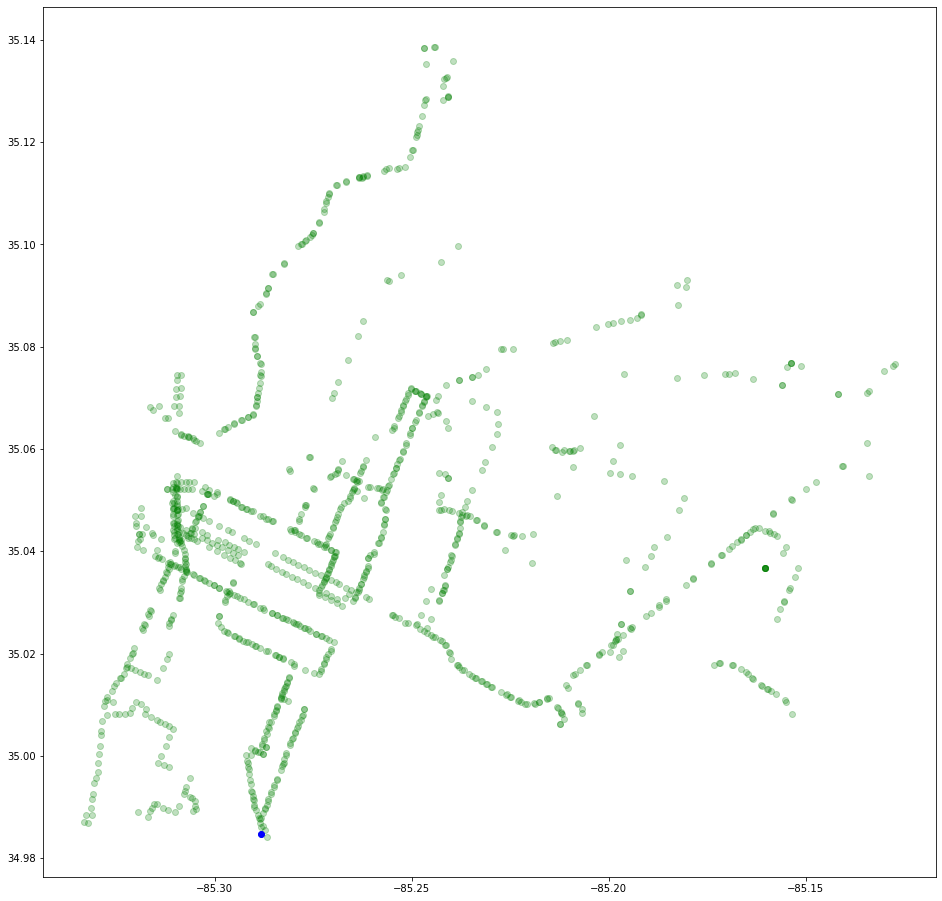

In [357]:
plt.figure(figsize=(16, 16))

plt.plot(Bus_Stops.stop_lon, Bus_Stops.stop_lat, 'o', color = 'green', alpha = 0.25)
plt.plot(-85.28815, 34.98473, 'o', color = 'blue') # '1710'
#plt.plot(-85.288168, 34.986053, 'o', color = 'blue') # '1247'
#plt.plot(-85.286794, 34.984097, 'o', color = 'blue') # '1701'
#plt.plot(-85.287109, 34.98551, 'o', color = 'blue') # '1706'
#------------------------------------------------------------
#plt.plot(-85.31155, 35.025455, 'o', color = 'blue') # '136'
#------------------------------------------------------------
#plt.plot(-85.32301, 35.016102, 'o', color = 'blue') # '1582'
#------------------------------------------------------------
#plt.plot(-85.309435, 35.04425, 'o', color = 'blue') # '17'
#------------------------------------------------------------
#plt.plot(-85.322215, 35.017432, 'o', color = 'blue') # '124'
#------------------------------------------------------------
#plt.plot(-85.323852, 35.015212, 'o', color = 'blue') # '1358'

# Function for Regression Data

In [97]:
def board_data(route, direction, bus_stop, DTFRM):
    import numpy as np
    import pandas as pd
    import datetime as dt
    
    #Input_hour_prev1 = int(hour) - 1
    #Input_hour_prev1 = str(Input_hour_prev1)
    
    #Input_hour_prev2 = int(hour) - 2
    #Input_hour_prev2 = str(Input_hour_prev2) 
       
    dtfrm = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction)]#[['hour', 'board_count']]
    #dtfrm = dtfrm.groupby(['hour'])
    vinit = DTFRM[(DTFRM['route_id'] == route) & (carta['direction_id'] == direction) & (carta['stop_id'] == bus_stop)][['year', 'month', 'service_period', 'hour', 'temp', 'precip']].groupby(['year', 'month', 'service_period', 'hour']).mean()
    vinit = vinit.reset_index(level = ['year', 'month', 'service_period', 'hour'])
    vinit.columns = ['year', 'month', 'service_period', 'hour', 'mean_temp', 'mean_precip']
    
    V1 = dtfrm[(dtfrm['stop_id'] == bus_stop)][['year', 'month', 'service_period', 'hour', 'board_count']]
    V1 = V1.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
    V1 = V1.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
    V1.columns = ['year', 'month', 'service_period', 'hour', 'board_count']
     
    #V1 = v1.merge(vinit, on = ['year', 'month', 'hour'], how = 'left')
        
    #out1 = [V1, V2]
    #out1 = {'V1': V1, 'V2': V2}
    #output1 = pd.DataFrame(out1, columns = ['V1', 'V2'], index = range(0))
    
    Stops = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction)][['stop_sequence', 'stop_id']].drop_duplicates().sort_values(by = ['stop_sequence'])
    Stops = Stops.reset_index(drop = True)
    
    Actual_bus_stop_position = Stops[Stops['stop_id'] == bus_stop].stop_sequence.index[0]
    Prev_bus_stop_position = Actual_bus_stop_position - 1 
    
    #Bus_Stops = [Actual_bus_stop_position, Prev_bus_stop_position]
    
    Prev_bus_stop = Stops.iloc[Prev_bus_stop_position]['stop_id']
    
    Bus_Stops = [bus_stop, Prev_bus_stop]
        
    V3 =  DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction) & (DTFRM['stop_id'] == Prev_bus_stop)][['year', 'month', 'service_period', 'hour', 'board_count']]
    V3 = V3.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
    V3 = V3.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
    V3.columns = ['year', 'month', 'service_period', 'hour', 'board_count_prev_stop']
    
    V = V1.merge(V3, on = ['year', 'month', 'service_period', 'hour'])
    
    if (bus_stop == '1710'):
        
        V4 = DTFRM[(DTFRM['stop_id'] == '1247') | (DTFRM['stop_id'] == '1701') | (DTFRM['stop_id'] == '1706')][['year', 'month', 'service_period', 'hour', 'board_count']]
        V4 = V4.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
        V4 = V4.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
        V4.columns = ['year', 'month', 'service_period', 'hour', 'one_hop_board_count']
        
        V5 = DTFRM[(DTFRM['stop_id'] == '1136') | (DTFRM['stop_id'] == '1707')][['year', 'month', 'service_period', 'hour', 'board_count']]
        V5 = V5.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
        V5 = V5.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
        V5.columns = ['year', 'month', 'service_period', 'hour', 'two_hop_board_count']
        
        vfa = V4.merge(V5, on = ['year', 'month', 'service_period', 'hour'], how = 'left')
        
        Vf = V.merge(vfa, on = ['year', 'month', 'service_period', 'hour'], how = 'left')
        VF = Vf.merge(vinit, on = ['year', 'month', 'service_period', 'hour'])
        
    elif (bus_stop == '136'):
        
        V4 = DTFRM[(DTFRM['stop_id'] == '28') | (DTFRM['stop_id'] == '473') | (DTFRM['stop_id'] == '137')][['year', 'month', 'service_period', 'hour', 'board_count']]
        V4 = V4.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
        V4 = V4.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
        V4.columns = ['year', 'month', 'service_period', 'hour', 'one_hop_board_count']
    
        Vf = V.merge(V4,on = ['year', 'month', 'service_period', 'hour'], how = 'left')
        VF = Vf.merge(vinit, on = ['year', 'month', 'service_period', 'hour'])
        
    elif (bus_stop == '1582'):
        
        V4 = DTFRM[(DTFRM['stop_id'] == '38') | (DTFRM['stop_id'] == '124') | (DTFRM['stop_id'] == '1358') | (DTFRM['stop_id'] == '1358')][['year', 'month', 'service_period', 'hour', 'board_count']]
        V4 = V4.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
        V4 = V4.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
        V4.columns = ['year', 'month', 'service_period', 'hour', 'one_hop_board_count']
    
        Vf = V.merge(V4, on = ['year', 'month', 'service_period', 'hour'], how = 'left')
        VF = Vf.merge(vinit, on = ['year', 'month', 'service_period', 'hour'])
        
    elif (bus_stop == '17'):
        
        V4 = DTFRM[(DTFRM['stop_id'] == '2076') | (DTFRM['stop_id'] == '1310') | (DTFRM['stop_id'] == '1194') | (DTFRM['stop_id'] == '742') | (DTFRM['stop_id'] == '163')][['year', 'month', 'service_period', 'hour', 'board_count']]
        V4 = V4.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
        V4 = V4.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
        V4.columns = ['year', 'month', 'service_period', 'hour', 'one_hop_board_count']
        
        V5 = DTFRM[(DTFRM['stop_id'] == '2071') | (DTFRM['stop_id'] == '1195') | (DTFRM['stop_id'] == '1560') | (DTFRM['stop_id'] == '163')][['year', 'month', 'service_period', 'hour', 'board_count']]
        V5 = V5.groupby(['year', 'month', 'service_period', 'hour', 'board_count']).count()
        V5 = V5.reset_index(level = ['year', 'month', 'service_period', 'hour', 'board_count'])
        V5.columns = ['year', 'month', 'service_period', 'hour', 'two_hop_board_count']
        
        vfa = V4.merge(V5, on = ['year', 'month', 'service_period', 'hour'], how = 'left')
        
        Vf = V.merge(vfa, on = ['year', 'month', 'service_period', 'hour'], how = 'left')
        VF = Vf.merge(vinit, on = ['year', 'month', 'service_period', 'hour'])
        VF.hour = VF['hour'].astype(str)
        VF.month = VF['month'].astype(str)
        VF.year = VF['year'].astype(str)
        VF = VF.dropna() 
        
    elif (bus_stop == '124'):
        
        V4 = DTFRM[(DTFRM['stop_id'] == '1411') | (DTFRM['stop_id'] == '38') | (DTFRM['stop_id'] == '125')][['year', 'month', 'day_of_week', 'hour', 'board_count']]
        V4 = V4.groupby(['year', 'month', 'day_of_week', 'hour', 'board_count']).count()
        V4 = V4.reset_index(level = ['year', 'month', 'day_of_week', 'hour', 'board_count'])
        V4.columns = ['year', 'month', 'day_of_week', 'hour', 'one_hop_board_count']
        
        V5 = DTFRM[(DTFRM['stop_id'] == '1582') | (DTFRM['stop_id'] == '126') | (DTFRM['stop_id'] == '437')][['year', 'month', 'day_of_week', 'hour', 'board_count']]
        V5 = V5.groupby(['year', 'month', 'day_of_week', 'hour', 'board_count']).count()
        V5 = V5.reset_index(level = ['year', 'month', 'day_of_week', 'hour', 'board_count'])
        V5.columns = ['year', 'month', 'day_of_week', 'hour', 'two_hop_board_count']
        
        vfa = V4.merge(V5, on = ['year', 'month', 'day_of_week', 'hour'], how = 'left')
        
        Vf = V.merge(vfa, on = ['year', 'month', 'day_of_week', 'hour'], how = 'left')
    
        VF = Vf.merge(vinit, on = ['year', 'month', 'day_of_week', 'hour'])
        VF.hour = VF['hour'].astype(str)
        VF.month = VF['month'].astype(str)
        VF.year = VF['year'].astype(str)
        VF = VF.dropna() 
        
    elif (bus_stop == '1358'):
        
        V4 = DTFRM[(DTFRM['stop_id'] == '1582') | (DTFRM['stop_id'] == '1355') | (DTFRM['stop_id'] == '1684')][['year', 'month', 'day_of_week', 'hour', 'board_count']]
        V4 = V4.groupby(['year', 'month', 'day_of_week', 'hour', 'board_count']).count()
        V4 = V4.reset_index(level = ['year', 'month', 'day_of_week', 'hour', 'board_count'])
        V4.columns = ['year', 'month', 'day_of_week', 'hour', 'one_hop_board_count']
        
        V5 = DTFRM[(DTFRM['stop_id'] == '38') | (DTFRM['stop_id'] == '41')][['year', 'month', 'day_of_week', 'hour', 'board_count']]
        V5 = V5.groupby(['year', 'month', 'day_of_week', 'hour', 'board_count']).count()
        V5 = V5.reset_index(level = ['year', 'month', 'day_of_week', 'hour', 'board_count'])
        V5.columns = ['year', 'month', 'day_of_week', 'hour', 'two_hop_board_count']
        
        vfa = V4.merge(V5, on = ['year', 'month', 'day_of_week', 'hour'], how = 'left')
        
        Vf = V.merge(vfa, on = ['year', 'month', 'day_of_week', 'hour'], how = 'left')
        
        #Vf = V.merge(V4, on = ['year', 'month', 'hour'], how = 'left')
        VF = Vf.merge(vinit, on = ['year', 'month', 'day_of_week', 'hour'])
        VF.hour = VF['hour'].astype(str)
        VF.month = VF['month'].astype(str)
        VF.year = VF['year'].astype(str)
        VF = VF.dropna() 
        
        
    
    
    #return(vinit)
    #return(Vf)
    #return(VF)
    #return(V4)
    #return(Stops)
    #return(Bus_Stops)
    #return(output1)
    #return(Bus_Stops)
    #return(out3)
    #return(dtfrm)
    return(V)

In [376]:
#vinit = board_data('4', 1, '17', 2, Group_A1_board)
#vf = board_data('4', 1, '17', 2, Group_A1_board)
#vf.head()
board_data('4', 1, '17', Group_A1_board)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,year,month,day_of_week,hour,board_count,board_count_prev_stop


# Regression Models

## Poisson Regression

### Board Counts

In [369]:
def Poiss_Reg_Model_Board(DT):
    
    import numpy as np
    from sklearn import linear_model
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    #df = DT[(DT['route_id'] == rt) & (DT['direction_id'] == di) & (DT['stop_id'] == st)]
    
    num_rows = DT.shape
    n_rows = num_rows[0]
    
    y = np.array(DT['board_count'])
    X = np.array(DT[['year', 'month', 'hour', 'day_of_week', 'board_count_prev_stop', 'one_hop_board_count', 'mean_temp', 'mean_precip']])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
    
    if n_rows >= 150:
        
        k = 10
        kf = KFold(n_splits=k)
        model = linear_model.PoissonRegressor(dual = True, max_iter = 10000, solver = 'lbfgs')
        train_set = []
        test_set = []
        coef_model = []
        model_pred = []
        kf_RMSE = []
        
        for train, test in kf.split(X_train):
            
            tr_set = np.array(train)
            ts_set = np.array(test)
            train_set.append(tr_set)
            test_set.append(ts_set)
            model_kf = model.fit(X_train[train,:], y_train[train])
            
            coefficients = model_kf.coef_
            coef_model.append(coefficients)
            
            predictions = model_kf.predict(X_train[test,:])
            model_pred.append(predictions)
            
            RMSE = mean_squared_error(y_train[test], predictions)
            kf_RMSE.append(RMSE)
            
        kf_RMSE = np.array(kf_RMSE)
        ind_min = np.argmin(kf_RMSE)
             
            
        model = linear_model.PoissonRegressor()
        best_model = model.fit(X_train[train_set[ind_min], :], y_train[train_set[ind_min]])
        best_model_prediction = best_model.predict(X_test)
        best_model_RMSE = mean_squared_error(y_test, best_model_prediction)
        best_model_RMSE 
        
        result = [kf_RMSE[ind_min], best_model_RMSE, ind_min]
        
        return(result)
            
    elif (n_rows < 150):
        Poiss_Reg = linear_model.PoissonRegressor().fit(X_train,y_train)
        Train_set_pred = Poiss_Reg.predict(X_train)
        Train_RMSE = mean_squared_error(y_train, Train_set_pred)
        Poiss_Reg_predict = Poiss_Reg.predict(X_test)
        Poiss_Reg_RMSE = mean_squared_error(y_test, Poiss_Reg_predict)
        result = [Train_RMSE, Poiss_Reg_RMSE, 'NA']
        
        return(result)
        
    

### Direction 0

#### Route 1



#### Route 4


#### Route 9 

In [260]:
dt = Group_A1_board[(Group_A1_board['route_id'] == '9') & (Group_A1_board['direction_id'] == 0) & (Group_A1_board['stop_id'] == '1710')]
dt.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,scheduled_datetime,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,temp,precip
151931,134767,1900-01-01 05:30:00,1900-01-01 05:30:00,1710,78,34.98473,-85.28815,9,0,0,...,2019-01-02 05:30:00,2019-01-02 05:30:00,1900-01-01 04:51:00,2,2019-01-02,5,2019,1,7.823333,0.0
151932,134768,1900-01-01 06:00:00,1900-01-01 05:58:00,1710,78,34.98473,-85.28815,9,0,0,...,2019-01-02 06:00:00,2019-01-02 05:58:00,1900-01-01 05:21:00,2,2019-01-02,5,2019,1,8.450000,0.0
151933,134793,1900-01-01 07:40:00,1900-01-01 07:39:00,1710,67,34.98473,-85.28815,9,0,0,...,2019-01-02 07:40:00,2019-01-02 07:39:00,1900-01-01 07:05:00,2,2019-01-02,7,2019,1,7.970000,0.0
151934,134769,1900-01-01 08:05:00,1900-01-01 08:06:00,1710,67,34.98473,-85.28815,9,0,0,...,2019-01-02 08:05:00,2019-01-02 08:06:00,1900-01-01 07:35:00,2,2019-01-02,8,2019,1,8.520000,0.0
151935,134771,1900-01-01 09:45:00,1900-01-01 09:47:00,1710,67,34.98473,-85.28815,9,0,0,...,2019-01-02 09:45:00,2019-01-02 09:47:00,1900-01-01 09:15:00,2,2019-01-02,9,2019,1,8.098333,0.0


In [213]:
dt.dtypes

trip_id                             int64
scheduled_arrival_time     datetime64[ns]
actual_arrival_time        datetime64[ns]
stop_id                            object
stop_sequence                       int64
stop_lat                          float64
stop_lon                          float64
route_id                           object
direction_id                        int64
board_count                         int64
direction_desc                     object
service_period                     object
date                       datetime64[ns]
scheduled_datetime         datetime64[ns]
actual_arrival_datetime            object
trip_start_time            datetime64[ns]
day_of_week                         int64
trip_date                  datetime64[ns]
hour                               object
year                               object
month                              object
temp                              float64
precip                            float64
dtype: object

In [214]:
dt.day_of_week.unique()

array([2, 3, 5, 6, 0, 1])

##### Day 0:

In [293]:
data0 = board_data('9', 0, '1710', 0, Group_A1_board)
data0.hour = data0['hour'].astype(str)
data0.month = data0['month'].astype(str)
data0.year = data0['year'].astype(str)
data0 = data0.dropna()
data0.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,year,month,hour,board_count,board_count_prev_stop,one_hop_board_count,mean_temp,mean_precip
0,2019,2,8,0,0.0,0.0,13.320000,0.000000
1,2019,2,10,0,0.0,0.0,11.200000,0.000000
2,2019,2,11,0,0.0,0.0,13.630833,0.335833
3,2019,3,14,0,0.0,0.0,31.100000,0.000000
4,2019,3,14,0,0.0,1.0,31.100000,0.000000


In [299]:
data0.dtypes

year                      object
month                     object
hour                      object
board_count                int64
board_count_prev_stop    float64
one_hop_board_count      float64
mean_temp                float64
mean_precip              float64
dtype: object

In [300]:
data0.shape

(27, 8)

In [328]:
Poiss_Reg_Model_Board(data0)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/link.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[0.0, 0.0, 'NA']

##### Day 1:

In [302]:
data1 = board_data('9', 0, '1710', 1, Group_A1_board)
data1.hour = data1['hour'].astype(str)
data1.month = data1['month'].astype(str)
data1.year = data1['year'].astype(str)
data1 = data1.dropna()
data1.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,year,month,hour,board_count,board_count_prev_stop,one_hop_board_count,mean_temp,mean_precip
0,2019,1,5,0,0.0,0.0,11.100000,7.145000
1,2019,1,6,0,0.0,0.0,9.520000,0.640000
2,2019,1,6,0,0.0,1.0,9.520000,0.640000
3,2019,1,10,0,0.0,0.0,19.541667,0.000000
4,2019,1,12,0,0.0,0.0,16.633333,2.058333


In [303]:
data1.dtypes

year                      object
month                     object
hour                      object
board_count                int64
board_count_prev_stop    float64
one_hop_board_count      float64
mean_temp                float64
mean_precip              float64
dtype: object

In [304]:
data1.shape

(65, 8)

In [329]:
Poiss_Reg_Model_Board(data1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/link.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[0.0, 0.0, 'NA']

##### Day 2:

In [316]:
data2 = board_data('9', 0, '1710', 2, Group_A1_board)
data2.hour = data2['hour'].astype(str)
data2.month = data2['month'].astype(str)
data2.year = data2['year'].astype(str)
data2 = data2.dropna()
data2.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,year,month,hour,board_count,board_count_prev_stop,one_hop_board_count,mean_temp,mean_precip
0,2019,1,11,0,0.0,0.0,8.750000,0.0
1,2019,1,12,0,0.0,0.0,2.420000,0.0
3,2019,2,5,0,0.0,0.0,12.200000,0.0
4,2019,2,6,0,0.0,0.0,4.438333,0.0
5,2019,2,6,0,0.0,1.0,4.438333,0.0


In [317]:
data2.dtypes

year                      object
month                     object
hour                      object
board_count                int64
board_count_prev_stop    float64
one_hop_board_count      float64
mean_temp                float64
mean_precip              float64
dtype: object

In [340]:
data2.shape

(60, 8)

In [330]:
Poiss_Reg_Model_Board(data2)

[0.019199574083386534, 0.0009831407547403847, 'NA']

##### Day 3:

In [319]:
data3 = board_data('9', 0, '1710', 3, Group_A1_board)
data3.hour = data3['hour'].astype(str)
data3.month = data3['month'].astype(str)
data3.year = data3['year'].astype(str)
data3 = data3.dropna()
data3.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,year,month,hour,board_count,board_count_prev_stop,one_hop_board_count,mean_temp,mean_precip
0,2019,1,9,0,0.0,0.0,8.580000,0.0
1,2019,1,11,0,0.0,0.0,2.686667,0.0
2,2019,1,13,0,0.0,0.0,1.048333,0.0
3,2019,1,13,0,0.0,1.0,1.048333,0.0
4,2019,2,12,0,0.0,0.0,18.900000,0.0


In [332]:
data3.dtypes

year                      object
month                     object
hour                      object
board_count                int64
board_count_prev_stop    float64
one_hop_board_count      float64
mean_temp                float64
mean_precip              float64
dtype: object

In [339]:
data3.shape

(51, 8)

In [333]:
Poiss_Reg_Model_Board(data3)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/link.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[0.0, 0.0, 'NA']

##### Day 5:

In [335]:
data5 = board_data('9', 0, '1710', 5, Group_A1_board)
data5.hour = data5['hour'].astype(str)
data5.month = data5['month'].astype(str)
data5.year = data5['year'].astype(str)
data5 = data5.dropna()
data5.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,year,month,hour,board_count,board_count_prev_stop,one_hop_board_count,mean_temp,mean_precip
0,2019,1,11,0,0.0,0.0,20.531667,0.0
1,2019,5,16,0,0.0,0.0,28.515000,0.0
2,2019,5,18,0,0.0,0.0,9.106667,0.0
3,2019,7,13,0,0.0,0.0,28.606667,0.0
4,2019,11,18,0,0.0,0.0,16.100000,0.0


In [336]:
data5.dtypes

year                      object
month                     object
hour                      object
board_count                int64
board_count_prev_stop    float64
one_hop_board_count      float64
mean_temp                float64
mean_precip              float64
dtype: object

In [338]:
data5.shape

(5, 8)

In [337]:
Poiss_Reg_Model_Board(data5)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/link.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[0.0, 0.0, 'NA']

##### Day 6:

In [341]:
data6 = board_data('9', 0, '1710', 6, Group_A1_board)
data6.hour = data6['hour'].astype(str)
data6.month = data6['month'].astype(str)
data6.year = data6['year'].astype(str)
data6 = data6.dropna()
data6.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,year,month,hour,board_count,board_count_prev_stop,one_hop_board_count,mean_temp,mean_precip
0,2019,3,10,0,0.0,0.0,29.740000,0.0
1,2019,3,10,0,0.0,1.0,29.740000,0.0
2,2019,3,11,0,0.0,0.0,21.540000,0.0
3,2019,4,11,0,0.0,0.0,32.346667,0.0
4,2019,7,10,0,0.0,0.0,20.600000,0.0


In [342]:
data6.dtypes

year                      object
month                     object
hour                      object
board_count                int64
board_count_prev_stop    float64
one_hop_board_count      float64
mean_temp                float64
mean_precip              float64
dtype: object

In [343]:
data6.shape

(6, 8)

In [344]:
Poiss_Reg_Model_Board(data6)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/link.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[0.0, 0.0, 'NA']

### Direction 1:

### Route 1

#### Bus Stop '124'

In [121]:
dt = Group_A1_board[(Group_A1_board['route_id'] == '1') & (Group_A1_board['direction_id'] == 1) & (Group_A1_board['stop_id'] == '124')]
dt.head() # {'124', '136', '1582'}

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,scheduled_datetime,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,month,date_time,Estimated_Temp,Estimated_Precip
738666,133164,1900-01-01 09:52:20,1900-01-01 09:53:00,124,46,35.017432,-85.322215,1,1,0,...,2019-01-06 09:52:20,2019-01-06 09:53:00,1900-01-01 09:30:00,6,2019-01-06,9,1,2019-01-06 09:52:20,7.225000,0.0
738667,133166,1900-01-01 12:12:20,1900-01-01 12:20:00,124,46,35.017432,-85.322215,1,1,0,...,2019-01-06 12:12:20,2019-01-06 12:20:00,1900-01-01 11:50:00,6,2019-01-06,12,1,2019-01-06 12:12:20,13.375556,0.0
738668,133168,1900-01-01 14:32:20,1900-01-01 14:35:00,124,46,35.017432,-85.322215,1,1,0,...,2019-01-06 14:32:20,2019-01-06 14:35:00,1900-01-01 14:10:00,6,2019-01-06,14,1,2019-01-06 14:32:20,17.016111,0.0
738669,133170,1900-01-01 16:52:20,1900-01-01 16:52:00,124,46,35.017432,-85.322215,1,1,0,...,2019-01-06 16:52:20,2019-01-06 16:52:00,1900-01-01 16:30:00,6,2019-01-06,16,1,2019-01-06 16:52:20,17.800000,0.0
738670,133172,1900-01-01 19:22:20,1900-01-01 19:25:00,124,46,35.017432,-85.322215,1,1,0,...,2019-01-06 19:22:20,2019-01-06 19:25:00,1900-01-01 19:00:00,6,2019-01-06,19,1,2019-01-06 19:22:20,11.157778,0.0


In [122]:
dt.day_of_week.unique()

array([6])

##### Day of week 6:

In [345]:
rt1_dir1_124_data6 =  board_data('1', 1, '124', 6, Group_A1_board)
rt1_dir1_124_data6.hour = rt1_dir1_124_data6['hour'].astype(str)
rt1_dir1_124_data6.month = rt1_dir1_124_data6['month'].astype(str)
rt1_dir1_124_data6.year = rt1_dir1_124_data6['year'].astype(str)
rt1_dir1_124_data6 = rt1_dir1_124_data6.dropna()
rt1_dir1_124_data6.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


UnboundLocalError: local variable 'VF' referenced before assignment

In [ ]:
rt1_dir1_124_data6.dtypes

In [ ]:
rt1_dir1_124_data6.shape

In [124]:
Poiss_Reg_Model_Board(Group_A1_board, '1', 1, '124')

[0.10337544130959506, 0.07090738256470948, 'NA']

In [116]:
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#Poiss_Reg = linear_model.PoissonRegressor().fit(X_train,y_train)
#Poiss_Reg_predict = Poiss_Reg.predict(X_test)
#Poiss_Reg_RMSE = mean_squared_error(y_test, Poiss_Reg_predict)
#Poiss_Reg_RMSE

In [ ]:
#Poiss_Reg_predict = np.array([Poiss_Reg_predict]).reshape(len(y_test))
#Poiss_Reg_predict

In [ ]:
#y_test = y_test.reshape(16)
#y_test

In [ ]:
#Results = {'Observed': y_test, 'Predicted': Poiss_Reg_predict}
#Poiss_Reg_Results = pd.DataFrame(data = Results, columns = ['Observed', 'Predicted'])
#Poiss_Reg_Results.head()

In [ ]:
#ax = Poiss_Reg_Results.plot.scatter(x = 'Observed', y = 'Predicted')

#### Bus Stop '1358'

In [ ]:
dt = Group_A1_board[(Group_A1_board['route_id'] == '1') & (Group_A1_board['direction_id'] == 1) & (Group_A1_board['stop_id'] == '1358')]
dt.head()

#### Bus Stop '136' 

In [179]:
dt = Group_A1_board[(Group_A1_board['route_id'] == '1') & (Group_A1_board['direction_id'] == 1) & (Group_A1_board['stop_id'] == '136')]
dt.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,scheduled_datetime,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,temp,precip
443076,133083,1900-01-01 00:13:24,1900-01-01 00:17:00,136,59,35.025455,-85.31155,1,1,0,...,2019-01-04 00:13:24,2019-01-03 00:17:00,1900-01-01 23:55:00,3,2019-01-03,0,2019,1,14.430000,8.655000
443077,133040,1900-01-01 06:06:49,1900-01-01 06:08:00,136,56,35.025455,-85.31155,1,1,0,...,2019-01-03 06:06:49,2019-01-03 06:08:00,1900-01-01 05:45:00,3,2019-01-03,6,2019,1,12.800000,5.728333
443078,133041,1900-01-01 06:31:49,1900-01-01 06:30:00,136,56,35.025455,-85.31155,1,1,0,...,2019-01-03 06:31:49,2019-01-03 06:30:00,1900-01-01 06:10:00,3,2019-01-03,6,2019,1,12.825000,6.270000
443079,133042,1900-01-01 06:51:49,1900-01-01 06:56:00,136,56,35.025455,-85.31155,1,1,0,...,2019-01-03 06:51:49,2019-01-03 06:56:00,1900-01-01 06:30:00,3,2019-01-03,6,2019,1,-1.278333,0.000000
443080,133053,1900-01-01 08:11:49,1900-01-01 08:11:00,136,56,35.025455,-85.31155,1,1,0,...,2019-01-03 08:11:49,2019-01-03 08:11:00,1900-01-01 07:50:00,3,2019-01-03,8,2019,1,12.975000,5.490000


In [180]:
dt.day_of_week.unique()

array([3, 4])

#### Bus Stop '1582' 

In [189]:
dt = Group_A1_board[(Group_A1_board['route_id'] == '1') & (Group_A1_board['direction_id'] == 1) & (Group_A1_board['stop_id'] == '1582')]
dt.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,scheduled_datetime,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,temp,precip
2777,133083,1900-01-01 00:10:59,1900-01-01 00:13:00,1582,48,35.016102,-85.32301,1,1,0,...,2019-01-03 00:10:59,2019-01-02 00:13:00,1900-01-01 23:55:00,2,2019-01-02,0,2019,1,10.560000,0.0
2778,133039,1900-01-01 05:41:58,1900-01-01 05:44:00,1582,45,35.016102,-85.32301,1,1,0,...,2019-01-02 05:41:58,2019-01-02 05:44:00,1900-01-01 05:25:00,2,2019-01-02,5,2019,1,7.200000,0.0
2779,133041,1900-01-01 06:26:58,1900-01-01 06:27:00,1582,45,35.016102,-85.32301,1,1,0,...,2019-01-02 06:26:58,2019-01-02 06:27:00,1900-01-01 06:10:00,2,2019-01-02,6,2019,1,9.651667,0.0
2780,133045,1900-01-01 07:46:58,1900-01-01 07:50:00,1582,45,35.016102,-85.32301,1,1,0,...,2019-01-02 07:46:58,2019-01-02 07:50:00,1900-01-01 07:30:00,2,2019-01-02,7,2019,1,7.310000,0.0
2781,133053,1900-01-01 08:06:58,1900-01-01 08:10:00,1582,45,35.016102,-85.32301,1,1,0,...,2019-01-02 08:06:58,2019-01-02 08:10:00,1900-01-01 07:50:00,2,2019-01-02,8,2019,1,9.853333,0.0


In [190]:
dt.day_of_week.unique()

array([2])

#### Bus Stop '17' 

In [206]:
dt = Group_A1_board[(Group_A1_board['route_id'] == '4') & (Group_A1_board['direction_id'] == 1) & (Group_A1_board['stop_id'] == '17')]
dt.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,scheduled_datetime,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,temp,precip
381394,134370,1900-01-01 09:17:22,1900-01-01 09:12:00,17,92,35.04425,-85.309435,4,1,0,...,2019-01-02 09:17:22,2019-01-02 09:12:00,1900-01-01 08:15:00,2,2019-01-02,9,2019,1,11.595000,0.0
381395,134379,1900-01-01 09:32:22,1900-01-01 09:37:00,17,92,35.04425,-85.309435,4,1,0,...,2019-01-02 09:32:22,2019-01-02 09:37:00,1900-01-01 08:30:00,2,2019-01-02,9,2019,1,11.075000,0.0
381396,134365,1900-01-01 10:17:22,1900-01-01 10:23:00,17,92,35.04425,-85.309435,4,1,0,...,2019-01-02 10:17:22,2019-01-02 10:23:00,1900-01-01 09:15:00,2,2019-01-02,10,2019,1,10.775000,0.0
381397,134390,1900-01-01 13:27:22,1900-01-01 13:28:00,17,92,35.04425,-85.309435,4,1,0,...,2019-01-02 13:27:22,2019-01-02 13:28:00,1900-01-01 12:20:00,2,2019-01-02,13,2019,1,11.338333,0.0
381398,134388,1900-01-01 13:57:22,1900-01-01 13:54:00,17,92,35.04425,-85.309435,4,1,0,...,2019-01-02 13:57:22,2019-01-02 13:54:00,1900-01-01 12:50:00,2,2019-01-02,13,2019,1,12.058333,0.0


In [207]:
dt.day_of_week.unique()

array([2, 4, 5, 6])

In [ ]:
y = np.array(dt['board_count'])
X = np.array(dt[['hour', 'month', 'Estimated_Temp', 'Estimated_Precip']])

In [120]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# prepare the cross-validation procedure
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

k = 10
kf = KFold(n_splits=k)
model = linear_model.PoissonRegressor()

train_set = []
test_set = []
coef_model = []
model_pred = []
kf_RMSE = []

for train, test in kf.split(X_train):
    tr_set = np.array(train)
    ts_set = np.array(test)
    train_set.append(tr_set)
    test_set.append(ts_set)
    model_kf = model.fit(X_train[tr_set,:], y_train[tr_set])
    
    coefficients = model_kf.coef_
    coef_model.append(coefficients)
    predictions = model_kf.predict(X_train[ts_set,:])
    model_pred.append(predictions)
    RMSE = mean_squared_error(y_train[ts_set], predictions)
    kf_RMSE.append(RMSE)
    

kf_RMSE = np.array(kf_RMSE)
index_min = np.argmin(kf_RMSE)
index_min



#print(RMSE)

#index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#Results = {'Fold': Fold, 'RMSE': kf_RMSE}
#Poiss_Reg_Results = pd.DataFrame({'Fold': [Fold], 'RMSE': [kf_RMSE]}, columns = ['Fold', 'RMSE'], index = index)    
# evaluate model

#scores = cross_val_score(model, X_train, y_train, cv = kf, n)

# report performance

#print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
#Poiss_Reg_predict = Poiss_Reg.predict(X_test)
#Poiss_Reg_RMSE = mean_squared_error(y_test, Poiss_Reg_predict)
#Poiss_Reg_RMSE

8

In [121]:
model = linear_model.PoissonRegressor() #.fit(X_train[train_set[index_min], :], y_train[index_min])
best_model = model.fit(X_train[train_set[index_min], :], y_train[train_set[index_min]]) 
best_model_prediction = best_model.predict(X_test)
best_model_RMSE = mean_squared_error(y_test, best_model_prediction)
best_model_RMSE 


0.03884862677746239

In [122]:
#train_set

It can be very useful to think about our bus stops similarly to the way that Gelman and Hill think about counties in Minnesota where many radon measurements were taken and counties where there were few radon measurements in the case study in "Data Analysis with Regression and Multilevel/Hierarchical Models."

* Add AIC o WIC

We are ignoring valuable information from surround bus stops, so it might important to understand the relationship betweeen the a given bus stop and the surroingding bus stops. We might get insights from this relationship:
* Bus stop with counts next to bus stop with high proportion of zero counts.


In [132]:
Poiss_Reg_Model_Board(dt, '1', 1, '136')

[0.0010921608275831515, 0.03884862677746239, 8]

# Spatial Grid

In [110]:
import geopandas as gpd
import pyproj
import shapely
import rtree
import pygeos
import fiona
import geopy

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [134]:
crs = pyproj.CRS('+proj=lcc +lat_1=36.41666666666666 +lat_2=35.25 +lat_0=34.33333333333334 +lon_0=-86 +x_0=600000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')
crs

<Bound CRS: +proj=lcc +lat_1=36.41666666666666 +lat_2=35.25 +l ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from unknown to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: Unknown based on GRS80 ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: unknown

In [135]:
gdf = gpd.GeoDataFrame(carta, geometry = gpd.points_from_xy(carta['stop_lon'], carta['stop_lat']),
                      crs = "+proj=lcc +lat_1=36.41666666666666 +lat_2=35.25 +lat_0=34.33333333333334 +lon_0=-86 +x_0=600000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")

gdf.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,alight_count,...,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month,geometry
0,139145,1900-01-01 08:51:00,354,1,35.056167,-85.268713,16,0,0,0,...,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:51:00,1900-01-01 08:51:00,4,2019-11-01,8,11,POINT (-85.26871 35.05617)
1,139145,1900-01-01 08:54:59,505,2,35.056017,-85.281080,16,0,0,0,...,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:54:59,1900-01-01 08:51:00,4,2019-11-01,8,11,POINT (-85.28108 35.05602)
2,139145,1900-01-01 09:05:00,1713,3,35.042000,-85.308670,16,0,1,1,...,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:00,1900-01-01 08:51:00,4,2019-11-01,9,11,POINT (-85.30867 35.04200)
3,139145,1900-01-01 09:05:21,1560,4,35.042880,-85.309102,16,0,0,0,...,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:21,1900-01-01 08:51:00,4,2019-11-01,9,11,POINT (-85.30910 35.04288)
4,139145,1900-01-01 09:05:39,163,5,35.043448,-85.309277,16,0,0,0,...,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:39,1900-01-01 08:51:00,4,2019-11-01,9,11,POINT (-85.30928 35.04345)


## Spatial aggreagtion function

In [139]:
def get_gridded_mean(DF, mn, cll_sz):
    # Get daily means
    crs = pyproj.CRS('+proj=lcc +lat_1=36.41666666666666 +lat_2=35.25 +lat_0=34.33333333333334 +lon_0=-86 +x_0=600000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')
    
    dt = DF[['stop_lat', 'stop_lon', 'board_count', 'date', 'month']]
    dt_mn = dt[dt['month'] == mn]
    dt_mn_gdf = gpd.GeoDataFrame(dt_mn, geometry = gpd.points_from_xy(dt_mn['stop_lon'], dt_mn['stop_lat']),
                                 crs = "+proj=lcc +lat_1=36.41666666666666 +lat_2=35.25 +lat_0=34.33333333333334 +lon_0=-86 +x_0=600000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    dt_mn_gdf = dt_mn_gdf.drop(['stop_lat', 'stop_lon'], axis = 1)
    
    xmin, ymin, xmax, ymax = dt_mn_gdf.total_bounds
    
    cell_size = cll_sz # 1/111
    n_cells = divmod((xmax - xmin), cell_size)[0] + 2
    #n_cells = 100
    
    grid_cells = []
    
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            # bounds
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
            
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                            crs=crs)
    
    merged_dt_mn = gpd.sjoin(dt_mn_gdf, cell, op = 'within', how = 'left')
    dissolve_merged_dt_mn = merged_dt_mn.dissolve(by = "index_right", aggfunc="mean")
    cell.loc[dissolve_merged_dt_mn.index, 'board_count'] = dissolve_merged_dt_mn.board_count.values
    
    ax = cell.plot(column='board_count', figsize=(12, 12),
                   cmap = 'viridis', vmax = 2, 
                   edgecolor="grey", #scheme='quantiles',
                   legend = True,
                   legend_kwds = {'label': 'Mean Board Count',
                                  'orientation': 'horizontal'})
    ax.set(title = 'Mean board counts')
    ax.set_aspect('equal')
    
    


## Pre-lockdown

### January

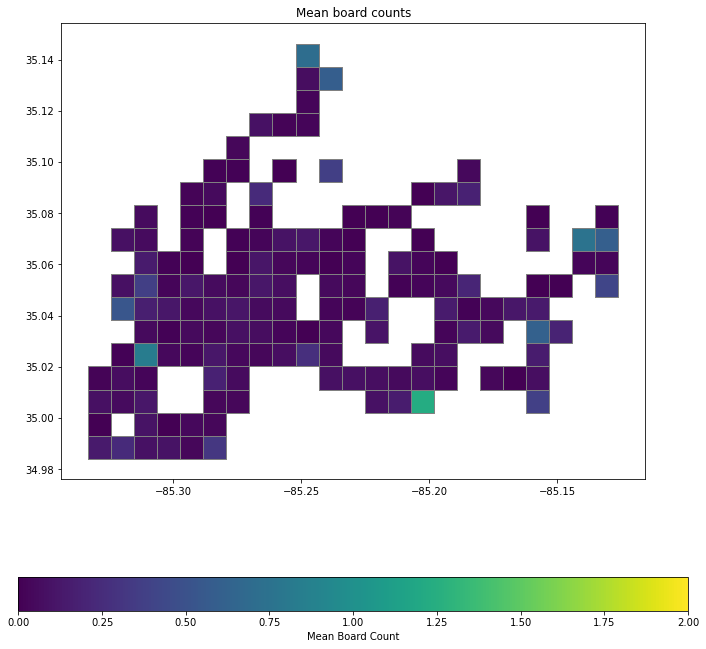

In [140]:
get_gridded_mean(Pre_lock, '1', 1/111)

### February

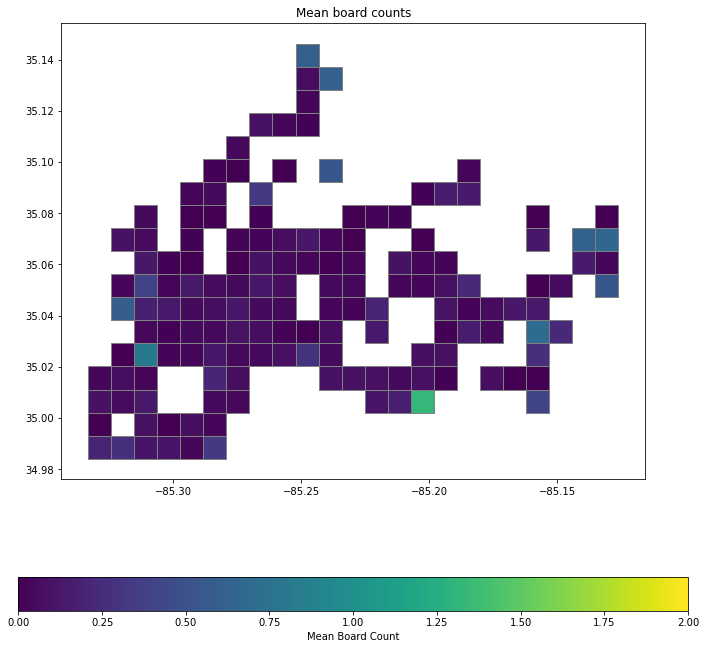

In [141]:
get_gridded_mean(Pre_lock, '2', 1/111)

### March

In [461]:
#get_gridded_mean(Pre_lock, '3', 1/111)
carta.stop_id.nunique()

1200

## Post-lockdown 

### April

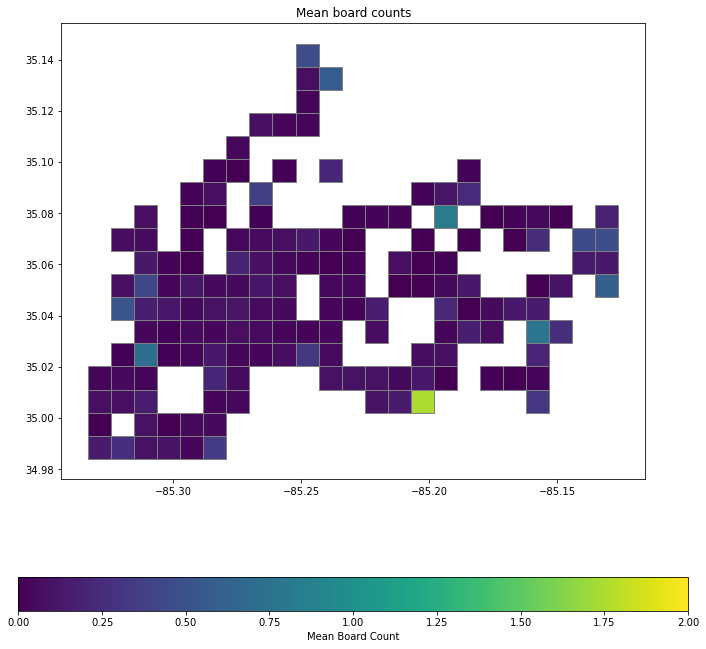

In [143]:
get_gridded_mean(Post_lock, '4', 1/111)

### May

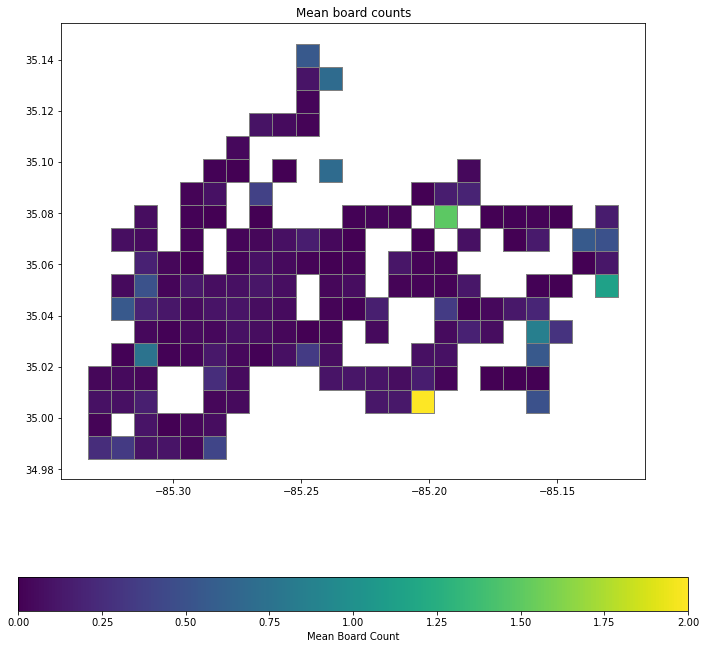

In [144]:
get_gridded_mean(Post_lock, '5', 1/111)

### June

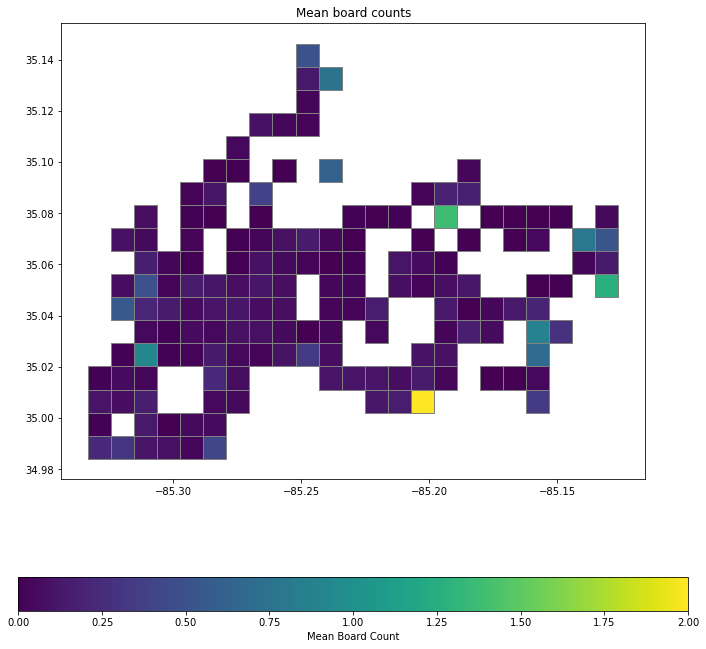

In [145]:
get_gridded_mean(Post_lock, '6', 1/111)

## Complete Data

### January

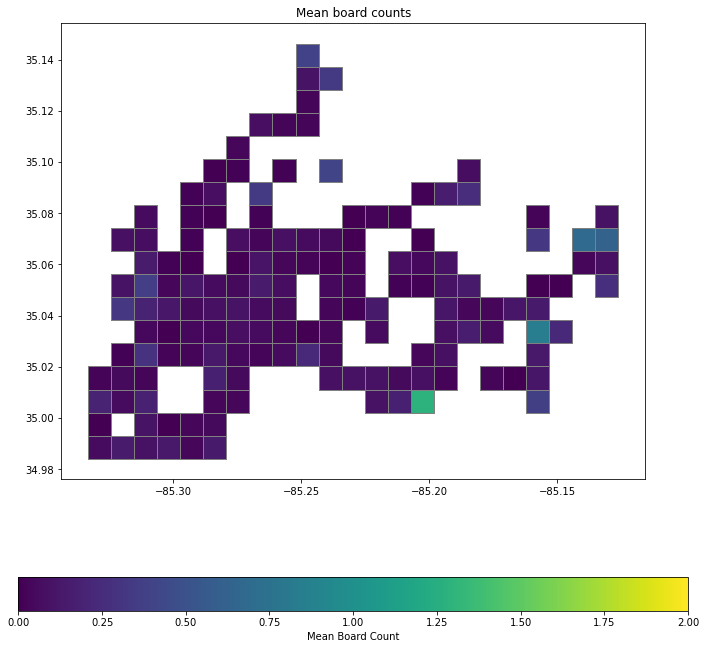

In [146]:
get_gridded_mean(carta, '1', 1/111)

### February

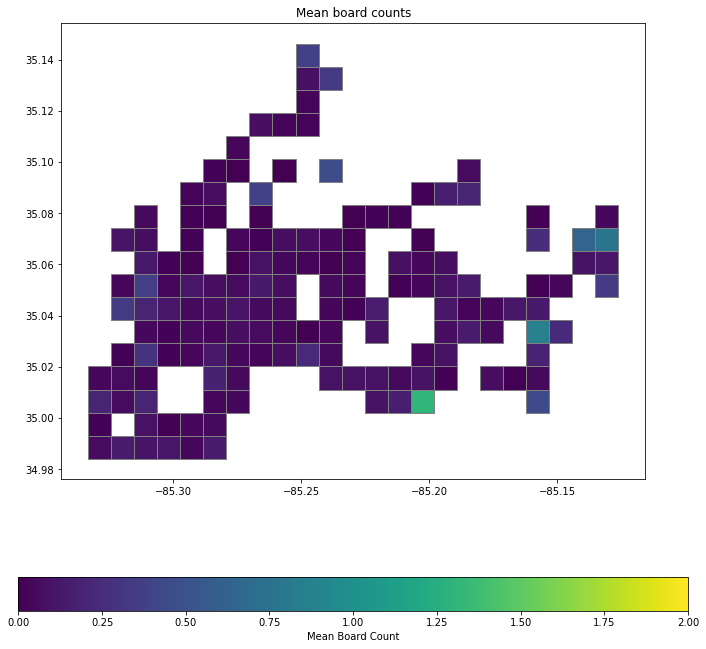

In [147]:
get_gridded_mean(carta, '2', 1/111)

### March

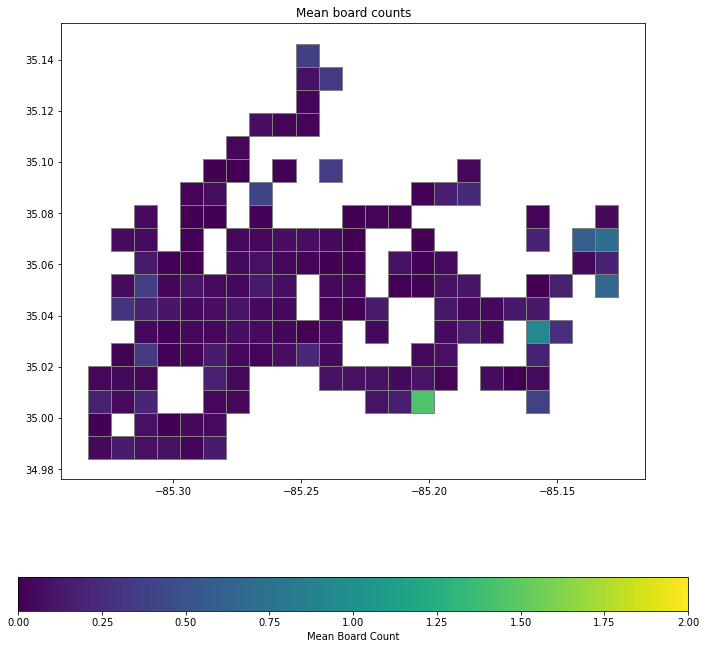

In [148]:
get_gridded_mean(carta, '3', 1/111)

### April

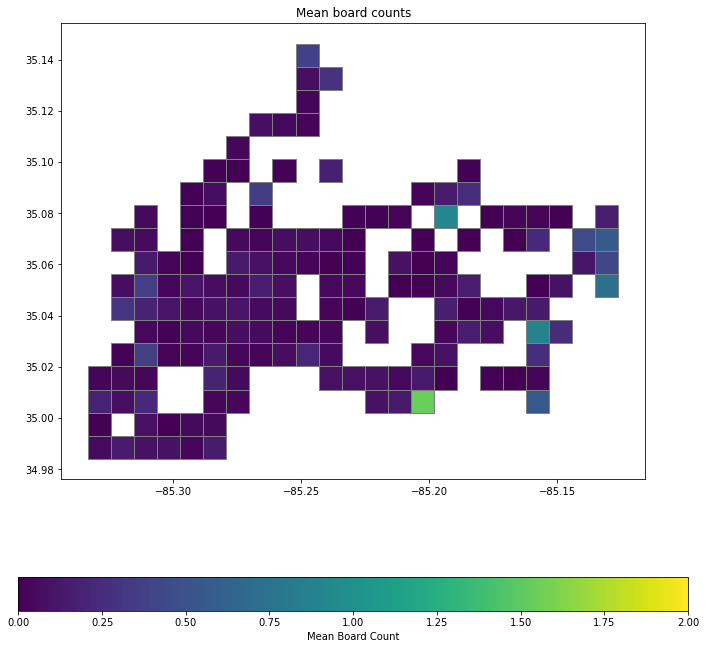

In [149]:
get_gridded_mean(carta, '4', 1/111)

### May

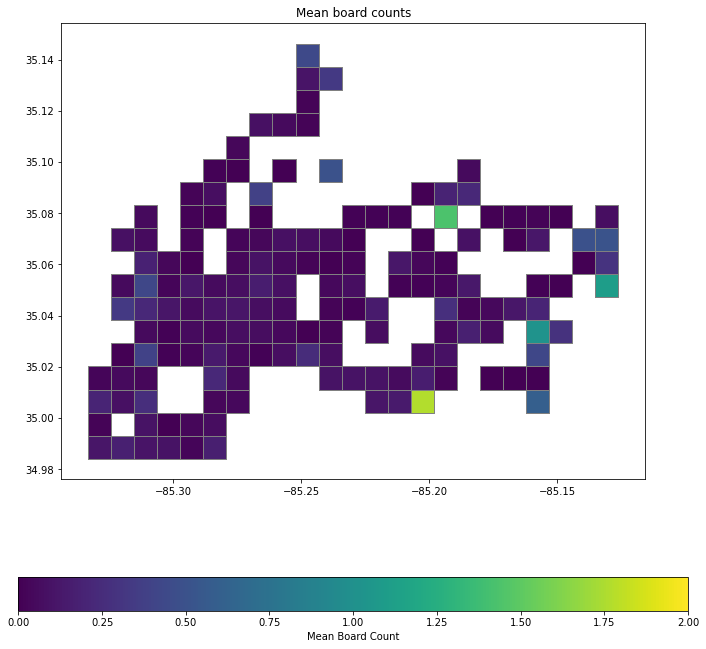

In [150]:
get_gridded_mean(carta, '5', 1/111)

### June

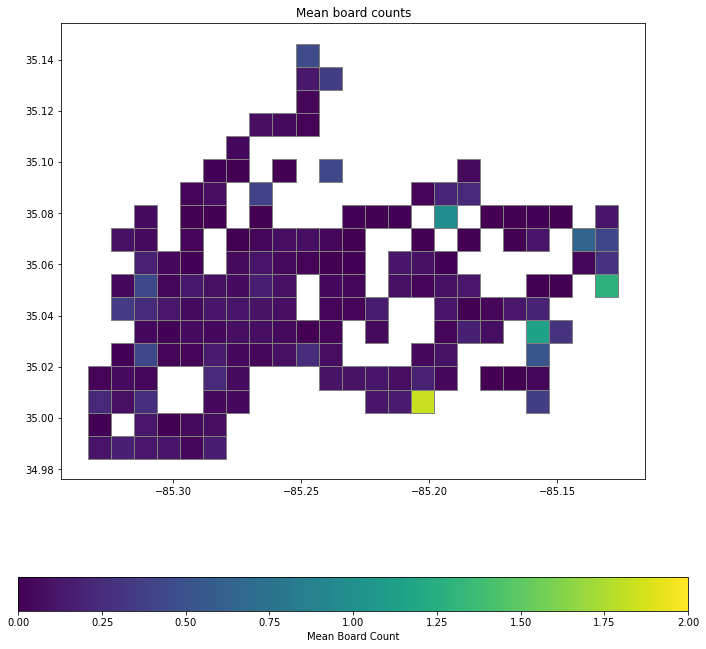

In [151]:
get_gridded_mean(carta, '6', 1/111)

### July

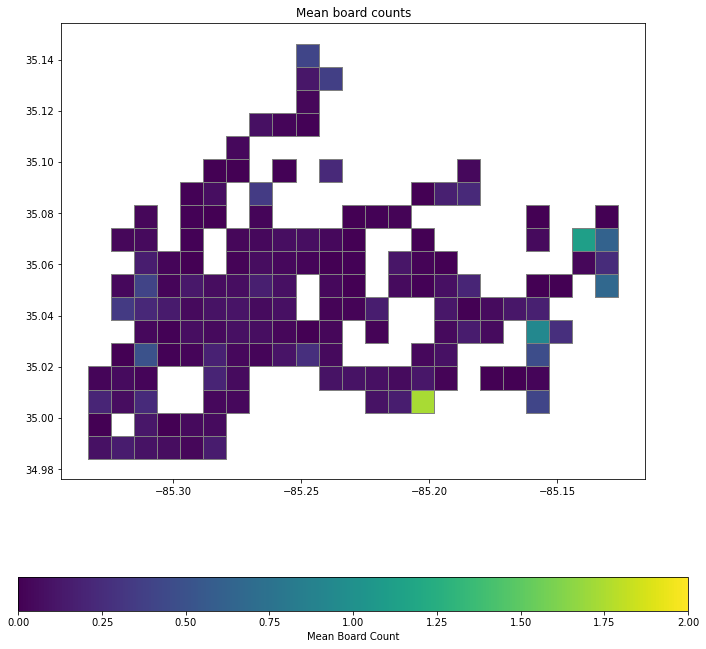

In [152]:
get_gridded_mean(carta, '7', 1/111)

### August

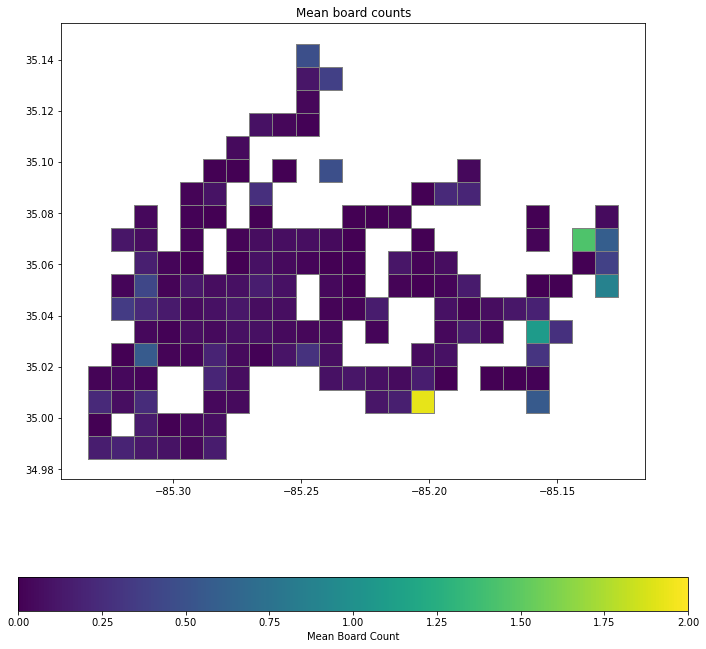

In [153]:
get_gridded_mean(carta, '8', 1/111)

### September

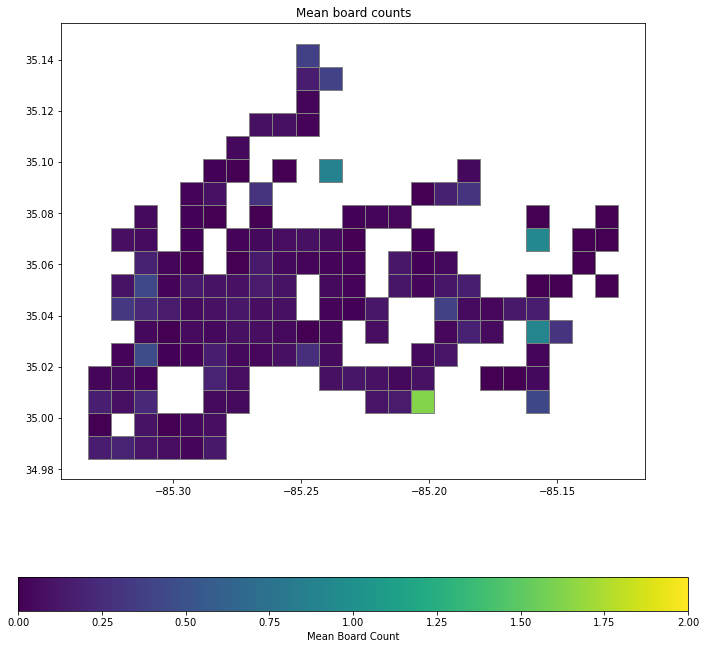

In [154]:
get_gridded_mean(carta, '9', 1/111)

### October

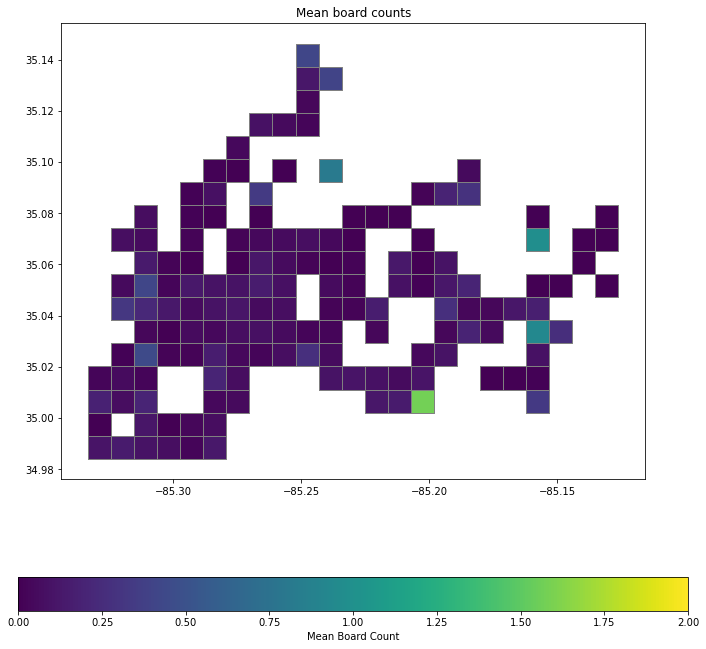

In [155]:
get_gridded_mean(carta, '10', 1/111)

### November

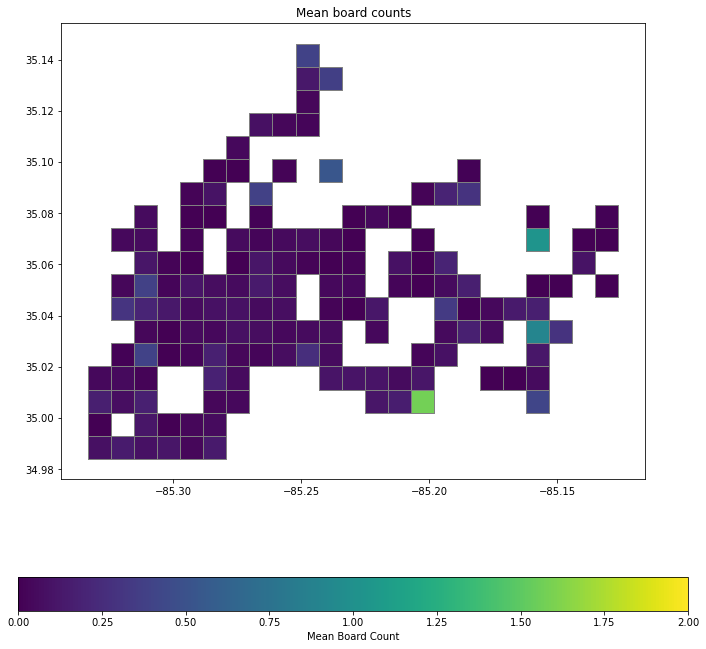

In [156]:
get_gridded_mean(carta, '11', 1/111)

In [772]:
from google.cloud import storage

In [773]:
def create_bucket_class_location(bucket_name):
    """Create a new bucket in specific location with storage class"""
    # bucket_name = "your-new-bucket-name"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    bucket.storage_class = "COLDLINE"
    new_bucket = storage_client.create_bucket(bucket, location="us")

    print(
        "Created bucket {} in {} with storage class {}".format(
            new_bucket.name, new_bucket.location, new_bucket.storage_class
        )
    )
    return new_bucket

In [ ]:
create_bucket_class_location(bucket_name)